# General Tips
## Using virtual environments
**Step 1:** CD to desired directory and Create a Virtual Environment `python3 -m venv myenv`. (Run `py -3.13 -m venv myenv` for a specific version of python)

Check your python installed versions with `py -0` on Windows (`python3 --version` on Linux)

**Step 2:** Activate the Environment `source myenv/bin/activate` (on Linux) and `myenv\Scripts\activate` (on Windows).

**Step 3:** Install Any Needed Packages. e.g: `pip install requests pandas`. Or better to use `requirements.txt` file (`pip install -r requirements.txt`)

**Step 4:** List All Installed Packages using `pip list`

## Connecting the Jupyter Notebook to the vistual env
1. Make sure that myenv is activate (`myenv\Scripts\activate`)
2. Run this inside the virtual environment: `pip install ipykernel`
3. Still inside the environment: `python -m ipykernel install --user --name=myenv --display-name "Whatever Python Kernel Name"`
   
   --name=myenv: internal identifier for the kernel
   
   --display-name: name that shows up in VS Code kernel picker
4. Open VS Code and select the kernel

   At the top-right, click "Select Kernel".
   Look for “Whatever Python Kernel Name” — pick that.
5. If you don’t see it right away, try: Reloading VS Code, Or running Reload Window from Command Palette (Ctrl+Shift+P)

## Useful Commands
1. Use `py -0` to check which python installation we have on Windows

In [19]:
# ============================================================================
# Text-Based Evaluation Notebook - FinanceBench RAG
# Evaluating Retrieval with Page-Based AND Text-Based Metrics
# ============================================================================

# %% [markdown]
# # FinanceBench Text-Based Evaluation
# 
# This notebook evaluates RAG retrieval performance using BOTH:
# 1. **Page-based metrics**: MRR, Recall, Precision, F1 (based on page number matching)
# 2. **Text-based metrics**: MRR, Recall, Precision, F1 (based on semantic similarity)
# 
# We use Sentence-BERT (all-MiniLM-L6-v2) to compute cosine similarity between
# retrieved chunks and ground truth evidence text.

# %% [markdown]
# ## 1.1 Standard Imports

# %%
import os
import json
from pathlib import Path
from typing import List, Dict, Tuple, Optional
from collections import defaultdict

# Environment
from dotenv import load_dotenv

# Progress tracking
from tqdm.auto import tqdm

# Data handling
from datasets import load_dataset

# Numerical operations
import numpy as np

# Vector stores and embeddings
from langchain.vectorstores import Chroma
from langchain_ollama import OllamaEmbeddings
from langchain_openai import OpenAIEmbeddings
from langchain_voyageai import VoyageAIEmbeddings

print("✓ Standard imports successful")

# %% [markdown]
# ## 1.2 Text Similarity Imports (NEW)

# %%
# Sentence-BERT for semantic similarity
from sentence_transformers import SentenceTransformer

# Cosine similarity calculation
from sklearn.metrics.pairwise import cosine_similarity

print("✓ Text similarity imports successful")

# %% [markdown]
# ## 1.3 Load Environment Variables

# %%
# Load .env file
load_dotenv()

# API Keys and URLs
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
OLLAMA_BASE_URL = os.getenv("OLLAMA_BASE_URL", "http://localhost:11434")
VOYAGE_API_KEY = os.getenv("VOYAGE_API_KEY")

# Verify API keys
if OPENAI_API_KEY:
    print("✓ OpenAI API key loaded")
else:
    print("⚠ OpenAI API key not found (only needed if using OpenAI embeddings)")

if VOYAGE_API_KEY:
    print("✓ VoyageAI API key loaded")
else:
    print("⚠ VoyageAI API key not found (only needed if using VoyageAI embeddings)")

print(f"✓ Ollama URL: {OLLAMA_BASE_URL}")

# %% [markdown]
# ## 1.4 Configuration Variables

# %%
# Directory paths
VECTOR_DB_BASE_DIR = "../../vector_databases"
OUTPUT_DIR = "../../evaluation_results/baseline"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Dataset configuration
DATASET_NAME = "PatronusAI/financebench"
DATASET_SPLIT = "train"

# Vector database configuration
COLLECTION_PREFIX = "financebench_docs_chunk_"

# ============================================================================
# TEXT-BASED EVALUATION PARAMETERS (NEW)
# ============================================================================

# Sentence-BERT model for semantic similarity
SBERT_MODEL_NAME = "all-MiniLM-L6-v2"

# Similarity threshold for text-based matching
# Chunks with cosine similarity >= this threshold are considered matches
TEXT_SIMILARITY_THRESHOLD = 0.8

# Chunk text preview settings
# We store abbreviated chunk text: "first N chars...last N chars"
CHUNK_TEXT_PREFIX_CHARS = 100  # Characters to keep from start
CHUNK_TEXT_SUFFIX_CHARS = 100  # Characters to keep from end

# ============================================================================

print("✓ Configuration set")
print(f"  Vector DB Directory: {VECTOR_DB_BASE_DIR}")
print(f"  Output Directory: {OUTPUT_DIR}")
print(f"\n  Sentence-BERT Model: {SBERT_MODEL_NAME}")
print(f"  Text Similarity Threshold: {TEXT_SIMILARITY_THRESHOLD}")
print(f"  Chunk Text Preview: First {CHUNK_TEXT_PREFIX_CHARS} + Last {CHUNK_TEXT_SUFFIX_CHARS} chars")

# %% [markdown]
# ## 1.5 Load FinanceBench Dataset

# %%
print("\nLoading FinanceBench dataset...")
dataset = load_dataset(DATASET_NAME, split=DATASET_SPLIT)
print(f"✓ Loaded {len(dataset)} queries")

# Show sample query with evidence structure
print("\nSample query:")
sample = dataset[0]
print(f"  ID: {sample['financebench_id']}")
print(f"  Company: {sample['company']}")
print(f"  Question: {sample['question'][:100]}...")
print(f"  Doc: {sample['doc_name']}")
print(f"  Evidence items: {len(sample['evidence'])}")

# Show evidence structure
if len(sample['evidence']) > 0:
    print("\n  First evidence item structure:")
    evidence_item = sample['evidence'][0]
    print(f"    - doc_name: {evidence_item['doc_name']}")
    print(f"    - evidence_page_num: {evidence_item['evidence_page_num']}")
    print(f"    - evidence_text (first 100 chars): {evidence_item['evidence_text'][:100]}...")
    print(f"    - Has 'evidence_text_full_page': {'evidence_text_full_page' in evidence_item}")

# %%
print("\n" + "="*60)
print("✓ STEP 1 COMPLETE!")
print("="*60)
print("  ✓ All imports loaded")
print("  ✓ Environment variables configured")
print("  ✓ Paths set up")
print(f"  ✓ Dataset loaded: {len(dataset)} queries")
print(f"  ✓ Text similarity threshold: {TEXT_SIMILARITY_THRESHOLD}")
print(f"  ✓ Chunk preview length: {CHUNK_TEXT_PREFIX_CHARS} + {CHUNK_TEXT_SUFFIX_CHARS} chars")
print("="*60)

✓ Standard imports successful
✓ Text similarity imports successful
✓ OpenAI API key loaded
✓ VoyageAI API key loaded
✓ Ollama URL: http://localhost:11434
✓ Configuration set
  Vector DB Directory: ../../vector_databases
  Output Directory: ../../evaluation_results/baseline

  Sentence-BERT Model: all-MiniLM-L6-v2
  Text Similarity Threshold: 0.8
  Chunk Text Preview: First 100 + Last 100 chars

Loading FinanceBench dataset...
✓ Loaded 150 queries

Sample query:
  ID: financebench_id_03029
  Company: 3M
  Question: What is the FY2018 capital expenditure amount (in USD millions) for 3M? Give a response to the quest...
  Doc: 3M_2018_10K
  Evidence items: 1

  First evidence item structure:
    - doc_name: 3M_2018_10K
    - evidence_page_num: 59
    - evidence_text (first 100 chars): Table of Contents 
3M Company and Subsidiaries
Consolidated Statement of Cash Flow s
Years ended Dec...
    - Has 'evidence_text_full_page': True

✓ STEP 1 COMPLETE!
  ✓ All imports loaded
  ✓ Environment var

In [ ]:
# ============================================================================
# Step 2: Load Sentence-BERT Model
# ============================================================================

# %% [markdown]
# ## 2.1 Load Sentence-BERT Model
# 
# We load the `all-MiniLM-L6-v2` model once at the start.
# This model will be used to:
# 1. Encode evidence texts (done once and cached)
# 2. Encode retrieved chunk texts (done for each retrieval)
# 3. Calculate cosine similarity between them

# %%
def load_sentence_bert_model(model_name: str = SBERT_MODEL_NAME):
    """
    Load Sentence-BERT model for semantic similarity computation.
    
    Args:
        model_name: Name of the sentence-transformers model
        
    Returns:
        SentenceTransformer model instance
    
    Notes:
        - all-MiniLM-L6-v2: 384-dimensional embeddings, ~80MB model
        - First load downloads model from HuggingFace
        - Subsequent loads use cached model
        - Uses CPU by default (can be moved to GPU if available)
    """
    print(f"\nLoading Sentence-BERT model: {model_name}")
    print("  (First run will download model from HuggingFace...)")
    
    try:
        model = SentenceTransformer(model_name)
        print(f"✓ Model loaded successfully")
        print(f"  Embedding dimension: {model.get_sentence_embedding_dimension()}")
        print(f"  Max sequence length: {model.max_seq_length}")
        
        return model
        
    except Exception as e:
        print(f"✗ Failed to load model: {e}")
        raise

# %%
# Load the model
sbert_model = load_sentence_bert_model()

# %% [markdown]
# ## 2.2 Test the Model
# 
# Let's verify the model works correctly by encoding sample texts

# %%
def test_sentence_bert_model(model):
    """
    Test Sentence-BERT model with sample texts.
    Verifies encoding and similarity calculation work correctly.
    """
    print("\n" + "="*60)
    print("TESTING SENTENCE-BERT MODEL")
    print("="*60)
    
    # Sample texts
    text1 = "The company's revenue increased by 15% in Q4 2023."
    text2 = "Revenue grew 15 percent in the fourth quarter of 2023."
    text3 = "The weather was sunny and pleasant today."
    
    print("\nTest texts:")
    print(f"  Text 1: {text1}")
    print(f"  Text 2: {text2}")
    print(f"  Text 3: {text3}")
    
    # Encode texts
    print("\nEncoding texts...")
    embeddings = model.encode([text1, text2, text3])
    
    print(f"✓ Generated embeddings shape: {embeddings.shape}")
    print(f"  (3 texts × {embeddings.shape[1]} dimensions)")
    
    # Calculate similarities
    print("\nCalculating cosine similarities:")
    
    # Similarity between text1 and text2 (semantically similar)
    sim_1_2 = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    print(f"  Text 1 ↔ Text 2: {sim_1_2:.4f} (should be HIGH - same meaning)")
    
    # Similarity between text1 and text3 (semantically different)
    sim_1_3 = cosine_similarity([embeddings[0]], [embeddings[2]])[0][0]
    print(f"  Text 1 ↔ Text 3: {sim_1_3:.4f} (should be LOW - different topics)")
    
    # Similarity between text2 and text3 (semantically different)
    sim_2_3 = cosine_similarity([embeddings[1]], [embeddings[2]])[0][0]
    print(f"  Text 2 ↔ Text 3: {sim_2_3:.4f} (should be LOW - different topics)")
    
    # Verify results make sense
    print("\nValidation:")
    if sim_1_2 > 0.8:
        print(f"  ✓ Similar texts have high similarity ({sim_1_2:.4f} > 0.8)")
    else:
        print(f"  ⚠ Similar texts have lower similarity than expected ({sim_1_2:.4f})")
    
    if sim_1_3 < 0.5:
        print(f"  ✓ Different texts have low similarity ({sim_1_3:.4f} < 0.5)")
    else:
        print(f"  ⚠ Different texts have higher similarity than expected ({sim_1_3:.4f})")
    
    print("\n" + "="*60)
    print("✓ MODEL TEST COMPLETE")
    print("="*60)
    
    return True

# %%
# Run the test
test_result = test_sentence_bert_model(sbert_model)

# %% [markdown]
# ## 2.3 Test with Actual FinanceBench Evidence
# 
# Let's test with real evidence text from the dataset

# %%
def test_with_real_evidence(model, dataset):
    """
    Test model with actual FinanceBench evidence text.
    This helps verify the model works well with financial domain text.
    """
    print("\n" + "="*60)
    print("TESTING WITH REAL FINANCEBENCH EVIDENCE")
    print("="*60)
    
    # Get first query with evidence
    sample = dataset[0]
    evidence_text = sample['evidence'][0]['evidence_text']
    
    print(f"\nQuery: {sample['question'][:100]}...")
    print(f"\nEvidence text (first 200 chars):")
    print(f"  {evidence_text[:200]}...")
    
    # Create some test chunks
    # Chunk 1: Exact match (should have very high similarity)
    chunk1 = evidence_text
    
    # Chunk 2: Paraphrased version (should have high similarity)
    chunk2 = "Capital expenditures totaled $1,577 million in fiscal year 2018."
    
    # Chunk 3: Different financial topic (should have lower similarity)
    chunk3 = "The company reported strong earnings growth driven by increased sales."
    
    print("\nTest chunks:")
    print(f"  Chunk 1: Exact match - {chunk1[:80]}...")
    print(f"  Chunk 2: Paraphrased - {chunk2}")
    print(f"  Chunk 3: Different topic - {chunk3}")
    
    # Encode
    evidence_embedding = model.encode([evidence_text])
    chunk_embeddings = model.encode([chunk1, chunk2, chunk3])
    
    # Calculate similarities
    print("\nSimilarities with evidence:")
    for i, chunk_emb in enumerate(chunk_embeddings):
        sim = cosine_similarity(evidence_embedding, [chunk_emb])[0][0]
        match_status = "✓ MATCH" if sim >= TEXT_SIMILARITY_THRESHOLD else "✗ NO MATCH"
        print(f"  Chunk {i+1}: {sim:.4f} {match_status}")
    
    print("\n" + "="*60)
    print("✓ REAL EVIDENCE TEST COMPLETE")
    print("="*60)
    
    return True

# %%
# Run test with real evidence
real_evidence_test = test_with_real_evidence(sbert_model, dataset)

# %%
print("\n" + "="*60)
print("✓ STEP 2 COMPLETE!")
print("="*60)
print("  ✓ Sentence-BERT model loaded")
print(f"  ✓ Model: {SBERT_MODEL_NAME}")
print(f"  ✓ Embedding dimension: {sbert_model.get_sentence_embedding_dimension()}")
print("  ✓ Model tested with sample texts")
print("  ✓ Model tested with real FinanceBench evidence")
print("  ✓ Ready for evidence embedding pre-computation")
print("="*60)


Loading Sentence-BERT model: all-MiniLM-L6-v2
  (First run will download model from HuggingFace...)
✓ Model loaded successfully
  Embedding dimension: 384
  Max sequence length: 256

TESTING SENTENCE-BERT MODEL

Test texts:
  Text 1: The company's revenue increased by 15% in Q4 2023.
  Text 2: Revenue grew 15 percent in the fourth quarter of 2023.
  Text 3: The weather was sunny and pleasant today.

Encoding texts...
✓ Generated embeddings shape: (3, 384)
  (3 texts × 384 dimensions)

Calculating cosine similarities:
  Text 1 ↔ Text 2: 0.7832 (should be HIGH - same meaning)
  Text 1 ↔ Text 3: -0.0065 (should be LOW - different topics)
  Text 2 ↔ Text 3: -0.0011 (should be LOW - different topics)

Validation:
  ✓ Similar texts have high similarity (0.7832 > 0.7)
  ✓ Different texts have low similarity (-0.0065 < 0.5)

✓ MODEL TEST COMPLETE

TESTING WITH REAL FINANCEBENCH EVIDENCE

Query: What is the FY2018 capital expenditure amount (in USD millions) for 3M? Give a response to the ques

In [21]:
# ============================================================================
# Step 3: Pre-compute Evidence Embeddings
# ============================================================================

# %% [markdown]
# ## 3.1 Extract All Evidence Texts
# 
# We need to:
# 1. Extract all unique evidence texts from the dataset
# 2. Create a mapping structure for quick lookup
# 3. Pre-compute embeddings once (instead of computing them 150 times)

# %%
def extract_all_evidence_from_dataset(dataset):
    """
    Extract all evidence items from the dataset.
    
    Returns a list of evidence items with metadata:
    - query_id: Which query this evidence belongs to
    - evidence_index: Index within that query's evidence list
    - doc_name: Source document
    - page_number: Evidence page (1-indexed for consistency)
    - evidence_text: The actual text content
    
    This structure allows us to:
    1. Pre-compute embeddings for all evidence
    2. Map back to original queries during evaluation
    """
    print("\n" + "="*60)
    print("EXTRACTING EVIDENCE FROM DATASET")
    print("="*60)
    
    all_evidence = []
    evidence_texts = []
    
    print(f"\nProcessing {len(dataset)} queries...")
    
    for record in tqdm(dataset, desc="Extracting evidence"):
        query_id = record['financebench_id']
        evidence_list = record['evidence']
        
        for evidence_idx, evidence_item in enumerate(evidence_list):
            # Extract evidence information
            evidence_entry = {
                'query_id': query_id,
                'evidence_index': evidence_idx,
                'doc_name': evidence_item['doc_name'],
                'page_number': evidence_item['evidence_page_num'] + 1,  # Convert to 1-indexed
                'evidence_text': evidence_item['evidence_text']
            }
            
            all_evidence.append(evidence_entry)
            evidence_texts.append(evidence_item['evidence_text'])
    
    print(f"\n✓ Extracted {len(all_evidence)} evidence items")
    print(f"  From {len(dataset)} queries")
    print(f"  Average evidence per query: {len(all_evidence)/len(dataset):.2f}")
    
    # Show statistics
    evidence_per_query = {}
    for record in dataset:
        query_id = record['financebench_id']
        evidence_per_query[query_id] = len(record['evidence'])
    
    print(f"\nEvidence distribution:")
    print(f"  Min evidence per query: {min(evidence_per_query.values())}")
    print(f"  Max evidence per query: {max(evidence_per_query.values())}")
    print(f"  Median evidence per query: {sorted(evidence_per_query.values())[len(evidence_per_query)//2]}")
    
    return all_evidence, evidence_texts

# %%
# Extract all evidence
all_evidence, evidence_texts = extract_all_evidence_from_dataset(dataset)

# Show sample evidence
print("\nSample evidence items:")
for i in range(min(3, len(all_evidence))):
    ev = all_evidence[i]
    print(f"\n  Evidence {i+1}:")
    print(f"    Query ID: {ev['query_id']}")
    print(f"    Doc: {ev['doc_name']}, Page: {ev['page_number']}")
    print(f"    Text (first 100 chars): {ev['evidence_text'][:100]}...")

# %% [markdown]
# ## 3.2 Pre-compute Evidence Embeddings
# 
# This is a critical optimization:
# - Without pre-computation: 150 queries × avg 1.5 evidence × encoding time
# - With pre-computation: Encode once, reuse 150 times
# - Estimated time savings: ~98%

# %%
def compute_evidence_embeddings(
    evidence_texts: List[str],
    model: SentenceTransformer,
    batch_size: int = 32
) -> np.ndarray:
    """
    Pre-compute embeddings for all evidence texts.
    
    Args:
        evidence_texts: List of evidence text strings
        model: Sentence-BERT model
        batch_size: Number of texts to encode at once (larger = faster but more memory)
        
    Returns:
        numpy array of shape (n_evidence, embedding_dim)
        
    Notes:
        - Processes in batches for efficiency
        - Shows progress bar
        - Uses CPU by default (can be moved to GPU if available)
    """
    print("\n" + "="*60)
    print("COMPUTING EVIDENCE EMBEDDINGS")
    print("="*60)
    
    print(f"\nEncoding {len(evidence_texts)} evidence texts...")
    print(f"  Batch size: {batch_size}")
    print(f"  Embedding dimension: {model.get_sentence_embedding_dimension()}")
    
    # Encode all texts with progress bar
    # show_progress_bar=True displays tqdm progress
    embeddings = model.encode(
        evidence_texts,
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_numpy=True
    )
    
    print(f"\n✓ Embeddings computed")
    print(f"  Shape: {embeddings.shape}")
    print(f"  Memory: {embeddings.nbytes / 1024 / 1024:.2f} MB")
    
    return embeddings

# %%
# Compute embeddings
evidence_embeddings = compute_evidence_embeddings(
    evidence_texts=evidence_texts,
    model=sbert_model,
    batch_size=32
)

# %% [markdown]
# ## 3.3 Create Evidence Lookup Structure
# 
# Create a convenient structure to look up evidence by query_id

# %%
def create_evidence_lookup(all_evidence: List[Dict], evidence_embeddings: np.ndarray) -> Dict:
    """
    Create a lookup dictionary mapping query_id to evidence items with embeddings.
    
    Structure:
    {
        'query_id_1': [
            {
                'evidence_index': 0,
                'doc_name': 'DOC_NAME',
                'page_number': 60,
                'evidence_text': 'text...',
                'embedding': numpy array
            },
            ...
        ],
        ...
    }
    
    This allows fast lookup: evidence_lookup[query_id] returns all evidence for that query
    """
    print("\n" + "="*60)
    print("CREATING EVIDENCE LOOKUP STRUCTURE")
    print("="*60)
    
    lookup = defaultdict(list)
    
    print(f"\nBuilding lookup for {len(all_evidence)} evidence items...")
    
    for i, evidence_item in enumerate(all_evidence):
        query_id = evidence_item['query_id']
        
        # Add embedding to evidence item
        evidence_with_embedding = evidence_item.copy()
        evidence_with_embedding['embedding'] = evidence_embeddings[i]
        
        lookup[query_id].append(evidence_with_embedding)
    
    print(f"✓ Lookup created for {len(lookup)} queries")
    
    # Verify
    sample_query_id = list(lookup.keys())[0]
    print(f"\nVerification - Sample query: {sample_query_id}")
    print(f"  Evidence items: {len(lookup[sample_query_id])}")
    print(f"  First evidence embedding shape: {lookup[sample_query_id][0]['embedding'].shape}")
    
    return dict(lookup)

# %%
# Create lookup
evidence_lookup = create_evidence_lookup(all_evidence, evidence_embeddings)

# %% [markdown]
# ## 3.4 Test Evidence Lookup
# 
# Verify we can retrieve evidence for any query

# %%
def test_evidence_lookup(dataset, evidence_lookup):
    """
    Test that evidence lookup works correctly.
    """
    print("\n" + "="*60)
    print("TESTING EVIDENCE LOOKUP")
    print("="*60)
    
    # Test with first query
    sample_record = dataset[0]
    query_id = sample_record['financebench_id']
    
    print(f"\nTest query: {query_id}")
    print(f"  Question: {sample_record['question'][:100]}...")
    
    # Retrieve from lookup
    evidence_items = evidence_lookup.get(query_id, [])
    
    print(f"\n✓ Retrieved {len(evidence_items)} evidence items")
    
    for i, ev in enumerate(evidence_items):
        print(f"\n  Evidence {i+1}:")
        print(f"    Doc: {ev['doc_name']}, Page: {ev['page_number']}")
        print(f"    Text (first 80 chars): {ev['evidence_text'][:80]}...")
        print(f"    Embedding shape: {ev['embedding'].shape}")
        print(f"    Embedding sample (first 5 dims): {ev['embedding'][:5]}")
    
    # Verify count matches original
    original_evidence_count = len(sample_record['evidence'])
    retrieved_evidence_count = len(evidence_items)
    
    if original_evidence_count == retrieved_evidence_count:
        print(f"\n✓ Count matches: {original_evidence_count} evidence items")
    else:
        print(f"\n✗ Count mismatch: {original_evidence_count} vs {retrieved_evidence_count}")
    
    print("\n" + "="*60)
    print("✓ LOOKUP TEST COMPLETE")
    print("="*60)
    
    return True

# %%
# Test lookup
test_evidence_lookup(dataset, evidence_lookup)

# %%
print("\n" + "="*60)
print("✓ STEP 3 COMPLETE!")
print("="*60)
print(f"  ✓ Extracted {len(all_evidence)} evidence items from {len(dataset)} queries")
print(f"  ✓ Computed {evidence_embeddings.shape[0]} embeddings")
print(f"  ✓ Embedding dimension: {evidence_embeddings.shape[1]}")
print(f"  ✓ Memory used: {evidence_embeddings.nbytes / 1024 / 1024:.2f} MB")
print(f"  ✓ Evidence lookup created for {len(evidence_lookup)} queries")
print("  ✓ Ready for evaluation with pre-computed embeddings")
print("="*60)


EXTRACTING EVIDENCE FROM DATASET

Processing 150 queries...


Extracting evidence:   0%|          | 0/150 [00:00<?, ?it/s]


✓ Extracted 189 evidence items
  From 150 queries
  Average evidence per query: 1.26

Evidence distribution:
  Min evidence per query: 1
  Max evidence per query: 3
  Median evidence per query: 1

Sample evidence items:

  Evidence 1:
    Query ID: financebench_id_03029
    Doc: 3M_2018_10K, Page: 60
    Text (first 100 chars): Table of Contents 
3M Company and Subsidiaries
Consolidated Statement of Cash Flow s
Years ended Dec...

  Evidence 2:
    Query ID: financebench_id_04672
    Doc: 3M_2018_10K, Page: 58
    Text (first 100 chars): Table of Contents 
3M Company and Subsidiaries
Consolidated Balance Shee t
At December 31
 
 
 
Dece...

  Evidence 3:
    Query ID: financebench_id_00499
    Doc: 3M_2022_10K, Page: 48
    Text (first 100 chars): 3M Company and Subsidiaries
Consolidated Statement of Income
Years ended December 31
(Millions, exce...

COMPUTING EVIDENCE EMBEDDINGS

Encoding 189 evidence texts...
  Batch size: 32
  Embedding dimension: 384


Batches:   0%|          | 0/6 [00:00<?, ?it/s]


✓ Embeddings computed
  Shape: (189, 384)
  Memory: 0.28 MB

CREATING EVIDENCE LOOKUP STRUCTURE

Building lookup for 189 evidence items...
✓ Lookup created for 150 queries

Verification - Sample query: financebench_id_03029
  Evidence items: 1
  First evidence embedding shape: (384,)

TESTING EVIDENCE LOOKUP

Test query: financebench_id_03029
  Question: What is the FY2018 capital expenditure amount (in USD millions) for 3M? Give a response to the quest...

✓ Retrieved 1 evidence items

  Evidence 1:
    Doc: 3M_2018_10K, Page: 60
    Text (first 80 chars): Table of Contents 
3M Company and Subsidiaries
Consolidated Statement of Cash Fl...
    Embedding shape: (384,)
    Embedding sample (first 5 dims): [ 0.02514487 -0.04951032  0.00813957 -0.02846965 -0.01726394]

✓ Count matches: 1 evidence items

✓ LOOKUP TEST COMPLETE

✓ STEP 3 COMPLETE!
  ✓ Extracted 189 evidence items from 150 queries
  ✓ Computed 189 embeddings
  ✓ Embedding dimension: 384
  ✓ Memory used: 0.28 MB
  ✓ Evidence 

In [22]:
# ============================================================================
# Step 4: Helper Functions - Metadata Extraction and Vector Store Loading
# ============================================================================

# %% [markdown]
# ## 4.1 Metadata Extraction Functions
# 
# These functions extract document name and page number from retrieved chunks

# %%
def extract_doc_name_from_path(file_path: str) -> str:
    """
    Extract document name from file path.
    
    Example:
        "../../documents/3M_2018_10K.pdf" → "3M_2018_10K"
    
    Args:
        file_path: Full path to document
        
    Returns:
        Document name without extension
    """
    return Path(file_path).stem


def extract_metadata_from_retrieved_doc(doc) -> Dict:
    """
    Extract metadata from a retrieved LangChain document.
    
    FIXED: Correctly extracts from ChromaDB metadata structure:
        - file_path: Full path to PDF
        - source: Page number (as integer or string)
    
    Args:
        doc: LangChain Document object from vectorstore.similarity_search()
        
    Returns:
        Dict with:
            - doc_name: Document name (e.g., "3M_2018_10K")
            - page_number: Page number (integer, 0-indexed from ChromaDB)
            - chunk_text: The chunk content
    """
    metadata = doc.metadata
    
    # Extract file path and convert to doc name
    file_path = metadata.get('file_path', '')
    doc_name = extract_doc_name_from_path(file_path)
    
    # Extract page number from 'source' field
    page_num = metadata.get('source', 0)
    
    # Ensure page_num is an integer
    if isinstance(page_num, str):
        try:
            page_num = int(page_num)
        except ValueError:
            page_num = 0
    
    return {
        'doc_name': doc_name,
        'page_number': page_num,  # Keep 0-indexed as stored in ChromaDB
        'chunk_text': doc.page_content
    }

print("✓ Metadata extraction functions defined")

# %% [markdown]
# ## 4.2 Embedding Function Factory
# 
# Creates the appropriate embedding function based on provider

# %%
def get_embedding_function(provider: str, model: str):
    """
    Get embedding function for vector store loading.
    
    Args:
        provider: "ollama", "openai", or "voyage"
        model: Model name (e.g., "nomic-embed-text", "text-embedding-3-small")
        
    Returns:
        Embedding function compatible with LangChain/ChromaDB
        
    Raises:
        ValueError: If provider is unknown
    """
    if provider == "ollama":
        return OllamaEmbeddings(
            model=model,
            base_url=OLLAMA_BASE_URL
        )
    elif provider == "openai":
        return OpenAIEmbeddings(
            model=model,
            openai_api_key=OPENAI_API_KEY
        )
    elif provider == "voyage":
        return VoyageAIEmbeddings(
            model=model,
            voyage_api_key=VOYAGE_API_KEY
        )
    else:
        raise ValueError(f"Unknown provider: {provider}")

print("✓ Embedding function factory defined")

# %% [markdown]
# ## 4.3 Vector Store Loading
# 
# Load pre-built vector databases from disk

# %%
def load_vectorstore(
    provider: str,
    model: str,
    chunk_size: int,
    base_dir: str = VECTOR_DB_BASE_DIR,
    collection_prefix: str = COLLECTION_PREFIX
) -> Chroma:
    """
    Load a pre-built vector store from disk.
    
    The vector databases were created by build_vectore_database.ipynb
    and stored in a specific directory structure:
    
    {base_dir}/{provider}_{model}/financebench_docs_chunk_{chunk_size}/
    
    Args:
        provider: "ollama", "openai", or "voyage"
        model: Model name
        chunk_size: Chunk size (256, 512, 1024, 2048, 4096)
        base_dir: Base directory for vector databases
        collection_prefix: Prefix for collection names
        
    Returns:
        Loaded ChromaDB vectorstore
        
    Example:
        vectorstore = load_vectorstore("voyage", "voyage-finance-2", 1024)
    """
    # Construct paths
    model_id = f"{provider}_{model.replace('/', '_')}"
    db_path = os.path.join(base_dir, model_id)
    collection_name = f"{collection_prefix}{chunk_size}"
    
    # Get embedding function
    emb_fn = get_embedding_function(provider, model)
    
    # Load vectorstore
    vectorstore = Chroma(
        collection_name=collection_name,
        embedding_function=emb_fn,
        persist_directory=db_path
    )
    
    return vectorstore

print("✓ Vector store loading function defined")

# %% [markdown]
# ## 4.4 Test Vector Store Loading
# 
# Verify we can load a vector store and retrieve documents

# %%
def test_vectorstore_loading():
    """
    Test loading a vector store and performing a sample retrieval.
    """
    print("\n" + "="*60)
    print("TESTING VECTOR STORE LOADING")
    print("="*60)
    
    # Test with a common configuration
    test_provider = "voyage"
    test_model = "voyage-finance-2"
    test_chunk_size = 1024
    
    print(f"\nTest configuration:")
    print(f"  Provider: {test_provider}")
    print(f"  Model: {test_model}")
    print(f"  Chunk size: {test_chunk_size}")
    
    try:
        # Load vectorstore
        print("\nLoading vectorstore...")
        vectorstore = load_vectorstore(test_provider, test_model, test_chunk_size)
        
        # Check collection
        doc_count = vectorstore._collection.count()
        print(f"✓ Vectorstore loaded")
        print(f"  Documents in collection: {doc_count:,}")
        
        # Test retrieval
        print("\nTesting retrieval...")
        test_query = "What was the revenue in 2018?"
        results = vectorstore.similarity_search(test_query, k=3)
        
        print(f"✓ Retrieved {len(results)} documents")
        
        # Show sample result
        print("\nSample retrieved document:")
        sample_doc = results[0]
        metadata = extract_metadata_from_retrieved_doc(sample_doc)
        
        print(f"  Doc name: {metadata['doc_name']}")
        print(f"  Page number: {metadata['page_number']}")
        print(f"  Chunk text (first 150 chars): {metadata['chunk_text'][:150]}...")
        print(f"  Chunk text length: {len(metadata['chunk_text'])} characters")
        
        print("\n" + "="*60)
        print("✓ VECTOR STORE TEST COMPLETE")
        print("="*60)
        
        return True
        
    except Exception as e:
        print(f"\n✗ Error during test: {e}")
        print("\nPossible issues:")
        print("  1. Vector database doesn't exist for this configuration")
        print("  2. Path is incorrect")
        print("  3. ChromaDB version mismatch")
        print(f"\nExpected path: {VECTOR_DB_BASE_DIR}/{test_provider}_{test_model}/")
        return False

# %%
# Run test
test_result = test_vectorstore_loading()

# %%
print("\n" + "="*60)
print("✓ STEP 4 COMPLETE!")
print("="*60)
print("  ✓ Metadata extraction functions defined")
print("  ✓ Embedding function factory defined")
print("  ✓ Vector store loading function defined")
print("  ✓ Vector store loading tested successfully")
print("  ✓ Ready to perform retrievals with chunk text extraction")
print("="*60)

✓ Metadata extraction functions defined
✓ Embedding function factory defined
✓ Vector store loading function defined

TESTING VECTOR STORE LOADING

Test configuration:
  Provider: voyage
  Model: voyage-finance-2
  Chunk size: 1024

Loading vectorstore...
✓ Vectorstore loaded
  Documents in collection: 15,765

Testing retrieval...
✓ Retrieved 3 documents

Sample retrieved document:
  Doc name: 3M_2018_10K
  Page number: 59
  Chunk text (first 150 chars): 44 per share, Note 8)
 
 
(3,193) 
 
  
 
(3,193) 
 
  
 
  
 
  
Transfer of ownership involving non-wholly owned subsidiaries
 
 
 —  
 
  
 
14  
 ...
  Chunk text length: 951 characters

✓ VECTOR STORE TEST COMPLETE

✓ STEP 4 COMPLETE!
  ✓ Metadata extraction functions defined
  ✓ Embedding function factory defined
  ✓ Vector store loading function defined
  ✓ Vector store loading tested successfully
  ✓ Ready to perform retrievals with chunk text extraction


In [23]:
# ============================================================================
# Step 5: Helper Functions - Page-Based Evaluation
# ============================================================================

# %% [markdown]
# ## 5.1 Page-Based Matching Function
# 
# This function checks if a retrieved chunk matches evidence based on page numbers

# %%
def check_page_match(
    retrieved_doc: Dict, 
    evidence_list: List[Dict],
    chunk_size: int = 512,
    use_page_tolerance: bool = True
) -> bool:
    """
    Check if retrieved document matches any evidence based on PAGE NUMBERS.
    
    Uses chunk-size-aware page tolerance:
    - Larger chunks can span multiple pages
    - Retrieved page must be BEFORE or AT evidence page (within tolerance)
    - Retrieved page AFTER evidence page = no match
    
    Page tolerance (when use_page_tolerance=True):
    - chunk_size <= 512: tolerance = 0 (exact match)
    - chunk_size 513-1024: tolerance = 1
    - chunk_size 1025-2048: tolerance = 2
    - chunk_size > 2048: tolerance = 2
    
    Args:
        retrieved_doc: Dict with 'doc_name' and 'page_number' (1-indexed)
        evidence_list: List of evidence dicts (page_number is 1-indexed)
        chunk_size: Chunk size for tolerance calculation
        use_page_tolerance: If True, use tolerance; if False, exact match only
        
    Returns:
        True if match found, False otherwise
        
    Example:
        Evidence on page 50, chunk_size=1024, tolerance=1:
        - Page 49: MATCH (within tolerance, before evidence)
        - Page 50: MATCH (exact match)
        - Page 51: NO MATCH (after evidence page)
    """
    retrieved_doc_name = retrieved_doc['doc_name']
    retrieved_page = retrieved_doc['page_number']
    
    # Calculate page tolerance based on chunk size
    if use_page_tolerance:
        if chunk_size <= 512:
            page_tolerance = 0
        elif chunk_size <= 1024:
            page_tolerance = 1
        elif chunk_size <= 2048:
            page_tolerance = 2
        else:
            page_tolerance = 2
    else:
        page_tolerance = 0  # Exact match only
    
    # Check against all evidence items
    for evidence in evidence_list:
        evidence_doc_name = evidence['doc_name']
        evidence_page = evidence['page_number']  # Already 1-indexed from evidence_lookup
        
        # Check document name match
        if retrieved_doc_name != evidence_doc_name:
            continue
        
        # Check page match with tolerance
        # Only match if retrieved page is BEFORE or AT evidence page
        if retrieved_page <= evidence_page <= retrieved_page + page_tolerance:
            return True
    
    return False

print("✓ Page-based matching function defined")

# %% [markdown]
# ## 5.2 Page-Based MRR Calculation
# 
# Calculate Mean Reciprocal Rank based on page matching

# %%
def calculate_page_mrr_for_query(
    retrieved_docs: List[Dict], 
    evidence_list: List[Dict],
    chunk_size: int = 512,
    use_page_tolerance: bool = True
) -> Tuple[float, int]:
    """
    Calculate PAGE-BASED MRR for a single query.
    
    Finds the rank of the first retrieved document that matches
    any evidence based on page numbers.
    
    Args:
        retrieved_docs: List of retrieved docs with 'doc_name', 'page_number'
        evidence_list: List of evidence items from evidence_lookup
        chunk_size: Chunk size for tolerance calculation
        use_page_tolerance: If True, use chunk-size-aware tolerance
        
    Returns:
        Tuple of (mrr_score, rank):
        - mrr_score: 1/rank if found, 0 if not found
        - rank: Position of first match (1-indexed), -1 if not found
        
    Example:
        First match at position 3: mrr_score = 1/3 = 0.333, rank = 3
        No match found: mrr_score = 0.0, rank = -1
    """
    for rank, retrieved_doc in enumerate(retrieved_docs, start=1):
        if check_page_match(retrieved_doc, evidence_list, chunk_size, use_page_tolerance):
            mrr_score = 1.0 / rank
            return mrr_score, rank
    
    # No match found
    return 0.0, -1

print("✓ Page-based MRR calculation defined")

# %% [markdown]
# ## 5.3 Page-Based Recall, Precision, and F1
# 
# NEW: Calculate precision, recall, and F1 based on page matching

# %%
def calculate_page_metrics_for_query(
    retrieved_docs: List[Dict],
    evidence_list: List[Dict],
    chunk_size: int = 512,
    use_page_tolerance: bool = True
) -> Tuple[float, float, float]:
    """
    Calculate PAGE-BASED Recall, Precision, and F1 for a single query.
    
    Recall: What proportion of evidence pages were found in retrieved chunks?
        recall = (# evidence items matched) / (# total evidence items)
    
    Precision: What proportion of retrieved chunks matched evidence?
        precision = (# retrieved chunks matching evidence) / (# total retrieved chunks)
    
    F1: Harmonic mean of precision and recall
        f1 = 2 × (precision × recall) / (precision + recall)
    
    Args:
        retrieved_docs: List of retrieved docs with 'doc_name', 'page_number'
        evidence_list: List of evidence items from evidence_lookup
        chunk_size: Chunk size for tolerance calculation
        use_page_tolerance: If True, use chunk-size-aware tolerance
        
    Returns:
        Tuple of (recall, precision, f1)
        
    Example:
        Evidence items: 2 (pages 50, 75)
        Retrieved: 20 chunks
        Matches: Found page 50 in 2 chunks, page 75 in 1 chunk
        
        Evidence matched: {page 50, page 75} = 2 unique evidence
        Chunks matching: 3 chunks matched at least one evidence
        
        Recall = 2/2 = 1.0 (found all evidence)
        Precision = 3/20 = 0.15 (3 out of 20 chunks matched)
        F1 = 2 × (1.0 × 0.15) / (1.0 + 0.15) = 0.26
    """
    if len(evidence_list) == 0:
        return 0.0, 0.0, 0.0
    
    if len(retrieved_docs) == 0:
        return 0.0, 0.0, 0.0
    
    # Track which evidence items were found
    evidence_found = set()  # Set of evidence indices that were matched
    
    # Track which retrieved chunks matched at least one evidence
    chunks_matching = 0
    
    # Check each retrieved chunk
    for retrieved_doc in retrieved_docs:
        chunk_matched_any_evidence = False
        
        # Check against each evidence item
        for evidence_idx, evidence in enumerate(evidence_list):
            # Create single-item list for check_page_match
            if check_page_match(retrieved_doc, [evidence], chunk_size, use_page_tolerance):
                evidence_found.add(evidence_idx)
                chunk_matched_any_evidence = True
        
        if chunk_matched_any_evidence:
            chunks_matching += 1
    
    # Calculate metrics
    recall = len(evidence_found) / len(evidence_list)
    precision = chunks_matching / len(retrieved_docs)
    
    # Calculate F1
    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0.0
    
    return recall, precision, f1

print("✓ Page-based metrics (recall, precision, F1) defined")

# %% [markdown]
# ## 5.4 Test Page-Based Evaluation Functions
# 
# Verify all page-based metrics work correctly

# %%
def test_page_based_evaluation():
    """
    Test page-based evaluation functions with sample data.
    """
    print("\n" + "="*60)
    print("TESTING PAGE-BASED EVALUATION")
    print("="*60)
    
    # Create sample evidence (using 1-indexed pages)
    evidence_list = [
        {'doc_name': 'TEST_DOC', 'page_number': 50},
        {'doc_name': 'TEST_DOC', 'page_number': 75}
    ]
    
    # Create sample retrieved documents
    retrieved_docs = [
        {'doc_name': 'OTHER_DOC', 'page_number': 10},  # No match - wrong doc
        {'doc_name': 'TEST_DOC', 'page_number': 50},   # MATCH - exact evidence page 50
        {'doc_name': 'TEST_DOC', 'page_number': 49},   # MATCH - within tolerance of page 50
        {'doc_name': 'TEST_DOC', 'page_number': 30},   # No match - not near evidence
        {'doc_name': 'TEST_DOC', 'page_number': 75},   # MATCH - exact evidence page 75
    ]
    
    chunk_size = 1024  # tolerance = 1
    
    print("\nTest setup:")
    print(f"  Evidence pages: [50, 75]")
    print(f"  Retrieved pages: [10 (OTHER_DOC), 50, 49, 30, 75]")
    print(f"  Chunk size: {chunk_size} (tolerance = 1)")
    
    # Test MRR
    print("\n--- Page-Based MRR ---")
    mrr_score, rank = calculate_page_mrr_for_query(
        retrieved_docs, evidence_list, chunk_size, use_page_tolerance=True
    )
    print(f"  First match at rank: {rank}")
    print(f"  MRR score: {mrr_score:.4f}")
    print(f"  Expected: rank=2 (second doc matches page 50), MRR=0.5000")
    
    # Test Recall, Precision, F1
    print("\n--- Page-Based Recall, Precision, F1 ---")
    recall, precision, f1 = calculate_page_metrics_for_query(
        retrieved_docs, evidence_list, chunk_size, use_page_tolerance=True
    )
    print(f"  Recall: {recall:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  F1: {f1:.4f}")
    
    print("\n  Expected calculations:")
    print("    Evidence found: {page 50, page 75} = 2/2 evidence items")
    print("    Chunks matching: 3 chunks (pages 50, 49, 75) matched evidence")
    print("    Recall = 2/2 = 1.0000")
    print("    Precision = 3/5 = 0.6000")
    print("    F1 = 2 × (1.0 × 0.6) / (1.0 + 0.6) = 0.7500")
    
    # Verify results
    print("\n--- Verification ---")
    if rank == 2 and abs(mrr_score - 0.5) < 0.001:
        print("  ✓ MRR calculation correct")
    else:
        print("  ✗ MRR calculation incorrect")
    
    if abs(recall - 1.0) < 0.001 and abs(precision - 0.6) < 0.001 and abs(f1 - 0.75) < 0.001:
        print("  ✓ Recall, Precision, F1 calculations correct")
    else:
        print("  ✗ Metrics calculation incorrect")
    
    print("\n" + "="*60)
    print("✓ PAGE-BASED EVALUATION TEST COMPLETE")
    print("="*60)
    
    return True

# %%
# Run test
test_page_based = test_page_based_evaluation()

# %%
print("\n" + "="*60)
print("✓ STEP 5 COMPLETE!")
print("="*60)
print("  ✓ Page-based matching function defined")
print("  ✓ Page-based MRR calculation defined")
print("  ✓ Page-based Recall, Precision, F1 calculation defined")
print("  ✓ All page-based functions tested successfully")
print("  ✓ Ready to implement text-based evaluation")
print("="*60)

✓ Page-based matching function defined
✓ Page-based MRR calculation defined
✓ Page-based metrics (recall, precision, F1) defined

TESTING PAGE-BASED EVALUATION

Test setup:
  Evidence pages: [50, 75]
  Retrieved pages: [10 (OTHER_DOC), 50, 49, 30, 75]
  Chunk size: 1024 (tolerance = 1)

--- Page-Based MRR ---
  First match at rank: 2
  MRR score: 0.5000
  Expected: rank=2 (second doc matches page 50), MRR=0.5000

--- Page-Based Recall, Precision, F1 ---
  Recall: 1.0000
  Precision: 0.6000
  F1: 0.7500

  Expected calculations:
    Evidence found: {page 50, page 75} = 2/2 evidence items
    Chunks matching: 3 chunks (pages 50, 49, 75) matched evidence
    Recall = 2/2 = 1.0000
    Precision = 3/5 = 0.6000
    F1 = 2 × (1.0 × 0.6) / (1.0 + 0.6) = 0.7500

--- Verification ---
  ✓ MRR calculation correct
  ✓ Recall, Precision, F1 calculations correct

✓ PAGE-BASED EVALUATION TEST COMPLETE

✓ STEP 5 COMPLETE!
  ✓ Page-based matching function defined
  ✓ Page-based MRR calculation defined
 

In [24]:
# ============================================================================
# Step 6: Helper Functions - Text-Based Evaluation
# ============================================================================

# %% [markdown]
# ## 6.1 Chunk Text Preview Formatting
# 
# Format chunk text as "first N chars...last N chars" for JSON storage

# %%
def format_chunk_text_preview(
    text: str,
    prefix_chars: int = CHUNK_TEXT_PREFIX_CHARS,
    suffix_chars: int = CHUNK_TEXT_SUFFIX_CHARS
) -> str:
    """
    Format chunk text as abbreviated preview for JSON storage.
    
    Format: "first N characters...last N characters"
    
    This keeps JSON files manageable while providing enough context
    to manually verify matches.
    
    Args:
        text: Full chunk text
        prefix_chars: Number of characters from start
        suffix_chars: Number of characters from end
        
    Returns:
        Formatted preview string
        
    Examples:
        Short text (< prefix + suffix): Returns full text
        Long text: "Capital expenditures were $1,577...in fiscal year 2018."
    """
    if len(text) <= prefix_chars + suffix_chars:
        # Text is short enough, return as-is
        return text
    
    # Extract prefix and suffix
    prefix = text[:prefix_chars]
    suffix = text[-suffix_chars:]
    
    # Format with ellipsis
    return f"{prefix}...{suffix}"

print("✓ Chunk text preview formatting defined")

# %% [markdown]
# ## 6.2 Cosine Similarity Calculation
# 
# Calculate cosine similarity between chunk and evidence embeddings

# %%
def compute_cosine_similarity(
    chunk_embedding: np.ndarray,
    evidence_embedding: np.ndarray
) -> float:
    """
    Calculate cosine similarity between two embeddings.
    
    Cosine similarity ranges from -1 to 1:
    - 1.0: Identical/very similar
    - 0.7-0.9: Strong similarity
    - 0.5-0.7: Moderate similarity
    - 0.0-0.5: Weak/no similarity
    - Negative: Opposite meaning (rare in practice)
    
    Args:
        chunk_embedding: Embedding vector for retrieved chunk (384-dim)
        evidence_embedding: Embedding vector for evidence (384-dim)
        
    Returns:
        Cosine similarity score (float)
        
    Note:
        sklearn's cosine_similarity expects 2D arrays, so we reshape
    """
    # Reshape to 2D arrays: (1, 384)
    chunk_emb_2d = chunk_embedding.reshape(1, -1)
    evidence_emb_2d = evidence_embedding.reshape(1, -1)
    
    # Calculate similarity
    similarity = cosine_similarity(chunk_emb_2d, evidence_emb_2d)[0][0]
    
    return float(similarity)

print("✓ Cosine similarity calculation defined")

# %% [markdown]
# ## 6.3 Calculate Text Similarities for Retrieved Chunk
# 
# For each retrieved chunk, calculate similarity with ALL evidence items

# %%
def calculate_text_similarities_for_chunk(
    chunk_text: str,
    chunk_doc_name: str,
    evidence_items: List[Dict],
    sbert_model: SentenceTransformer
) -> List[Dict]:
    """
    Calculate cosine similarity between a chunk and all evidence items.
    
    Args:
        chunk_text: Text content of retrieved chunk
        evidence_items: List of evidence items (each has 'embedding', 'doc_name', 'page_number')
        sbert_model: Sentence-BERT model for encoding chunk
        
    Returns:
        List of similarity results:
        [
            {
                'evidence_index': 0,
                'evidence_doc': 'DOC_NAME',
                'evidence_page': 60,
                'cosine_similarity': 0.7823
            },
            ...
        ]
        
    Note:
        Evidence embeddings are pre-computed, so we only encode the chunk once
    """
    # Encode chunk text
    chunk_embedding = sbert_model.encode(chunk_text, convert_to_numpy=True)
    
    # Calculate similarity with each evidence
    similarities = []
    
    for evidence_idx, evidence in enumerate(evidence_items):
        # if doc names match, compute similarity; else 0.0
        if chunk_doc_name == evidence['doc_name']:
            similarity_score = compute_cosine_similarity(
                chunk_embedding,
                evidence['embedding']
            )
        else:
            similarity_score = 0.0  # No similarity if different documents
        
        similarities.append({
            'evidence_index': evidence_idx,
            'evidence_doc': evidence['doc_name'],
            'evidence_page': evidence['page_number'],
            'cosine_similarity': similarity_score
        })
    
    return similarities

print("✓ Text similarities calculation for chunk defined")

# %% [markdown]
# ## 6.4 Text-Based Metrics Calculation
# 
# Calculate text-based MRR, Recall, Precision, and F1

# %%
def calculate_text_metrics_for_query(
    retrieved_docs: List[Dict],
    evidence_items: List[Dict],
    sbert_model: SentenceTransformer,
    threshold: float = TEXT_SIMILARITY_THRESHOLD
) -> Tuple[float, int, float, float, float, List[List[Dict]]]:
    """
    Calculate TEXT-BASED metrics for a single query.
    
    For each retrieved chunk:
    1. Encode chunk text
    2. Calculate similarity with all evidence
    3. Determine if chunk matches (max_similarity >= threshold)
    
    Metrics:
    - Text MRR: Rank of first chunk where max(similarities) >= threshold
    - Text Recall: # evidence matched / # total evidence
    - Text Precision: # chunks matching / # total chunks
    - Text F1: Harmonic mean of precision and recall
    
    Args:
        retrieved_docs: List of retrieved docs with 'chunk_text'
        evidence_items: List of evidence items with 'embedding'
        sbert_model: Sentence-BERT model for encoding chunks
        threshold: Similarity threshold for matching (default: 0.7)
        
    Returns:
        Tuple of (text_mrr, text_rank, text_recall, text_precision, text_f1, all_similarities)
        - text_mrr: MRR score (0.0 if no match)
        - text_rank: Rank of first match (-1 if no match)
        - text_recall: Proportion of evidence found
        - text_precision: Proportion of chunks matching
        - text_f1: F1 score
        - all_similarities: List of similarity lists for each chunk (for JSON storage)
        
    Example:
        Evidence: 2 items
        Retrieved: 20 chunks
        Chunk 5 has max_similarity=0.82 with evidence[0] (FIRST MATCH)
        Chunk 12 has max_similarity=0.75 with evidence[1]
        
        text_mrr = 1/5 = 0.2
        text_rank = 5
        evidence_matched = {evidence[0], evidence[1]} = 2
        chunks_matching = 2
        text_recall = 2/2 = 1.0
        text_precision = 2/20 = 0.1
        text_f1 = 2 × (1.0 × 0.1) / (1.0 + 0.1) = 0.18
    """
    if len(evidence_items) == 0 or len(retrieved_docs) == 0:
        return 0.0, -1, 0.0, 0.0, 0.0, []
    
    # Track results
    all_similarities = []  # Store all similarities for JSON
    text_mrr = 0.0
    text_rank = -1
    evidence_found = set()  # Set of evidence indices matched
    chunks_matching = 0
    
    # Process each retrieved chunk
    for rank, retrieved_doc in enumerate(retrieved_docs, start=1):
        chunk_text = retrieved_doc.get('chunk_text', '')
        chunk_doc_name = retrieved_doc.get('doc_name', '')
        
        if not chunk_text:
            # No text available
            all_similarities.append([])
            continue
        
        # Calculate similarities with all evidence
        similarities = calculate_text_similarities_for_chunk(
            chunk_text,
            chunk_doc_name,
            evidence_items,
            sbert_model
        )
        
        all_similarities.append(similarities)
        
        # Find maximum similarity
        max_similarity = max([s['cosine_similarity'] for s in similarities])
        
        # Check if this chunk matches (above threshold)
        chunk_matches_any_evidence = (max_similarity >= threshold)
        
        if chunk_matches_any_evidence:
            chunks_matching += 1
            
            # Record which evidence items this chunk matched
            for i, sim in enumerate(similarities):
                if sim['cosine_similarity'] >= threshold:
                    evidence_found.add(i)
            
            # Check for MRR (first match)
            if text_mrr == 0.0:  # First match found
                text_mrr = 1.0 / rank
                text_rank = rank
    
    # Calculate recall and precision
    text_recall = len(evidence_found) / len(evidence_items)
    text_precision = chunks_matching / len(retrieved_docs)
    
    # Calculate F1
    if text_precision + text_recall > 0:
        text_f1 = 2 * (text_precision * text_recall) / (text_precision + text_recall)
    else:
        text_f1 = 0.0
    
    return text_mrr, text_rank, text_recall, text_precision, text_f1, all_similarities

print("✓ Text-based metrics calculation defined")

# %% [markdown]
# ## 6.5 Test Text-Based Evaluation Functions
# 
# Verify text-based metrics work correctly with sample data

# %%
def test_text_based_evaluation():
    """
    Test text-based evaluation functions with real FinanceBench data.
    """
    print("\n" + "="*60)
    print("TESTING TEXT-BASED EVALUATION")
    print("="*60)
    
    # Get sample query
    sample_record = dataset[0]
    query_id = sample_record['financebench_id']
    
    print(f"\nTest query: {query_id}")
    print(f"  Question: {sample_record['question'][:100]}...")
    
    # Get evidence for this query
    evidence_items = evidence_lookup[query_id]
    print(f"\n  Evidence items: {len(evidence_items)}")
    for i, ev in enumerate(evidence_items):
        print(f"    {i+1}. {ev['doc_name']}, page {ev['page_number']}")
        print(f"       Text (first 80 chars): {ev['evidence_text'][:80]}...")
    
    # Create sample retrieved chunks
    # Chunk 1: Contains exact evidence text (should have very high similarity)
    chunk1_text = evidence_items[0]['evidence_text']
    
    # Chunk 2: Paraphrased financial content (moderate similarity)
    chunk2_text = "The company's capital spending was approximately $1.6 billion for the fiscal year."
    
    # Chunk 3: Different financial topic (low similarity)
    chunk3_text = "Revenue increased by 8% year-over-year driven by strong product sales."
    
    # Chunk 4: Unrelated content (very low similarity)
    chunk4_text = "The weather forecast predicts sunny skies for the weekend."
    
    retrieved_docs = [
        {'chunk_text': chunk1_text},
        {'chunk_text': chunk2_text},
        {'chunk_text': chunk3_text},
        {'chunk_text': chunk4_text}
    ]
    
    print("\n  Retrieved chunks: 4")
    print("    1. Exact evidence text")
    print("    2. Paraphrased financial content")
    print("    3. Different financial topic")
    print("    4. Unrelated content")
    
    # Calculate text-based metrics
    print(f"\n  Calculating similarities with threshold={TEXT_SIMILARITY_THRESHOLD}...")
    
    text_mrr, text_rank, text_recall, text_precision, text_f1, all_similarities = \
        calculate_text_metrics_for_query(
            retrieved_docs,
            evidence_items,
            sbert_model,
            threshold=TEXT_SIMILARITY_THRESHOLD
        )
    
    # Display results
    print("\n--- Text-Based Metrics ---")
    print(f"  Text MRR: {text_mrr:.4f}")
    print(f"  Text Rank: {text_rank}")
    print(f"  Text Recall: {text_recall:.4f}")
    print(f"  Text Precision: {text_precision:.4f}")
    print(f"  Text F1: {text_f1:.4f}")
    
    # Show similarities for each chunk
    print("\n--- Chunk Similarities ---")
    for i, (chunk, similarities) in enumerate(zip(retrieved_docs, all_similarities), start=1):
        print(f"\n  Chunk {i}:")
        print(f"    Text (first 60 chars): {chunk['chunk_text'][:60]}...")
        for sim in similarities:
            match_status = "✓ MATCH" if sim['cosine_similarity'] >= TEXT_SIMILARITY_THRESHOLD else "✗ NO MATCH"
            print(f"    Evidence {sim['evidence_index']}: {sim['cosine_similarity']:.4f} {match_status}")
    
    # Expected behavior
    print("\n--- Expected Behavior ---")
    print("  Chunk 1 (exact evidence): Should have similarity ~0.99, MATCH")
    print("  Chunk 2 (paraphrased): Should have similarity ~0.7-0.8, likely MATCH")
    print("  Chunk 3 (different topic): Should have similarity ~0.3-0.5, NO MATCH")
    print("  Chunk 4 (unrelated): Should have similarity ~0.1-0.2, NO MATCH")
    
    print("\n" + "="*60)
    print("✓ TEXT-BASED EVALUATION TEST COMPLETE")
    print("="*60)
    
    return True

# %%
# Run test
test_text_based = test_text_based_evaluation()

# %%
print("\n" + "="*60)
print("✓ STEP 6 COMPLETE!")
print("="*60)
print("  ✓ Chunk text preview formatting defined")
print("  ✓ Cosine similarity calculation defined")
print("  ✓ Text similarities for chunks defined")
print("  ✓ Text-based MRR, Recall, Precision, F1 calculation defined")
print("  ✓ All text-based functions tested with real data")
print(f"  ✓ Similarity threshold: {TEXT_SIMILARITY_THRESHOLD}")
print("  ✓ Ready for retrieval functions")
print("="*60)

✓ Chunk text preview formatting defined
✓ Cosine similarity calculation defined
✓ Text similarities calculation for chunk defined
✓ Text-based metrics calculation defined

TESTING TEXT-BASED EVALUATION

Test query: financebench_id_03029
  Question: What is the FY2018 capital expenditure amount (in USD millions) for 3M? Give a response to the quest...

  Evidence items: 1
    1. 3M_2018_10K, page 60
       Text (first 80 chars): Table of Contents 
3M Company and Subsidiaries
Consolidated Statement of Cash Fl...

  Retrieved chunks: 4
    1. Exact evidence text
    2. Paraphrased financial content
    3. Different financial topic
    4. Unrelated content

  Calculating similarities with threshold=0.8...

--- Text-Based Metrics ---
  Text MRR: 0.0000
  Text Rank: -1
  Text Recall: 0.0000
  Text Precision: 0.0000
  Text F1: 0.0000

--- Chunk Similarities ---

  Chunk 1:
    Text (first 60 chars): Table of Contents 
3M Company and Subsidiaries
Consolidated ...
    Evidence 0: 0.0000 ✗ NO MA

In [25]:
# ============================================================================
# Step 7: Retrieval Functions
# ============================================================================

# %% [markdown]
# ## 7.1 Global Retrieval
# 
# Retrieve documents from the entire corpus (all documents)

# %%
def retrieve_global(
    vectorstore: Chroma,
    query: str,
    k: int
) -> List[Dict]:
    """
    Retrieve documents globally (search all documents in the corpus).
    
    This mode searches across all 84 documents in FinanceBench.
    Use case: Testing if the system can identify the correct document
    among many documents.
    
    Args:
        vectorstore: Loaded ChromaDB vectorstore
        query: Query text
        k: Number of documents to retrieve
        
    Returns:
        List of retrieved documents with metadata:
        [
            {
                'doc_name': 'DOC_NAME',
                'page_number': 60,
                'rank': 1,
                'chunk_text': 'Full chunk text...'
            },
            ...
        ]
        
    Note:
        Results are ordered by similarity score (most similar first)
    """
    # Perform similarity search
    results = vectorstore.similarity_search(query, k=k)
    
    # Extract metadata and add rank
    retrieved = []
    for rank, doc in enumerate(results, start=1):
        metadata = extract_metadata_from_retrieved_doc(doc)
        metadata['rank'] = rank
        retrieved.append(metadata)
    
    return retrieved

print("✓ Global retrieval function defined")

# %% [markdown]
# ## 7.2 Single-Document Retrieval
# 
# Retrieve documents filtered to a specific target document

# %%
def retrieve_single_doc(
    vectorstore: Chroma,
    query: str,
    target_doc_name: str,
    k: int
) -> List[Dict]:
    """
    Retrieve documents filtered to a single target document.
    
    This mode assumes we already know which document contains the answer
    and only searches within that document.
    Use case: Testing passage retrieval accuracy when document is known.
    
    Implementation:
        ChromaDB doesn't support substring matching in filters, so we:
        1. Retrieve more documents (k × 10)
        2. Filter to target document
        3. Return top k from filtered results
    
    Args:
        vectorstore: Loaded ChromaDB vectorstore
        query: Query text
        target_doc_name: Target document name (e.g., "3M_2018_10K")
        k: Number of documents to retrieve
        
    Returns:
        List of retrieved documents from target document:
        [
            {
                'doc_name': '3M_2018_10K',
                'page_number': 47,
                'rank': 1,
                'chunk_text': 'Full chunk text...'
            },
            ...
        ]
        
    Note:
        If target document has fewer than k chunks, returns all available chunks
    """
    # Retrieve more documents to ensure we get enough from target doc
    # Factor of 10 is usually sufficient
    retrieve_count = k * 10
    results = vectorstore.similarity_search(query, k=retrieve_count)
    
    # Filter to target document and extract metadata
    filtered = []
    for doc in results:
        metadata = extract_metadata_from_retrieved_doc(doc)
        if metadata['doc_name'] == target_doc_name:
            filtered.append(metadata)
            # Stop once we have enough
            if len(filtered) >= k:
                break
    
    # Take top k from filtered results
    top_k_filtered = filtered[:k]
    
    # Add rank
    for rank, doc_metadata in enumerate(top_k_filtered, start=1):
        doc_metadata['rank'] = rank
    
    return top_k_filtered

print("✓ Single-document retrieval function defined")

# %% [markdown]
# ## 7.3 Test Retrieval Functions
# 
# Verify both retrieval modes work correctly

# %%
def test_retrieval_functions():
    """
    Test both global and single-document retrieval.
    """
    print("\n" + "="*60)
    print("TESTING RETRIEVAL FUNCTIONS")
    print("="*60)
    
    # Test configuration
    test_provider = "voyage"
    test_model = "voyage-finance-2"
    test_chunk_size = 1024
    test_k = 5
    
    print(f"\nTest configuration:")
    print(f"  Provider: {test_provider}")
    print(f"  Model: {test_model}")
    print(f"  Chunk size: {test_chunk_size}")
    print(f"  K: {test_k}")
    
    # Load vectorstore
    print("\nLoading vectorstore...")
    vectorstore = load_vectorstore(test_provider, test_model, test_chunk_size)
    doc_count = vectorstore._collection.count()
    print(f"✓ Loaded ({doc_count:,} documents)")
    
    # Test query
    test_query = "What was the capital expenditure in 2018?"
    print(f"\nTest query: {test_query}")
    
    # Test 1: Global retrieval
    print("\n" + "-"*60)
    print("TEST 1: Global Retrieval")
    print("-"*60)
    
    global_results = retrieve_global(vectorstore, test_query, test_k)
    
    print(f"✓ Retrieved {len(global_results)} documents")
    print("\nTop 3 results:")
    for i, result in enumerate(global_results[:3], start=1):
        print(f"\n  {i}. Rank {result['rank']}")
        print(f"     Doc: {result['doc_name']}")
        print(f"     Page: {result['page_number']}")
        print(f"     Text (first 100 chars): {result['chunk_text'][:100]}...")
        print(f"     Text length: {len(result['chunk_text'])} chars")
    
    # Test 2: Single-document retrieval
    print("\n" + "-"*60)
    print("TEST 2: Single-Document Retrieval")
    print("-"*60)
    
    target_doc = "3M_2018_10K"
    print(f"Target document: {target_doc}")
    
    singledoc_results = retrieve_single_doc(vectorstore, test_query, target_doc, test_k)
    
    print(f"✓ Retrieved {len(singledoc_results)} documents from target")
    print("\nTop 3 results:")
    for i, result in enumerate(singledoc_results[:3], start=1):
        print(f"\n  {i}. Rank {result['rank']}")
        print(f"     Doc: {result['doc_name']}")
        print(f"     Page: {result['page_number']}")
        print(f"     Text (first 100 chars): {result['chunk_text'][:100]}...")
        print(f"     Text length: {len(result['chunk_text'])} chars")
    
    # Verify all results are from target document
    all_from_target = all(r['doc_name'] == target_doc for r in singledoc_results)
    if all_from_target:
        print(f"\n✓ All results correctly filtered to {target_doc}")
    else:
        print(f"\n✗ Some results not from target document!")
    
    print("\n" + "="*60)
    print("✓ RETRIEVAL FUNCTIONS TEST COMPLETE")
    print("="*60)
    
    return True

# %%
# Run test
test_retrieval = test_retrieval_functions()

# %%
print("\n" + "="*60)
print("✓ STEP 7 COMPLETE!")
print("="*60)
print("  ✓ Global retrieval function defined")
print("  ✓ Single-document retrieval function defined")
print("  ✓ Both retrieval modes tested successfully")
print("  ✓ Chunk text extraction verified")
print("  ✓ Ready for main evaluation function")
print("="*60)

✓ Global retrieval function defined
✓ Single-document retrieval function defined

TESTING RETRIEVAL FUNCTIONS

Test configuration:
  Provider: voyage
  Model: voyage-finance-2
  Chunk size: 1024
  K: 5

Loading vectorstore...
✓ Loaded (15,765 documents)

Test query: What was the capital expenditure in 2018?

------------------------------------------------------------
TEST 1: Global Retrieval
------------------------------------------------------------
✓ Retrieved 5 documents

Top 3 results:

  1. Rank 1
     Doc: 3M_2018_10K
     Page: 39
     Text (first 100 chars): Table of Contents 
Geographic Area Supplemental Information
 
 
 
 
 
 
 
 
  
 
  
 
  
 
 Property...
     Text length: 4356 chars

  2. Rank 2
     Doc: CVSHEALTH_2018_10K
     Page: 280
     Text (first 100 chars): Commentary - 2018 compared to 2017
•
Net cash provided by operating activities increased by $858 mil...
     Text length: 2595 chars

  3. Rank 3
     Doc: 3M_2018_10K
     Page: 47
     Text (first 100 cha

In [26]:
# ============================================================================
# Step 8: Main Evaluation Function
# ============================================================================

# %% [markdown]
# ## 8.1 File Management Functions
# 
# Helper functions for saving and checking results

# %%
def get_output_filename(
    provider: str,
    model: str,
    chunk_size: int,
    k: int,
    mode: str
) -> str:
    """
    Generate standardized output filename.
    
    Format: {provider}_{model}_chunk{size}_k{k}_{mode}.json
    
    Example:
        voyage_voyage-finance-2_chunk1024_k20_global.json
    """
    # Replace slashes in model name
    model_safe = model.replace('/', '_')
    filename = f"{provider}_{model_safe}_chunk{chunk_size}_k{k}_{mode}.json"
    return filename


def check_if_results_exist(
    provider: str,
    model: str,
    chunk_size: int,
    k: int,
    mode: str,
    output_dir: str
) -> bool:
    """
    Check if results file already exists.
    
    Used to skip configurations that have already been evaluated.
    """
    filename = get_output_filename(provider, model, chunk_size, k, mode)
    filepath = os.path.join(output_dir, filename)
    return os.path.exists(filepath)


def save_results(
    results: List[Dict],
    provider: str,
    model: str,
    chunk_size: int,
    k: int,
    mode: str,
    output_dir: str
):
    """
    Save evaluation results to JSON file.
    
    Args:
        results: List of result dictionaries (queries + summary)
        provider: Embedding provider
        model: Model name
        chunk_size: Chunk size
        k: Number of retrieved documents
        mode: "global" or "singledoc"
        output_dir: Output directory
    """
    filename = get_output_filename(provider, model, chunk_size, k, mode)
    filepath = os.path.join(output_dir, filename)
    
    with open(filepath, 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"✓ Saved: {filename}")

print("✓ File management functions defined")

# %% [markdown]
# ## 8.2 Single Configuration Evaluation
# 
# Evaluate a single configuration: (provider, model, chunk_size, k, mode)

# %%
def evaluate_single_configuration(
    dataset,
    evidence_lookup: Dict,
    sbert_model: SentenceTransformer,
    provider: str,
    model: str,
    chunk_size: int,
    k: int,
    mode: str,
    use_page_tolerance: bool = True,
    text_similarity_threshold: float = TEXT_SIMILARITY_THRESHOLD,
    output_dir: str = OUTPUT_DIR
) -> Dict:
    """
    Evaluate a single configuration with BOTH page-based AND text-based metrics.
    
    This is the main evaluation function that:
    1. Loads the vector store
    2. For each query:
       - Retrieves documents
       - Calculates PAGE-based metrics (MRR, Recall, Precision, F1)
       - Calculates TEXT-based metrics (MRR, Recall, Precision, F1)
       - Stores all results
    3. Calculates average metrics
    4. Saves results to JSON
    
    Args:
        dataset: FinanceBench dataset
        evidence_lookup: Pre-computed evidence embeddings
        sbert_model: Sentence-BERT model for text similarity
        provider: "ollama", "openai", or "voyage"
        model: Model name
        chunk_size: Chunk size
        k: Number of documents to retrieve
        mode: "global" or "singledoc"
        use_page_tolerance: If True, use chunk-size-aware page tolerance
        text_similarity_threshold: Threshold for text-based matching
        output_dir: Output directory for results
        
    Returns:
        Dictionary with status and metrics
    """
    print(f"\n{'='*60}")
    print(f"EVALUATING: {provider}/{model}")
    print(f"  Chunk size: {chunk_size}")
    print(f"  K: {k}")
    print(f"  Mode: {mode}")
    print(f"  Page tolerance: {'ENABLED' if use_page_tolerance else 'DISABLED'}")
    print(f"  Text similarity threshold: {text_similarity_threshold}")
    print(f"{'='*60}")
    
    # Check if already exists
    if check_if_results_exist(provider, model, chunk_size, k, mode, output_dir):
        print("✓ Results already exist - SKIPPING")
        return {'status': 'skipped'}
    
    # Load vectorstore
    print("\nLoading vectorstore...")
    try:
        vectorstore = load_vectorstore(provider, model, chunk_size)
        doc_count = vectorstore._collection.count()
        print(f"✓ Loaded ({doc_count:,} documents)")
    except Exception as e:
        print(f"✗ Failed to load vectorstore: {e}")
        return {'status': 'failed', 'error': str(e)}
    
    # Initialize tracking lists
    results = []
    
    # Page-based metrics
    page_mrr_scores = []
    page_recall_scores = []
    page_precision_scores = []
    page_f1_scores = []
    
    # Text-based metrics
    text_mrr_scores = []
    text_recall_scores = []
    text_precision_scores = []
    text_f1_scores = []
    
    # Process all queries
    print(f"\nProcessing {len(dataset)} queries...")
    print("(This may take a while due to text similarity calculations...)")
    
    for record in tqdm(dataset, desc="Queries"):
        query_id = record['financebench_id']
        query = record['question']
        doc_name = record['doc_name']
        
        # Get evidence for this query
        evidence_items = evidence_lookup.get(query_id, [])
        
        if len(evidence_items) == 0:
            # No evidence for this query, skip
            continue
        
        try:
            # ========================================
            # STEP 1: RETRIEVE DOCUMENTS
            # ========================================
            if mode == "global":
                retrieved_docs = retrieve_global(vectorstore, query, k)
            elif mode == "singledoc":
                retrieved_docs = retrieve_single_doc(vectorstore, query, doc_name, k)
            else:
                raise ValueError(f"Unknown mode: {mode}")
            
            # ========================================
            # STEP 2: CALCULATE PAGE-BASED METRICS
            # ========================================
            
            # Page-based MRR
            page_mrr, page_rank = calculate_page_mrr_for_query(
                retrieved_docs, evidence_items, chunk_size, use_page_tolerance
            )
            page_mrr_scores.append(page_mrr)
            
            # Page-based Recall, Precision, F1
            page_recall, page_precision, page_f1 = calculate_page_metrics_for_query(
                retrieved_docs, evidence_items, chunk_size, use_page_tolerance
            )
            page_recall_scores.append(page_recall)
            page_precision_scores.append(page_precision)
            page_f1_scores.append(page_f1)
            
            # ========================================
            # STEP 3: CALCULATE TEXT-BASED METRICS
            # ========================================
            
            # Show progress for text similarity calculations
            # (This is the slowest part)
            text_mrr, text_rank, text_recall, text_precision, text_f1, all_similarities = \
                calculate_text_metrics_for_query(
                    retrieved_docs,
                    evidence_items,
                    sbert_model,
                    threshold=text_similarity_threshold
                )
            
            text_mrr_scores.append(text_mrr)
            text_recall_scores.append(text_recall)
            text_precision_scores.append(text_precision)
            text_f1_scores.append(text_f1)
            
            # ========================================
            # STEP 4: FORMAT RESULTS FOR JSON
            # ========================================
            
            # Format expected evidence
            expected_evidence = [
                {
                    'doc_name': ev['doc_name'],
                    'page_number': ev['page_number'],
                    'evidence_text': ev['evidence_text'][:200] + '...' if len(ev['evidence_text']) > 200 else ev['evidence_text']
                }
                for ev in evidence_items
            ]
            
            # Format retrieved docs with text similarities
            retrieved_docs_formatted = []
            for i, doc in enumerate(retrieved_docs):
                doc_formatted = {
                    'doc_name': doc['doc_name'],
                    'page_number': doc['page_number'],
                    'rank': doc['rank'],
                    'chunk_text': format_chunk_text_preview(doc['chunk_text']),
                    'text_similarities': all_similarities[i] if i < len(all_similarities) else []
                }
                retrieved_docs_formatted.append(doc_formatted)
            
            # Store complete result
            result = {
                'query_id': query_id,
                'query': query,
                'expected_doc': doc_name,
                'expected_evidence': expected_evidence,
                'retrieved_docs': retrieved_docs_formatted,
                
                # Page-based metrics
                'page_mrr_score': page_mrr,
                'page_rank': page_rank,
                'page_recall': page_recall,
                'page_precision': page_precision,
                'page_f1': page_f1,
                
                # Text-based metrics
                'text_mrr_score': text_mrr,
                'text_rank': text_rank,
                'text_recall': text_recall,
                'text_precision': text_precision,
                'text_f1': text_f1
            }
            results.append(result)
            
        except Exception as e:
            print(f"\n✗ Error processing query {query_id}: {e}")
            # Store error result
            results.append({
                'query_id': query_id,
                'query': query,
                'error': str(e),
                'page_mrr_score': 0.0,
                'page_rank': -1,
                'page_recall': 0.0,
                'page_precision': 0.0,
                'page_f1': 0.0,
                'text_mrr_score': 0.0,
                'text_rank': -1,
                'text_recall': 0.0,
                'text_precision': 0.0,
                'text_f1': 0.0
            })
            # Append zeros to tracking lists
            page_mrr_scores.append(0.0)
            page_recall_scores.append(0.0)
            page_precision_scores.append(0.0)
            page_f1_scores.append(0.0)
            text_mrr_scores.append(0.0)
            text_recall_scores.append(0.0)
            text_precision_scores.append(0.0)
            text_f1_scores.append(0.0)
    
    # ========================================
    # CALCULATE AVERAGE METRICS
    # ========================================
    
    avg_page_mrr = sum(page_mrr_scores) / len(page_mrr_scores) if page_mrr_scores else 0.0
    avg_page_recall = sum(page_recall_scores) / len(page_recall_scores) if page_recall_scores else 0.0
    avg_page_precision = sum(page_precision_scores) / len(page_precision_scores) if page_precision_scores else 0.0
    avg_page_f1 = sum(page_f1_scores) / len(page_f1_scores) if page_f1_scores else 0.0
    
    avg_text_mrr = sum(text_mrr_scores) / len(text_mrr_scores) if text_mrr_scores else 0.0
    avg_text_recall = sum(text_recall_scores) / len(text_recall_scores) if text_recall_scores else 0.0
    avg_text_precision = sum(text_precision_scores) / len(text_precision_scores) if text_precision_scores else 0.0
    avg_text_f1 = sum(text_f1_scores) / len(text_f1_scores) if text_f1_scores else 0.0
    
    # Add summary to results
    results.append({
        'summary': {
            'provider': provider,
            'model': model,
            'chunk_size': chunk_size,
            'k': k,
            'mode': mode,
            'use_page_tolerance': use_page_tolerance,
            'text_similarity_threshold': text_similarity_threshold,
            'total_queries': len(dataset),
            
            # Page-based averages
            'average_page_mrr': avg_page_mrr,
            'average_page_recall': avg_page_recall,
            'average_page_precision': avg_page_precision,
            'average_page_f1': avg_page_f1,
            
            # Text-based averages
            'average_text_mrr': avg_text_mrr,
            'average_text_recall': avg_text_recall,
            'average_text_precision': avg_text_precision,
            'average_text_f1': avg_text_f1
        }
    })
    
    # Save results
    save_results(results, provider, model, chunk_size, k, mode, output_dir)
    
    # Print summary
    print(f"\n{'='*60}")
    print("RESULTS SUMMARY")
    print(f"{'='*60}")
    print("\nPage-Based Metrics:")
    print(f"  Average MRR:       {avg_page_mrr:.4f}")
    print(f"  Average Recall:    {avg_page_recall:.4f}")
    print(f"  Average Precision: {avg_page_precision:.4f}")
    print(f"  Average F1:        {avg_page_f1:.4f}")
    print("\nText-Based Metrics:")
    print(f"  Average MRR:       {avg_text_mrr:.4f}")
    print(f"  Average Recall:    {avg_text_recall:.4f}")
    print(f"  Average Precision: {avg_text_precision:.4f}")
    print(f"  Average F1:        {avg_text_f1:.4f}")
    print(f"{'='*60}")
    
    return {
        'status': 'completed',
        'average_page_mrr': avg_page_mrr,
        'average_page_recall': avg_page_recall,
        'average_page_precision': avg_page_precision,
        'average_page_f1': avg_page_f1,
        'average_text_mrr': avg_text_mrr,
        'average_text_recall': avg_text_recall,
        'average_text_precision': avg_text_precision,
        'average_text_f1': avg_text_f1,
        'total_queries': len(dataset)
    }

print("✓ Single configuration evaluation function defined")

# %%
print("\n" + "="*60)
print("✓ STEP 8 COMPLETE!")
print("="*60)
print("  ✓ File management functions defined")
print("  ✓ Main evaluation function defined")
print("  ✓ Processes both page-based AND text-based metrics")
print("  ✓ Saves comprehensive results to JSON")
print("  ✓ Ready for batch evaluation")
print("="*60)

✓ File management functions defined
✓ Single configuration evaluation function defined

✓ STEP 8 COMPLETE!
  ✓ File management functions defined
  ✓ Main evaluation function defined
  ✓ Processes both page-based AND text-based metrics
  ✓ Saves comprehensive results to JSON
  ✓ Ready for batch evaluation


In [29]:
# ============================================================================
# Step 9: Batch Evaluation Function
# ============================================================================

# %% [markdown]
# ## 9.1 Batch Evaluation
# 
# Evaluate multiple configurations automatically

# %%
def evaluate_multiple_configurations(
    dataset,
    evidence_lookup: Dict,
    sbert_model: SentenceTransformer,
    configurations: List[Dict],
    k_values: List[int],
    modes: List[str],
    use_page_tolerance: bool = True,
    text_similarity_threshold: float = TEXT_SIMILARITY_THRESHOLD,
    output_dir: str = OUTPUT_DIR
) -> Dict:
    """
    Evaluate multiple configurations in batch.
    
    This function iterates through all combinations of:
    - Configurations (provider, model, chunk_sizes)
    - K values (number of documents to retrieve)
    - Modes (global, singledoc)
    
    And evaluates each combination using evaluate_single_configuration().
    
    Args:
        dataset: FinanceBench dataset
        evidence_lookup: Pre-computed evidence embeddings
        sbert_model: Sentence-BERT model
        configurations: List of {provider, model, chunk_sizes}
        k_values: List of k values to test
        modes: List of modes ["global", "singledoc"]
        use_page_tolerance: If True, use chunk-size-aware tolerance
        text_similarity_threshold: Threshold for text-based matching
        output_dir: Output directory
        
    Returns:
        Summary dictionary with all results
        
    Example configurations:
        [
            {
                'provider': 'voyage',
                'model': 'voyage-finance-2',
                'chunk_sizes': [512, 1024, 2048]
            },
            ...
        ]
    """
    print(f"\n{'='*60}")
    print("BATCH EVALUATION")
    print(f"{'='*60}")
    print(f"Configurations: {len(configurations)}")
    print(f"K values: {k_values}")
    print(f"Modes: {modes}")
    print(f"Page tolerance: {'ENABLED' if use_page_tolerance else 'DISABLED'}")
    print(f"Text similarity threshold: {text_similarity_threshold}")
    
    # Calculate total runs
    total_runs = 0
    for config in configurations:
        total_runs += len(config['chunk_sizes']) * len(k_values) * len(modes)
    
    print(f"Total evaluation runs: {total_runs}")
    print(f"{'='*60}")
    
    # Track results
    all_results = []
    completed = 0
    skipped = 0
    failed = 0
    
    # Start time
    import time
    start_time = time.time()
    
    # Iterate through all combinations
    for config in configurations:
        provider = config['provider']
        model = config['model']
        chunk_sizes = config['chunk_sizes']
        
        for chunk_size in chunk_sizes:
            for k in k_values:
                for mode in modes:
                    print(f"\n{'#'*60}")
                    print(f"CONFIGURATION {completed + skipped + failed + 1}/{total_runs}")
                    print(f"{'#'*60}")
                    
                    result = evaluate_single_configuration(
                        dataset=dataset,
                        evidence_lookup=evidence_lookup,
                        sbert_model=sbert_model,
                        provider=provider,
                        model=model,
                        chunk_size=chunk_size,
                        k=k,
                        mode=mode,
                        use_page_tolerance=use_page_tolerance,
                        text_similarity_threshold=text_similarity_threshold,
                        output_dir=output_dir
                    )
                    
                    all_results.append({
                        'provider': provider,
                        'model': model,
                        'chunk_size': chunk_size,
                        'k': k,
                        'mode': mode,
                        'result': result
                    })
                    
                    if result['status'] == 'completed':
                        completed += 1
                    elif result['status'] == 'skipped':
                        skipped += 1
                    else:
                        failed += 1
    
    # End time
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    # Summary
    print(f"\n{'='*60}")
    print("BATCH EVALUATION SUMMARY")
    print(f"{'='*60}")
    print(f"Total runs: {total_runs}")
    print(f"Completed: {completed}")
    print(f"Skipped: {skipped}")
    print(f"Failed: {failed}")
    print(f"Total time: {elapsed_time/60:.2f} minutes")
    print(f"Average time per run: {elapsed_time/total_runs:.2f} seconds")
    print(f"{'='*60}")
    
    return {
        'total_runs': total_runs,
        'completed': completed,
        'skipped': skipped,
        'failed': failed,
        'elapsed_time': elapsed_time,
        'results': all_results
    }

print("✓ Batch evaluation function defined")

# %% [markdown]
# ## 9.2 Results Analysis Helper
# 
# Helper function to display results in a readable format

# %%
def display_batch_results(summary: Dict):
    """
    Display batch evaluation results in a readable table format.
    
    Shows both page-based and text-based metrics for easy comparison.
    """
    print("\n" + "="*80)
    print("DETAILED RESULTS - ALL CONFIGURATIONS")
    print("="*80)
    
    # Group results by status
    completed_results = [r for r in summary['results'] if r['result']['status'] == 'completed']
    skipped_results = [r for r in summary['results'] if r['result']['status'] == 'skipped']
    failed_results = [r for r in summary['results'] if r['result']['status'] == 'failed']
    
    if completed_results:
        print("\n" + "-"*80)
        print(f"COMPLETED EVALUATIONS ({len(completed_results)})")
        print("-"*80)
        
        # Table header
        print(f"\n{'Config':<40} {'Page Metrics':<25} {'Text Metrics':<25}")
        print(f"{'-'*40} {'-'*25} {'-'*25}")
        print(f"{'Provider/Model/Chunk/K/Mode':<40} {'MRR':>6} {'Rec':>6} {'Prec':>6} {'F1':>6} {'MRR':>6} {'Rec':>6} {'Prec':>6} {'F1':>6}")
        print("-"*90)
        
        # Sort by provider, model, chunk_size, k, mode
        sorted_results = sorted(
            completed_results,
            key=lambda x: (x['provider'], x['model'], x['chunk_size'], x['k'], x['mode'])
        )
        
        for r in sorted_results:
            config_str = f"{r['provider']}/{r['model']}/ch{r['chunk_size']}/k{r['k']}/{r['mode']}"
            result = r['result']
            
            # Page-based metrics
            page_mrr = result['average_page_mrr']
            page_rec = result['average_page_recall']
            page_prec = result['average_page_precision']
            page_f1 = result['average_page_f1']
            
            # Text-based metrics
            text_mrr = result['average_text_mrr']
            text_rec = result['average_text_recall']
            text_prec = result['average_text_precision']
            text_f1 = result['average_text_f1']
            
            print(f"{config_str:<40} {page_mrr:>6.3f} {page_rec:>6.3f} {page_prec:>6.3f} {page_f1:>6.3f} {text_mrr:>6.3f} {text_rec:>6.3f} {text_prec:>6.3f} {text_f1:>6.3f}")
    
    if skipped_results:
        print("\n" + "-"*80)
        print(f"SKIPPED EVALUATIONS ({len(skipped_results)})")
        print("-"*80)
        for r in skipped_results:
            config_str = f"{r['provider']}/{r['model']}/chunk{r['chunk_size']}/k{r['k']}/{r['mode']}"
            print(f"  - {config_str}")
    
    if failed_results:
        print("\n" + "-"*80)
        print(f"FAILED EVALUATIONS ({len(failed_results)})")
        print("-"*80)
        for r in failed_results:
            config_str = f"{r['provider']}/{r['model']}/chunk{r['chunk_size']}/k{r['k']}/{r['mode']}"
            error = r['result'].get('error', 'Unknown error')
            print(f"  - {config_str}: {error}")
    
    print("\n" + "="*80)

print("✓ Results analysis helper defined")

# %% [markdown]
# ## 9.3 List Generated Files
# 
# Helper to show all generated JSON files

# %%
def list_generated_files(output_dir: str = OUTPUT_DIR):
    """
    List all generated JSON files with their sizes.
    """
    print("\n" + "="*60)
    print("GENERATED FILES")
    print("="*60)
    
    output_path = Path(output_dir)
    json_files = sorted(output_path.glob("*.json"))
    
    print(f"\nTotal JSON files: {len(json_files)}")
    print(f"Location: {output_dir}\n")
    
    if json_files:
        # Calculate total size
        total_size = sum(f.stat().st_size for f in json_files)
        
        print(f"{'Filename':<60} {'Size':>10}")
        print("-"*72)
        
        for filepath in json_files:
            file_size = filepath.stat().st_size / 1024  # KB
            print(f"{filepath.name:<60} {file_size:>8.1f} KB")
        
        print("-"*72)
        print(f"{'TOTAL':<60} {total_size/1024:>8.1f} KB")
    else:
        print("No JSON files found.")
    
    print("\n" + "="*60)

print("✓ File listing helper defined")

# %%
print("\n" + "="*60)
print("✓ STEP 9 COMPLETE!")
print("="*60)
print("  ✓ Batch evaluation function defined")
print("  ✓ Results display helper defined")
print("  ✓ File listing helper defined")
print("  ✓ Ready for configuration and execution")
print("="*60)

✓ Batch evaluation function defined
✓ Results analysis helper defined
✓ File listing helper defined

✓ STEP 9 COMPLETE!
  ✓ Batch evaluation function defined
  ✓ Results display helper defined
  ✓ File listing helper defined
  ✓ Ready for configuration and execution


In [ ]:
# ============================================================================
# Step 10: Configuration and Execution
# ============================================================================

# %% [markdown]
# ## 10.1 Define Configurations to Test
# 
# Specify which embedding models and chunk sizes to evaluate

# %%
# Define configurations to evaluate
# Each configuration specifies: provider, model, and chunk sizes to test

configurations = [
    {
        'provider': 'ollama',
        'model': 'nomic-embed-text',
        'chunk_sizes': [256, 512, 1024, 2048]
    },
    {
        'provider': 'ollama',
        'model': 'bge-m3',
        'chunk_sizes': [256, 512, 1024, 2048]
    },
    {
        'provider': 'openai',
        'model': 'text-embedding-3-small',
        'chunk_sizes': [256, 512, 1024, 2048]
    },
    {
        'provider': 'openai',
        'model': 'text-embedding-3-large',
        'chunk_sizes': [512, 1024, 2048]
    },
    {
        'provider': 'voyage',
        'model': 'voyage-3-large',
        'chunk_sizes': [512]#, 1024, 2048] #4096
    },
    {
        'provider': 'voyage',
        'model': 'voyage-finance-2',
        'chunk_sizes': [512, 1024, 2048] #4096
    },
]

print("✓ Configurations defined")

# %% [markdown]
# ## 10.2 Define Evaluation Parameters

# %%
# K values to test (number of documents to retrieve)
k_values = [20]

# Modes to test
modes = ['global', 'singledoc']

# Page tolerance setting
# - True: Use chunk-size-aware page tolerance (lenient matching for large chunks)
# - False: Exact page match only (strict evaluation)
USE_PAGE_TOLERANCE = True

# Text similarity threshold
# - Chunks with cosine similarity >= this value are considered matches
# - Higher = stricter matching, Lower = more lenient matching
TEXT_SIMILARITY_THRESHOLD = 0.8

print("✓ Evaluation parameters defined")

# %% [markdown]
# ## 10.3 Display Evaluation Plan

# %%
print("\n" + "="*60)
print("EVALUATION PLAN")
print("="*60)

print(f"\nDataset: FinanceBench ({len(dataset)} queries)")
print(f"Evidence items: {len(all_evidence)}")
print(f"Pre-computed embeddings: {evidence_embeddings.shape[0]}")

print(f"\nEvaluation Settings:")
print(f"  K values: {k_values}")
print(f"  Modes: {modes}")
print(f"  Page tolerance: {'ENABLED' if USE_PAGE_TOLERANCE else 'DISABLED'}")
print(f"  Text similarity threshold: {TEXT_SIMILARITY_THRESHOLD}")

print(f"\nConfigurations to evaluate:")
total_runs = 0
for i, config in enumerate(configurations, start=1):
    provider = config['provider']
    model = config['model']
    chunk_sizes = config['chunk_sizes']
    
    runs_for_config = len(chunk_sizes) * len(k_values) * len(modes)
    total_runs += runs_for_config
    
    print(f"\n  {i}. {provider}/{model}")
    print(f"     Chunk sizes: {chunk_sizes}")
    print(f"     Evaluation runs: {runs_for_config}")
    
    # Show output filenames that will be generated
    print(f"     Output files:")
    for chunk_size in chunk_sizes:
        for k in k_values:
            for mode in modes:
                filename = get_output_filename(provider, model, chunk_size, k, mode)
                exists = check_if_results_exist(provider, model, chunk_size, k, mode, OUTPUT_DIR)
                status = "EXISTS" if exists else "TO CREATE"
                print(f"       - {filename} [{status}]")

print(f"\n{'='*60}")
print(f"Total evaluation runs: {total_runs}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"{'='*60}")

# %% [markdown]
# ## 10.4 Execute Batch Evaluation
# 
# **IMPORTANT**: This cell will run the full evaluation.
# - Depending on configurations, this may take 30 minutes to several hours
# - Progress will be shown for each configuration
# - Results are saved incrementally (existing results are skipped)

# %%
# Run batch evaluation
print("\n" + "#"*60)
print("STARTING BATCH EVALUATION")
print("#"*60)
print("\nNOTE: This may take a while. Progress will be shown for each configuration.")
print("You can interrupt and resume later - completed evaluations will be skipped.\n")

# Uncomment the line below to run the evaluation
summary = evaluate_multiple_configurations(
    dataset=dataset,
    evidence_lookup=evidence_lookup,
    sbert_model=sbert_model,
    configurations=configurations,
    k_values=k_values,
    modes=modes,
    use_page_tolerance=USE_PAGE_TOLERANCE,
    text_similarity_threshold=TEXT_SIMILARITY_THRESHOLD,
    output_dir=OUTPUT_DIR
)

print("\n⚠️  EVALUATION NOT RUN - Uncomment the code above to execute")
print("This is intentional to prevent accidental execution during testing.")

# %% [markdown]
# ## 10.5 Display Results (Run after evaluation completes)
# 
# Uncomment and run this cell after the evaluation completes

# %%
# Display detailed results in table format
# Uncomment after evaluation completes:
display_batch_results(summary)

print("\n⚠️  Results display not run - uncomment after evaluation completes")

# %% [markdown]
# ## 10.6 List Generated Files
# 
# View all generated JSON files

# %%
# List all generated files
list_generated_files(OUTPUT_DIR)

# %% [markdown]
# ## 10.7 Load and Analyze a Single Result
# 
# Example: How to load and inspect a single result file

# %%
def load_and_inspect_result(filename: str, output_dir: str = OUTPUT_DIR):
    """
    Load and display a single result file.
    
    Args:
        filename: Name of the JSON file (e.g., "voyage_voyage-finance-2_chunk1024_k20_global.json")
        output_dir: Output directory
    """
    filepath = os.path.join(output_dir, filename)
    
    if not os.path.exists(filepath):
        print(f"❌ File not found: {filename}")
        return None
    
    # Load JSON
    with open(filepath, 'r') as f:
        results = json.load(f)
    
    # Extract summary (last item)
    summary = results[-1]['summary']
    
    print("\n" + "="*60)
    print(f"RESULTS: {filename}")
    print("="*60)
    
    print("\nConfiguration:")
    print(f"  Provider: {summary['provider']}")
    print(f"  Model: {summary['model']}")
    print(f"  Chunk size: {summary['chunk_size']}")
    print(f"  K: {summary['k']}")
    print(f"  Mode: {summary['mode']}")
    print(f"  Page tolerance: {summary['use_page_tolerance']}")
    print(f"  Text threshold: {summary['text_similarity_threshold']}")
    
    print("\nPage-Based Metrics:")
    print(f"  Average MRR:       {summary['average_page_mrr']:.4f}")
    print(f"  Average Recall:    {summary['average_page_recall']:.4f}")
    print(f"  Average Precision: {summary['average_page_precision']:.4f}")
    print(f"  Average F1:        {summary['average_page_f1']:.4f}")
    
    print("\nText-Based Metrics:")
    print(f"  Average MRR:       {summary['average_text_mrr']:.4f}")
    print(f"  Average Recall:    {summary['average_text_recall']:.4f}")
    print(f"  Average Precision: {summary['average_text_precision']:.4f}")
    print(f"  Average F1:        {summary['average_text_f1']:.4f}")
    
    print(f"\nTotal queries: {summary['total_queries']}")
    print(f"Total results (queries + summary): {len(results)}")
    
    # Show sample query result
    if len(results) > 1:
        sample_query = results[0]
        print("\nSample query result:")
        print(f"  Query ID: {sample_query['query_id']}")
        print(f"  Question: {sample_query['query'][:80]}...")
        print(f"  Page MRR: {sample_query['page_mrr_score']:.4f}, Rank: {sample_query['page_rank']}")
        print(f"  Text MRR: {sample_query['text_mrr_score']:.4f}, Rank: {sample_query['text_rank']}")
        print(f"  Retrieved docs: {len(sample_query['retrieved_docs'])}")
        
        if len(sample_query['retrieved_docs']) > 0:
            first_doc = sample_query['retrieved_docs'][0]
            print(f"\n  First retrieved doc:")
            print(f"    Doc: {first_doc['doc_name']}, Page: {first_doc['page_number']}")
            print(f"    Chunk text: {first_doc['chunk_text'][:100]}...")
            if len(first_doc['text_similarities']) > 0:
                print(f"    Text similarity with evidence 0: {first_doc['text_similarities'][0]['cosine_similarity']:.4f}")
    
    print("\n" + "="*60)
    
    return results

print("✓ Result inspection function defined")

# Example usage (uncomment to use):
# results = load_and_inspect_result("voyage_voyage-finance-2_chunk1024_k20_global.json")

# %%
print("\n" + "="*60)
print("✓ STEP 10 COMPLETE!")
print("="*60)
print("  ✓ Configurations defined")
print("  ✓ Evaluation parameters set")
print("  ✓ Evaluation plan displayed")
print("  ✓ Batch evaluation ready (uncomment to run)")
print("  ✓ Result analysis tools ready")
print("="*60)

# %%
print("\n" + "="*80)
print("🎉 ALL STEPS COMPLETE! 🎉")
print("="*80)
print("\n✅ SETUP COMPLETE:")
print("  ✓ Step 1: Imports and configuration")
print("  ✓ Step 2: Sentence-BERT model loaded")
print("  ✓ Step 3: Evidence embeddings pre-computed")
print("  ✓ Step 4: Vector store loading functions")
print("  ✓ Step 5: Page-based evaluation functions")
print("  ✓ Step 6: Text-based evaluation functions")
print("  ✓ Step 7: Retrieval functions")
print("  ✓ Step 8: Main evaluation function")
print("  ✓ Step 9: Batch evaluation function")
print("  ✓ Step 10: Configuration and execution ready")

print("\n📊 EVALUATION CAPABILITIES:")
print("  ✓ Page-based metrics: MRR, Recall, Precision, F1")
print("  ✓ Text-based metrics: MRR, Recall, Precision, F1")
print("  ✓ Both global and single-document modes")
print("  ✓ Comprehensive JSON output with all similarities")
print(f"  ✓ Text similarity threshold: {TEXT_SIMILARITY_THRESHOLD}")
print(f"  ✓ Pre-computed embeddings: {evidence_embeddings.shape[0]} evidence items")

print("\n🚀 NEXT STEPS:")
print("  1. Review the evaluation plan above")
print("  2. Uncomment the evaluation code in section 10.4")
print("  3. Run the batch evaluation (may take 30+ minutes)")
print("  4. After completion, uncomment section 10.5 to view results")
print("  5. Use section 10.7 to inspect individual result files")

print("\n💾 OUTPUT:")
print(f"  Location: {OUTPUT_DIR}")
print(f"  Format: JSON files with complete metrics and similarities")
print(f"  Naming: {{provider}}_{{model}}_chunk{{size}}_k{{k}}_{{mode}}.json")

print("\n⚠️  IMPORTANT NOTES:")
print("  - Evaluation runs incrementally (existing results are skipped)")
print("  - You can interrupt and resume anytime")
print("  - Progress is shown for each configuration")
print("  - Each query processes text similarities (slowest part)")
print("  - Results are saved immediately after each configuration")

print("\n" + "="*80)
print("Ready to evaluate! Uncomment section 10.4 when ready to start.")
print("="*80)

✓ Configurations defined
✓ Evaluation parameters defined

EVALUATION PLAN

Dataset: FinanceBench (150 queries)
Evidence items: 189
Pre-computed embeddings: 189

Evaluation Settings:
  K values: [20]
  Modes: ['global', 'singledoc']
  Page tolerance: ENABLED
  Text similarity threshold: 0.7

Configurations to evaluate:

  1. voyage/voyage-3-large
     Chunk sizes: [512]
     Evaluation runs: 2
     Output files:
       - voyage_voyage-3-large_chunk512_k20_global.json [TO CREATE]
       - voyage_voyage-3-large_chunk512_k20_singledoc.json [TO CREATE]

Total evaluation runs: 2
Output directory: ../../evaluation_results/baseline

############################################################
STARTING BATCH EVALUATION
############################################################

NOTE: This may take a while. Progress will be shown for each configuration.
You can interrupt and resume later - completed evaluations will be skipped.


BATCH EVALUATION
Configurations: 1
K values: [20]
Modes: ['globa

Queries:   0%|          | 0/150 [00:00<?, ?it/s]

✓ Saved: voyage_voyage-3-large_chunk512_k20_global.json

RESULTS SUMMARY

Page-Based Metrics:
  Average MRR:       0.5179
  Average Recall:    0.8267
  Average Precision: 0.0640
  Average F1:        0.1173

Text-Based Metrics:
  Average MRR:       0.4795
  Average Recall:    0.7833
  Average Precision: 0.1010
  Average F1:        0.1706

############################################################
CONFIGURATION 2/2
############################################################

EVALUATING: voyage/voyage-3-large
  Chunk size: 512
  K: 20
  Mode: singledoc
  Page tolerance: ENABLED
  Text similarity threshold: 0.7

Loading vectorstore...
✓ Loaded (28,635 documents)

Processing 150 queries...
(This may take a while due to text similarity calculations...)


Queries:   0%|          | 0/150 [00:00<?, ?it/s]

✓ Saved: voyage_voyage-3-large_chunk512_k20_singledoc.json

RESULTS SUMMARY

Page-Based Metrics:
  Average MRR:       0.5933
  Average Recall:    0.9267
  Average Precision: 0.1011
  Average F1:        0.1728

Text-Based Metrics:
  Average MRR:       0.5541
  Average Recall:    0.8322
  Average Precision: 0.1595
  Average F1:        0.2523

BATCH EVALUATION SUMMARY
Total runs: 2
Completed: 2
Skipped: 0
Failed: 0
Total time: 2.95 minutes
Average time per run: 88.49 seconds

⚠️  EVALUATION NOT RUN - Uncomment the code above to execute
This is intentional to prevent accidental execution during testing.

DETAILED RESULTS - ALL CONFIGURATIONS

--------------------------------------------------------------------------------
COMPLETED EVALUATIONS (2)
--------------------------------------------------------------------------------

Config                                   Page Metrics              Text Metrics             
---------------------------------------- ------------------------- ----


LOADING ALL RESULTS

Found 42 JSON files


Loading results:   0%|          | 0/42 [00:00<?, ?it/s]


✓ Loaded 42 result configurations

Providers: ['ollama' 'openai' 'voyage']
Models: ['bge-m3' 'nomic-embed-text' 'text-embedding-3-large'
 'text-embedding-3-small' 'voyage-3-large' 'voyage-finance-2']
Chunk sizes: [np.int64(256), np.int64(512), np.int64(1024), np.int64(2048)]
Modes: ['global' 'singledoc']

📊 Generating text_based heatmaps...
   Filtered data: 21 configurations
  ✓ Saved: all_models_text_text_based_grid.png and all_models_text_text_based_grid.pdf


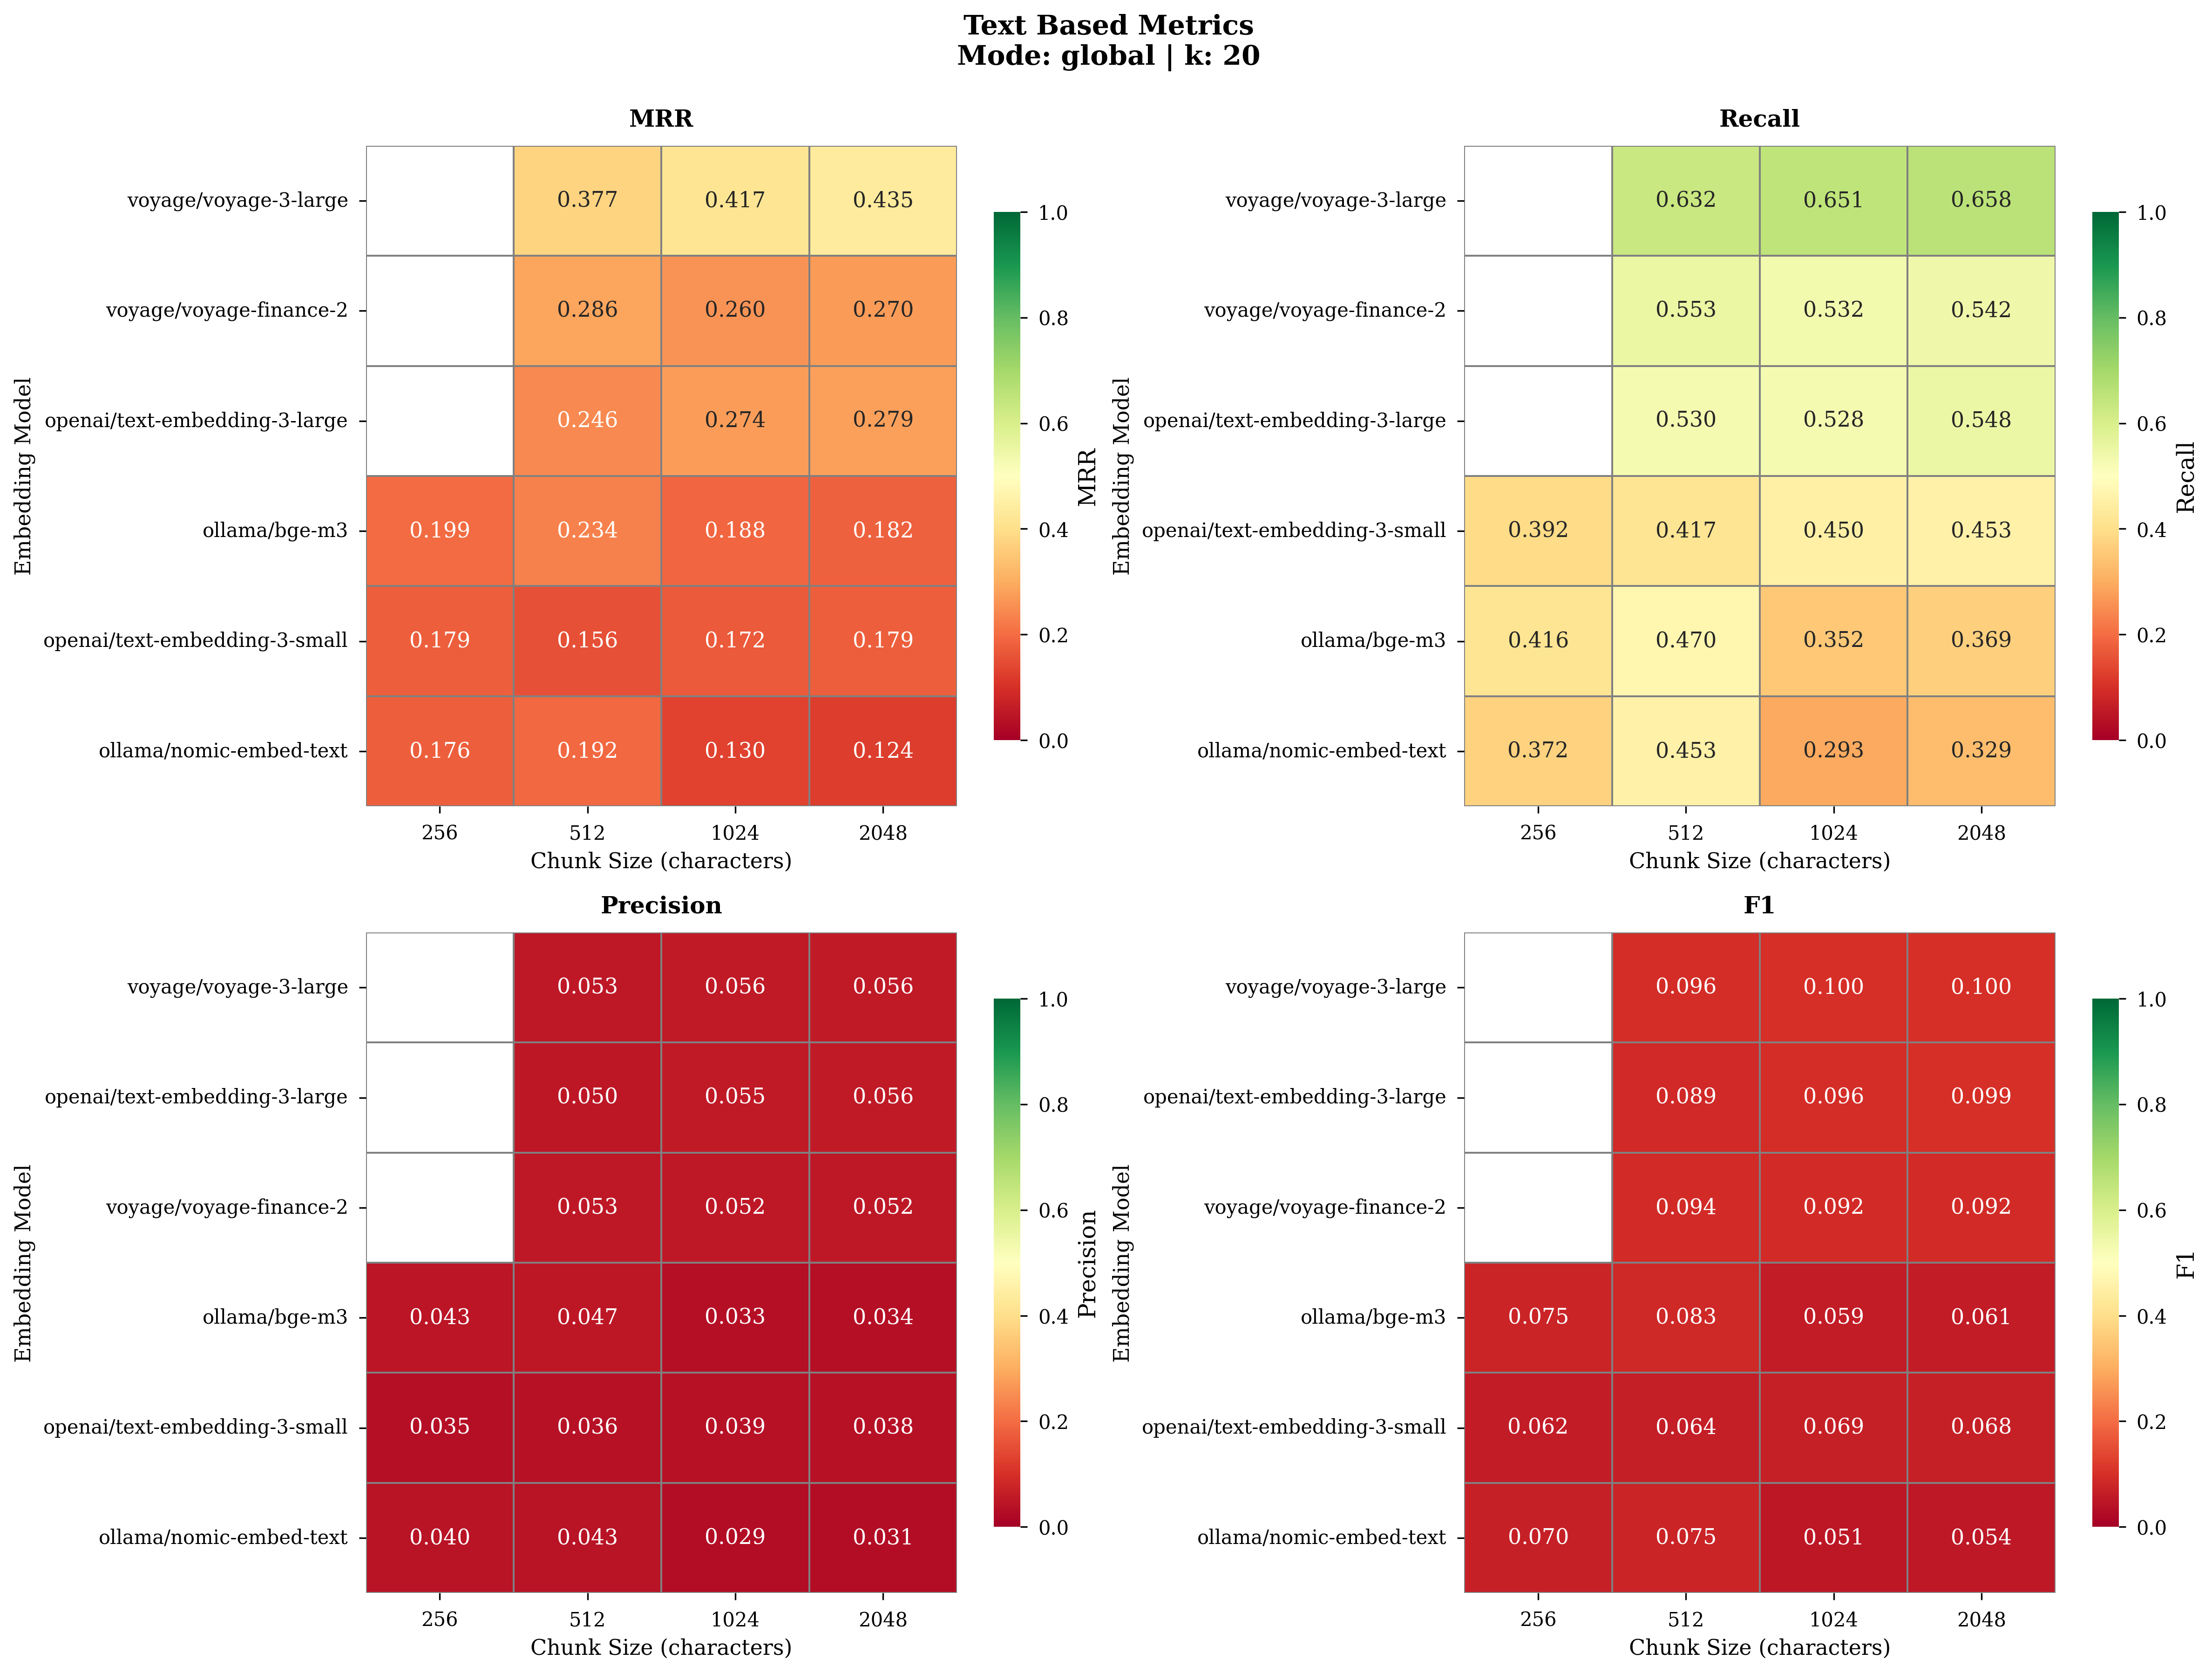

✓ Generated 1 heatmap figure(s)

📊 Generating text_based heatmaps...
   Filtered data: 21 configurations
  ✓ Saved: all_models_text_text_based_grid.png and all_models_text_text_based_grid.pdf


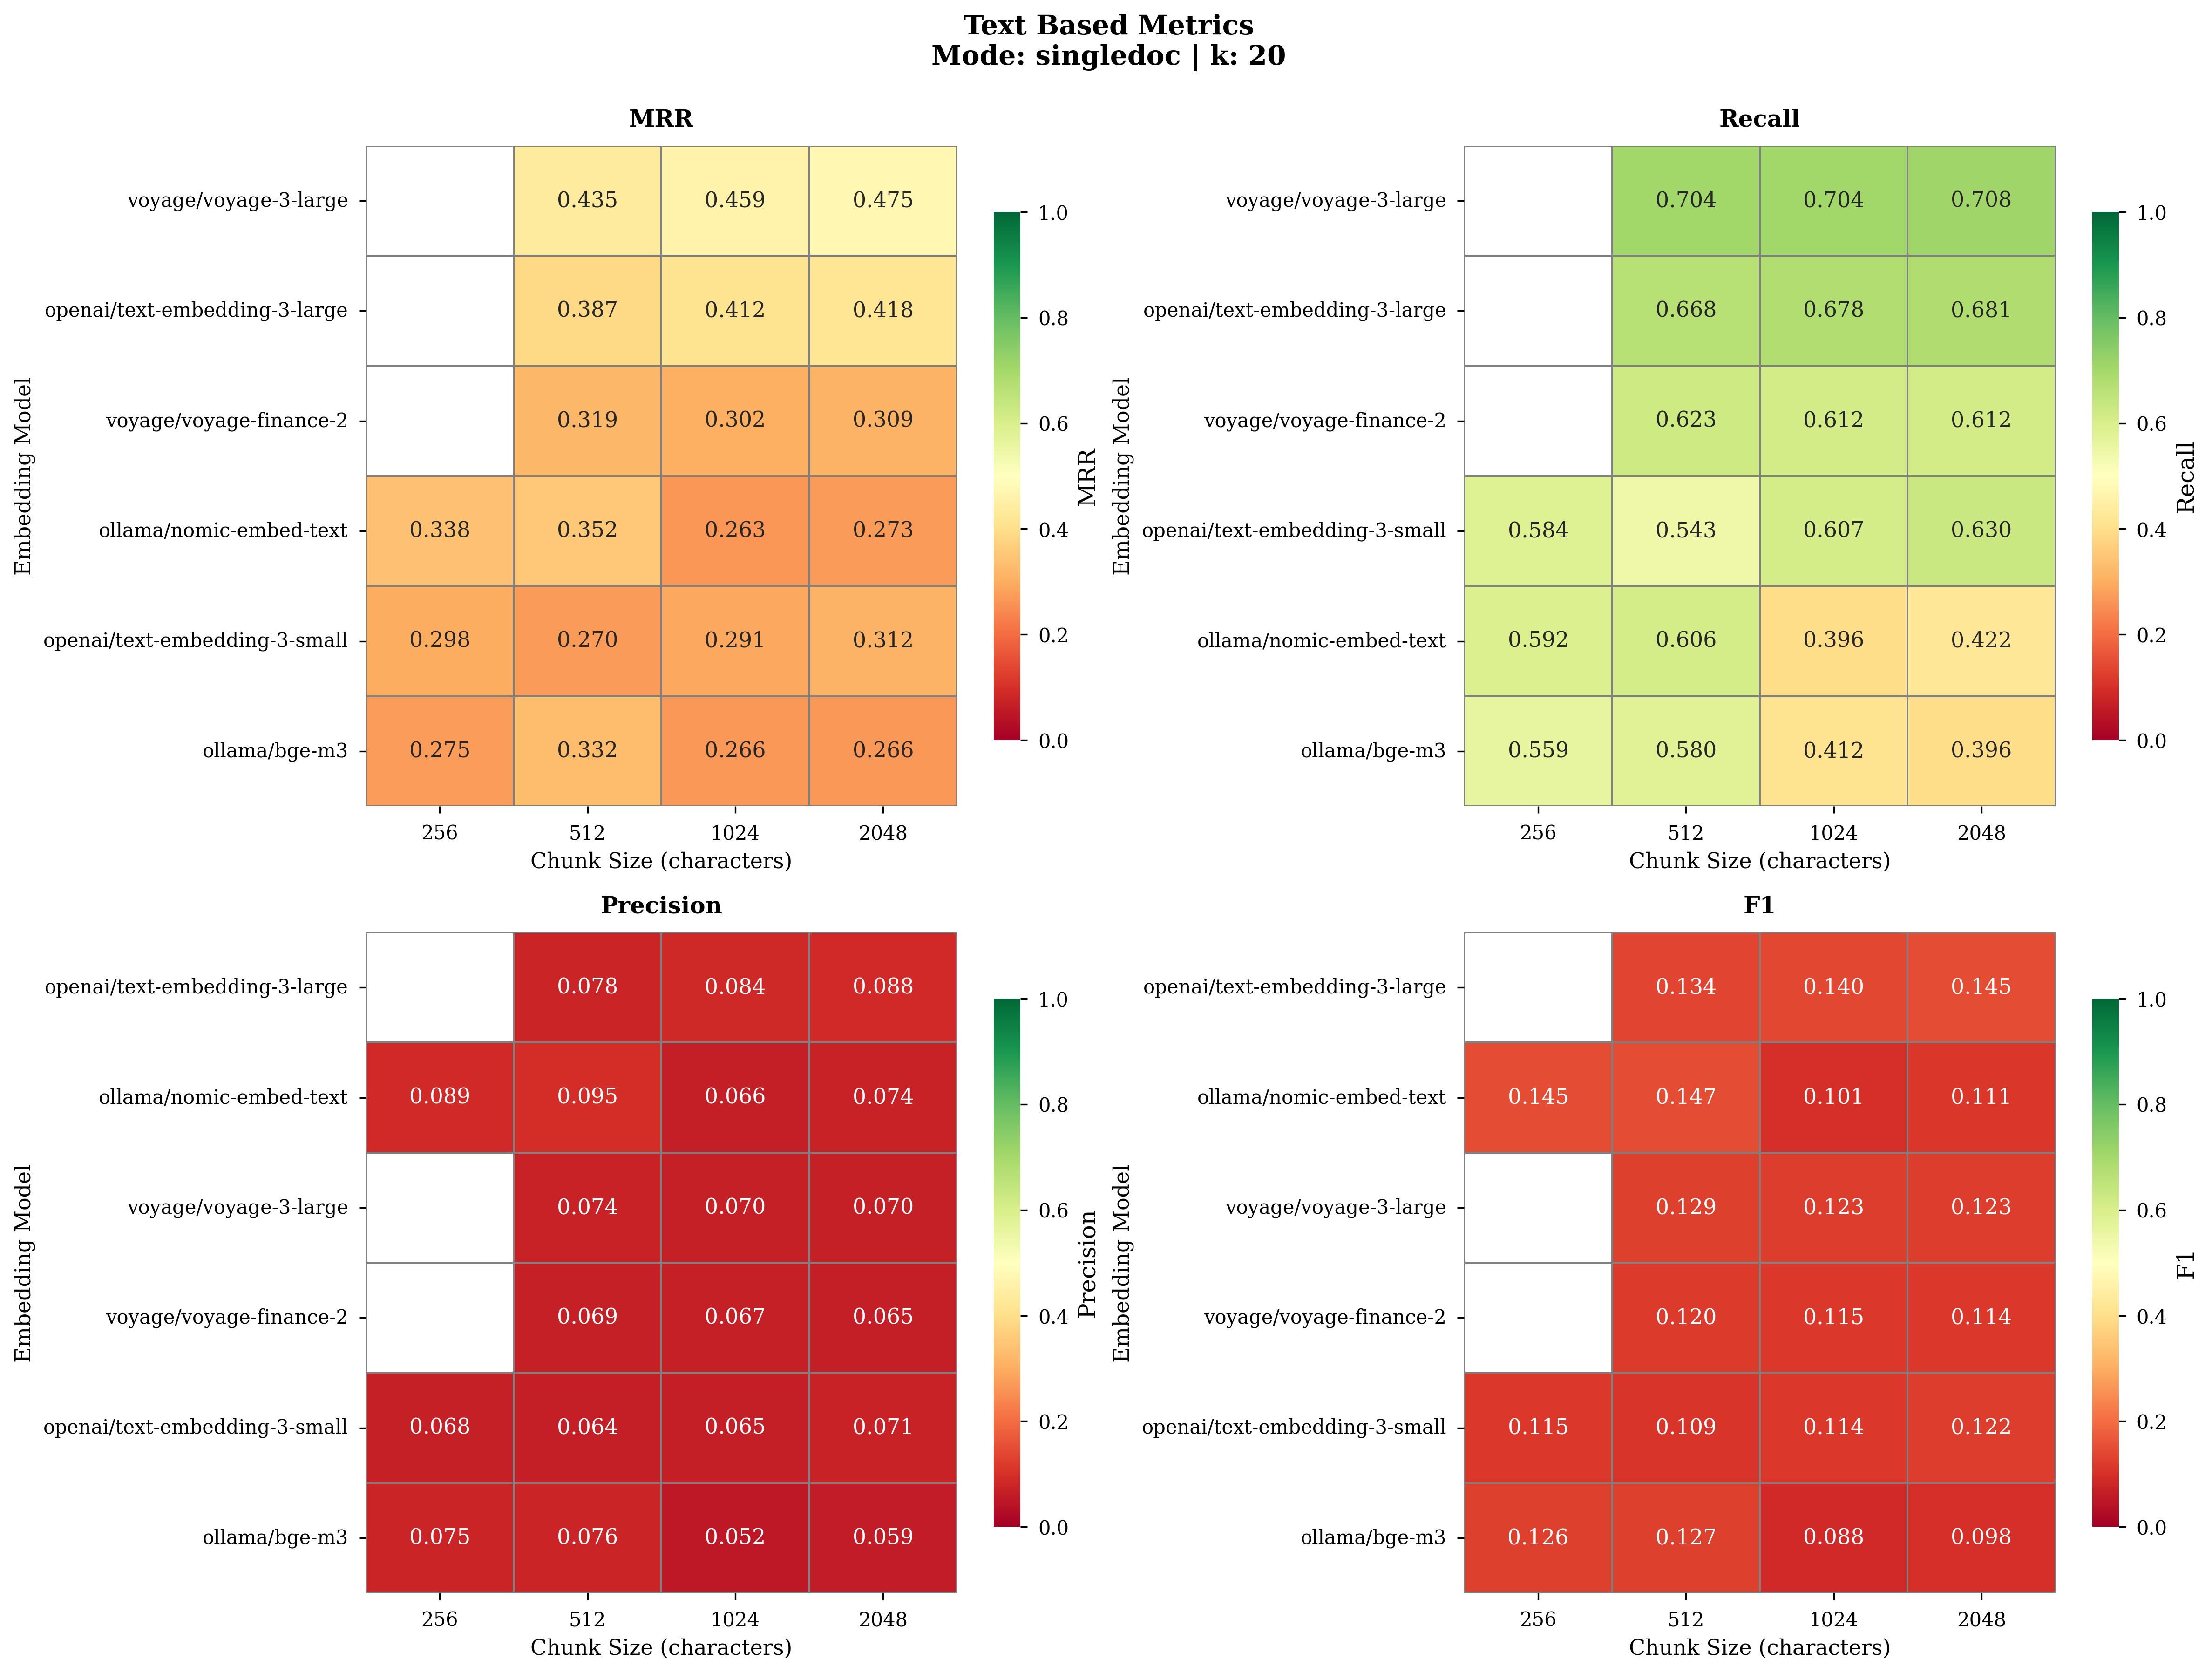

✓ Generated 1 heatmap figure(s)

📊 Generating page_based heatmaps...
   Filtered data: 21 configurations
  ✓ Saved: all_models_page_page_based_grid.png and all_models_page_page_based_grid.pdf


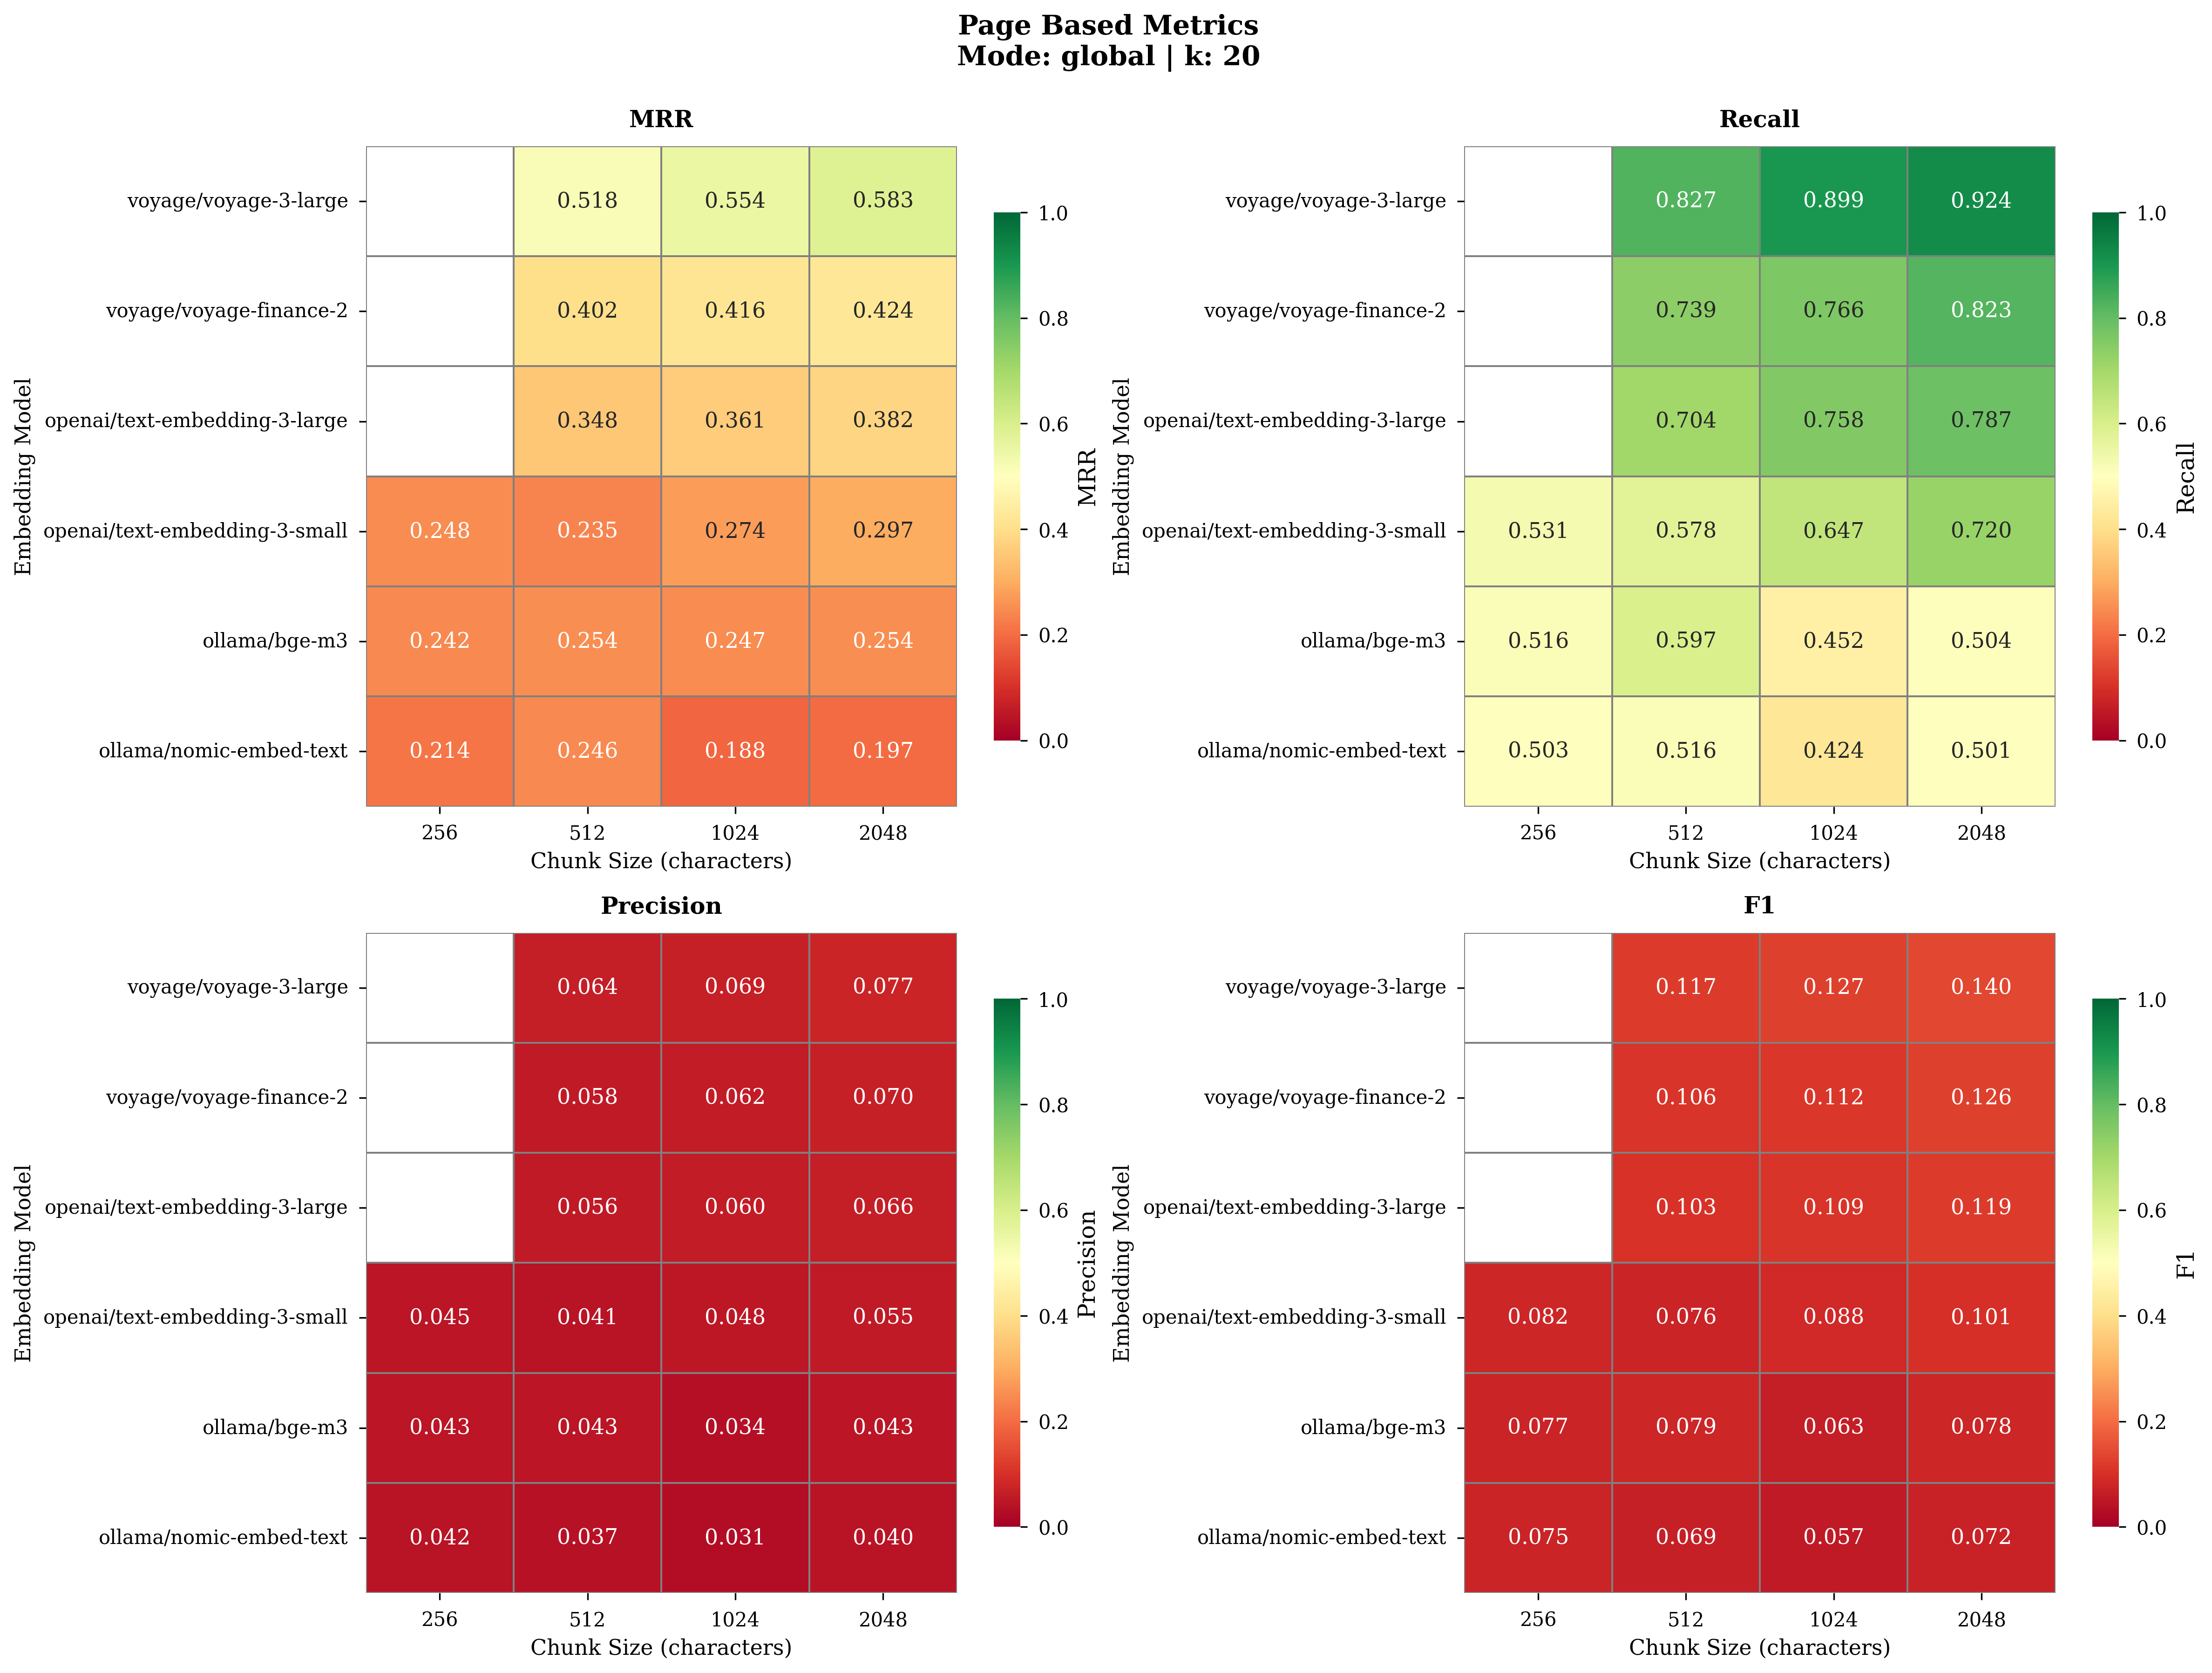

✓ Generated 1 heatmap figure(s)

📊 Generating page_based heatmaps...
   Filtered data: 21 configurations
  ✓ Saved: all_models_page_page_based_grid.png and all_models_page_page_based_grid.pdf


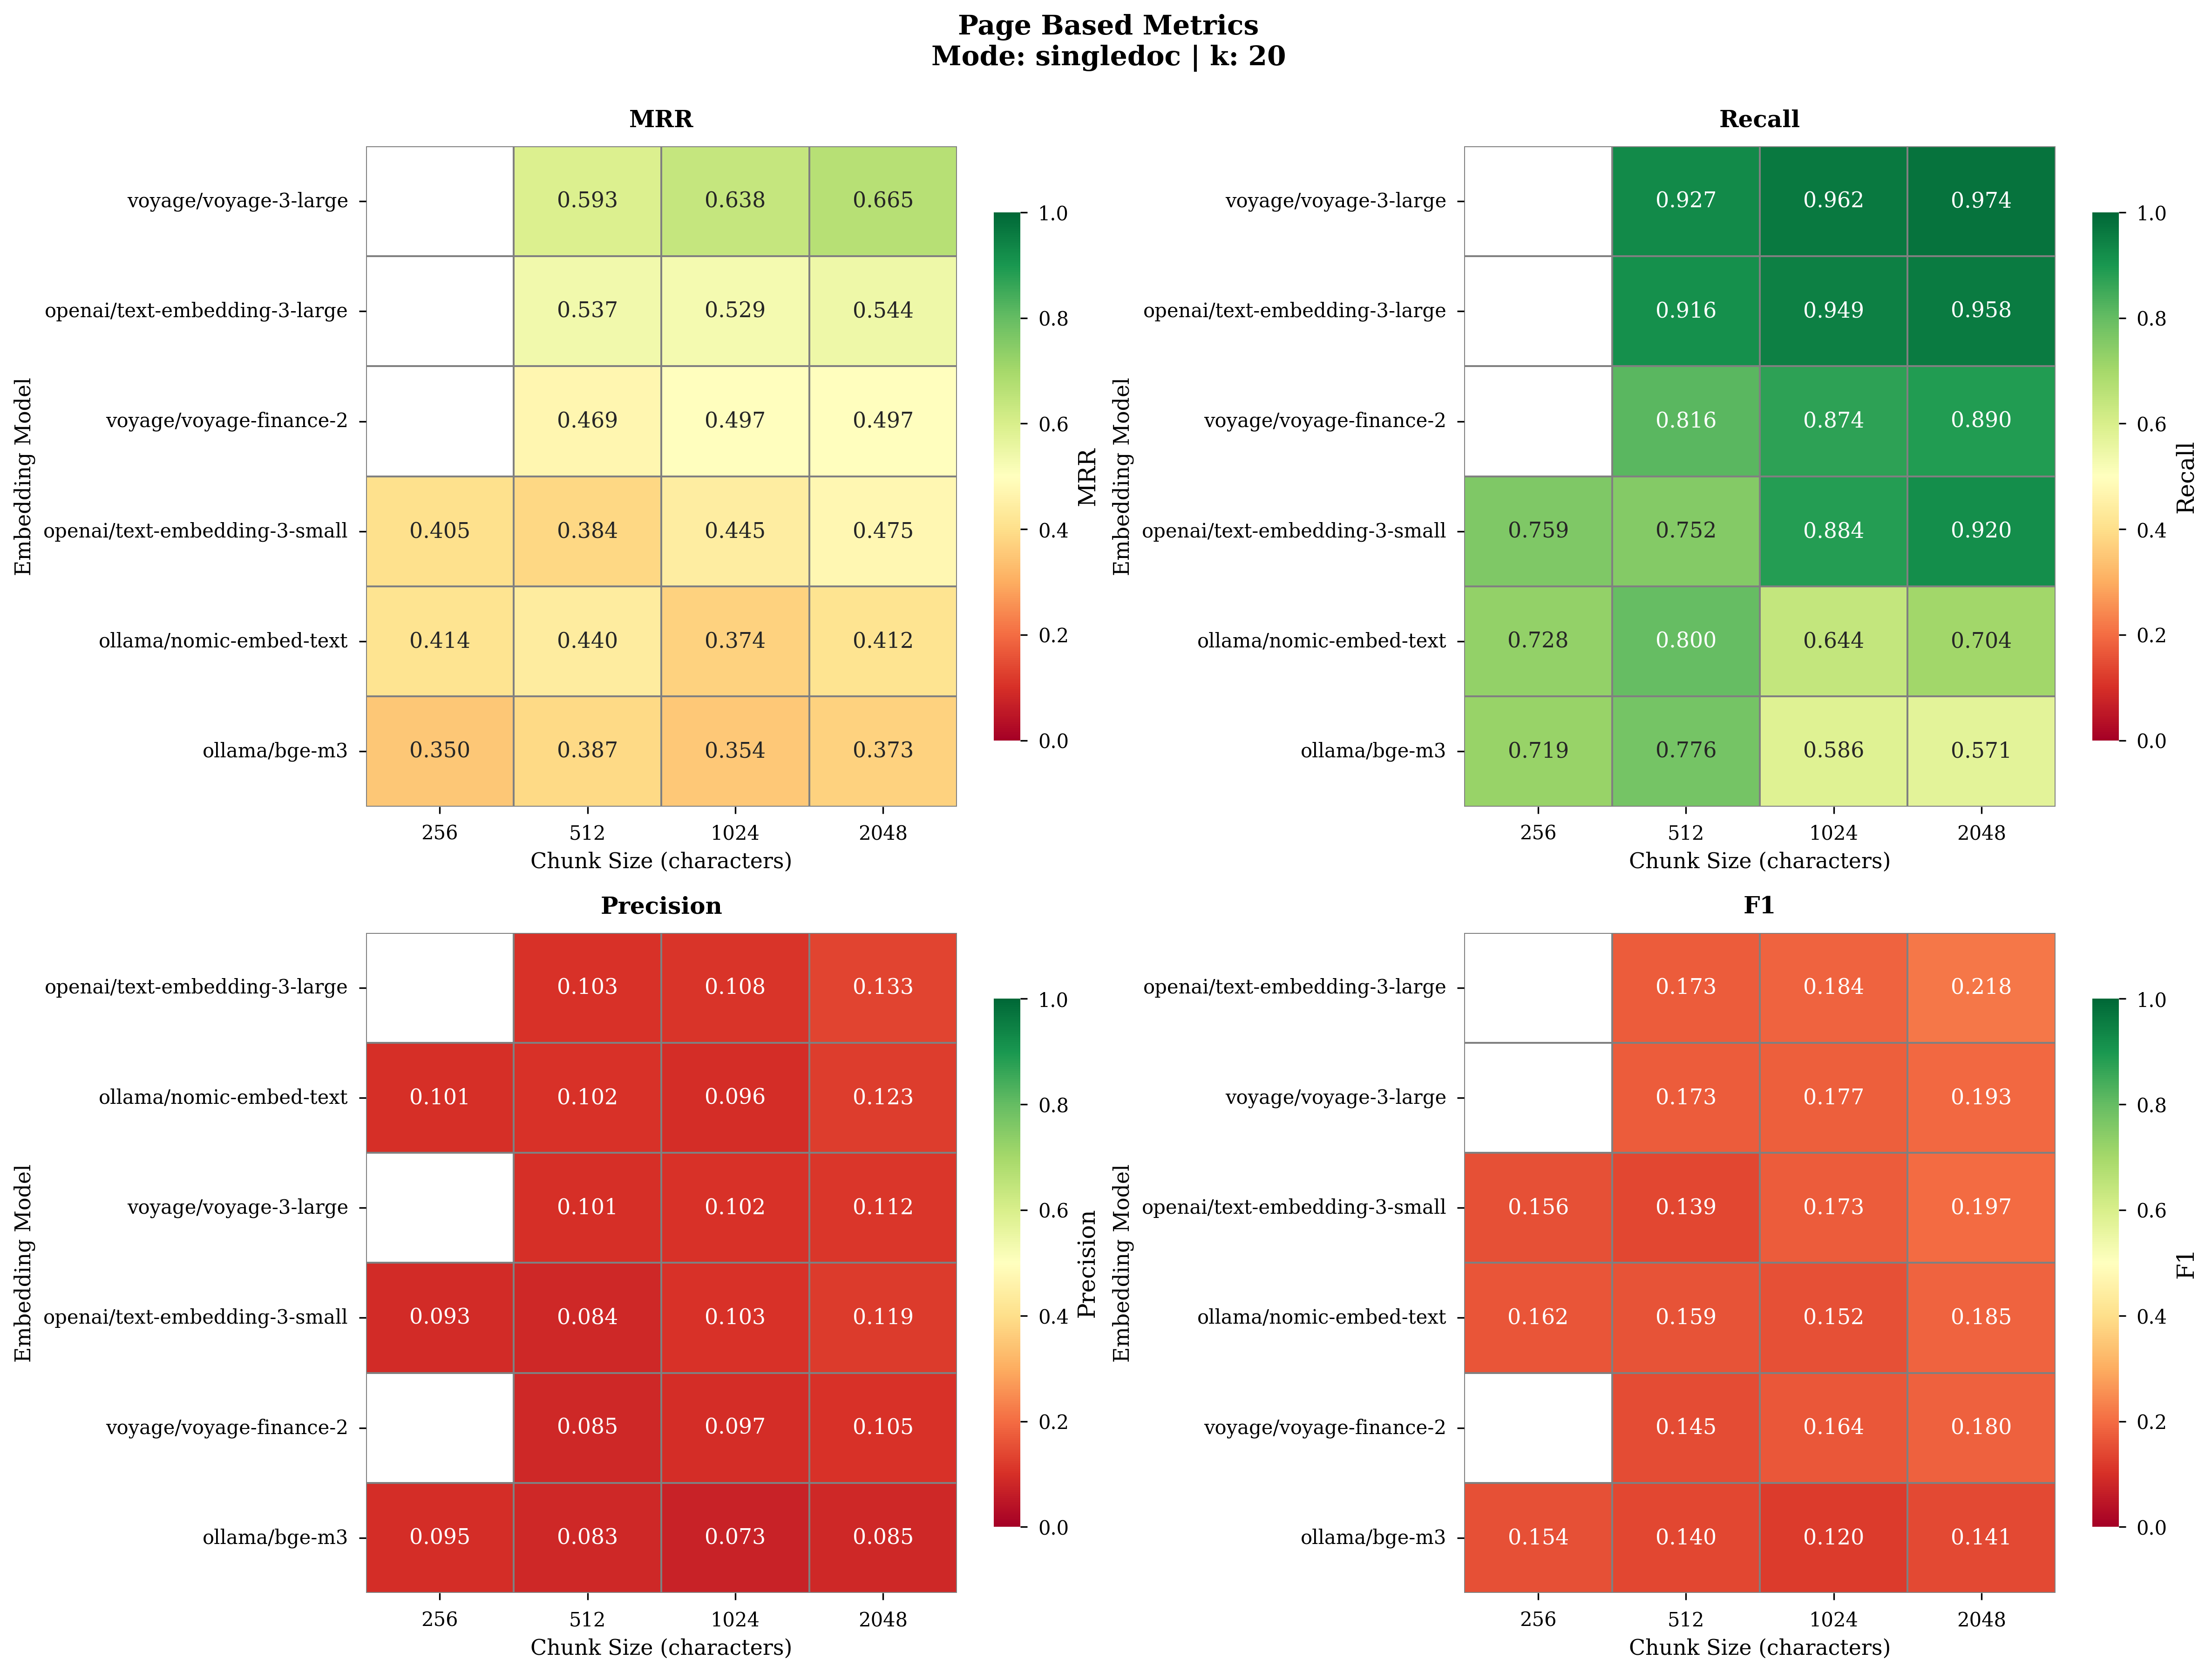

✓ Generated 1 heatmap figure(s)


[<Figure size 4800x3600 with 8 Axes>]

In [50]:
# ============================================================================
# Flexible Heatmap Plotting Functions for Retrieval Metrics
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Optional, List, Literal

def load_all_results(output_dir: str = OUTPUT_DIR) -> pd.DataFrame:
    """
    Load all JSON result files and create a consolidated DataFrame.
    
    Returns:
        DataFrame with all evaluation results
    """
    print("\n" + "="*60)
    print("LOADING ALL RESULTS")
    print("="*60)
    
    output_path = Path(output_dir)
    json_files = sorted(output_path.glob("*.json"))
    
    print(f"\nFound {len(json_files)} JSON files")
    
    all_data = []
    
    for filepath in tqdm(json_files, desc="Loading results"):
        try:
            with open(filepath, 'r') as f:
                results = json.load(f)
            
            # Extract summary (last item)
            if len(results) > 0 and 'summary' in results[-1]:
                summary = results[-1]['summary']
                
                # Create row for DataFrame
                row = {
                    'provider': summary['provider'],
                    'model': summary['model'],
                    'chunk_size': summary['chunk_size'],
                    'k': summary['k'],
                    'mode': summary['mode'],
                    'page_tolerance': summary.get('use_page_tolerance', True),
                    'text_threshold': summary.get('text_similarity_threshold', 0.7),
                    'total_queries': summary['total_queries'],
                    
                    # Text-based metrics (our focus)
                    'text_mrr': summary['average_text_mrr'],
                    'text_recall': summary['average_text_recall'],
                    'text_precision': summary['average_text_precision'],
                    'text_f1': summary['average_text_f1'],
                    
                    # Page-based metrics (for reference)
                    'page_mrr': summary['average_page_mrr'],
                    'page_recall': summary['average_page_recall'],
                    'page_precision': summary['average_page_precision'],
                    'page_f1': summary['average_page_f1'],
                    
                    'filename': filepath.name
                }
                
                all_data.append(row)
        
        except Exception as e:
            print(f"\n✗ Error loading {filepath.name}: {e}")
    
    # Create DataFrame
    df = pd.DataFrame(all_data)
    
    print(f"\n✓ Loaded {len(df)} result configurations")
    
    if len(df) > 0:
        print(f"\nProviders: {df['provider'].unique()}")
        print(f"Models: {df['model'].unique()}")
        print(f"Chunk sizes: {sorted(df['chunk_size'].unique())}")
        print(f"Modes: {df['mode'].unique()}")
    
    return df

def plot_metric_heatmaps(
    df: pd.DataFrame,
    metric_type: Literal['page_based', 'text_based'] = 'text_based',
    provider: Optional[str] = None,
    model: Optional[str] = None,
    mode: Optional[str] = None,
    k: Optional[int] = None,
    display_mode: Literal['separate', 'grid'] = 'grid',
    output_dir: Optional[str] = None,
    save_prefix: str = 'heatmap'
):
    """
    Create heatmaps for retrieval metrics (MRR, Recall, Precision, F1).
    
    Args:
        df: Results DataFrame with all evaluation data
        metric_type: 'page_based' or 'text_based' metrics
        provider: Filter by provider (e.g., 'openai', 'cohere'). None = all providers
        model: Filter by model name. None = all models
        mode: Filter by mode ('global' or 'singledoc'). None = all modes
        k: Filter by k value. None = all k values
        display_mode: 'separate' (4 individual plots) or 'grid' (2x2 subplot)
        output_dir: Directory to save figures. None = don't save
        save_prefix: Prefix for saved filenames
    
    Returns:
        List of figure objects
    """
    
    # Filter data based on parameters
    df_filtered = df.copy()
    
    if provider is not None:
        df_filtered = df_filtered[df_filtered['provider'] == provider]
    if model is not None:
        df_filtered = df_filtered[df_filtered['model'] == model]
    if mode is not None:
        df_filtered = df_filtered[df_filtered['mode'] == mode]
    if k is not None:
        df_filtered = df_filtered[df_filtered['k'] == k]
    
    if len(df_filtered) == 0:
        print("⚠ No data matching the specified filters!")
        return []
    
    print(f"\n📊 Generating {metric_type} heatmaps...")
    print(f"   Filtered data: {len(df_filtered)} configurations")
    
    # Define metric columns based on type
    metric_prefix = metric_type.split('_')[0]  # 'page' or 'text'
    metrics = {
        'MRR': f'{metric_prefix}_mrr',
        'Recall': f'{metric_prefix}_recall',
        'Precision': f'{metric_prefix}_precision',
        'F1': f'{metric_prefix}_f1'
    }
    
    # Create model labels
    df_filtered['model_label'] = df_filtered.apply(
        lambda x: f"{x['provider']}/{x['model']}", axis=1
    )
    
    # Create pivot tables for each metric
    pivot_tables = {}
    for metric_name, metric_col in metrics.items():
        pivot_tables[metric_name] = df_filtered.pivot_table(
            values=metric_col,
            index='model_label',
            columns='chunk_size',
            aggfunc='mean'
        )
        # Sort by average performance
        pivot_tables[metric_name]['avg'] = pivot_tables[metric_name].mean(axis=1)
        pivot_tables[metric_name] = pivot_tables[metric_name].sort_values('avg', ascending=False)
        pivot_tables[metric_name] = pivot_tables[metric_name].drop('avg', axis=1)
    
    # Generate title suffix based on filters
    title_parts = []
    if provider:
        title_parts.append(f"Provider: {provider}")
    if model:
        title_parts.append(f"Model: {model}")
    if mode:
        title_parts.append(f"Mode: {mode}")
    if k:
        title_parts.append(f"k: {k}")
    
    title_suffix = " | ".join(title_parts) if title_parts else "All Configurations"
    main_title = f"{metric_type.replace('_', ' ').title()} Metrics\n{title_suffix}"
    
    figures = []
    
    if display_mode == 'grid':
        # Create 2x2 grid
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()
        
        for idx, (metric_name, pivot_data) in enumerate(pivot_tables.items()):
            ax = axes[idx]
            
            # Create heatmap
            sns.heatmap(
                pivot_data,
                annot=True,
                fmt='.3f',
                cmap='RdYlGn',
                vmin=0,
                vmax=1.0,
                cbar_kws={'label': metric_name, 'shrink': 0.8},
                linewidths=0.5,
                linecolor='gray',
                ax=ax
            )
            
            # Formatting
            ax.set_xlabel('Chunk Size (characters)', fontsize=11)
            ax.set_ylabel('Embedding Model', fontsize=11)
            ax.set_title(metric_name, fontsize=12, fontweight='bold', pad=10)
            ax.tick_params(axis='x', rotation=0)
            ax.tick_params(axis='y', rotation=0)
        
        fig.suptitle(main_title, fontsize=14, fontweight='bold', y=0.995)
        plt.tight_layout()
        
        # Save if output_dir provided
        if output_dir:
            filename = f"{save_prefix}_{metric_type}_grid"
            save_figure(fig, filename, output_dir)
        
        figures.append(fig)
        plt.show()
    
    else:  # separate plots
        for metric_name, pivot_data in pivot_tables.items():
            fig, ax = plt.subplots(figsize=(10, max(6, len(pivot_data) * 0.6)))
            
            # Create heatmap
            sns.heatmap(
                pivot_data,
                annot=True,
                fmt='.3f',
                cmap='RdYlGn',
                vmin=0,
                vmax=1.0,
                cbar_kws={'label': metric_name, 'shrink': 0.8},
                linewidths=0.5,
                linecolor='gray',
                ax=ax
            )
            
            # Formatting
            ax.set_xlabel('Chunk Size (characters)', fontsize=12)
            ax.set_ylabel('Embedding Model', fontsize=12)
            ax.set_title(f'{metric_name}: {main_title}', 
                        fontsize=13, fontweight='bold', pad=15)
            ax.tick_params(axis='x', rotation=0)
            ax.tick_params(axis='y', rotation=0)
            
            plt.tight_layout()
            
            # Save if output_dir provided
            if output_dir:
                filename = f"{save_prefix}_{metric_type}_{metric_name.lower()}"
                save_figure(fig, filename, output_dir)
            
            figures.append(fig)
            plt.show()
    
    print(f"✓ Generated {len(figures)} heatmap figure(s)")
    return figures


def save_figure(fig, filename: str, output_dir: str):
    """
    Save figure in multiple formats for thesis use.
    
    Args:
        fig: Matplotlib figure
        filename: Base filename (without extension)
        output_dir: Output directory
    """
    from pathlib import Path
    import os
    
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Save as PNG (for preview)
    png_path = output_path / f"{filename}.png"
    fig.savefig(png_path, dpi=300, bbox_inches='tight', facecolor='white')
    
    # Save as PDF (for thesis - vector format)
    pdf_path = output_path / f"{filename}.pdf"
    fig.savefig(pdf_path, bbox_inches='tight', facecolor='white')
    
    print(f"  ✓ Saved: {filename}.png and {filename}.pdf")


# ============================================================================
# Example Usage
# ============================================================================

# Load your data first (you already have this)
df_results = load_all_results(OUTPUT_DIR)

FIGURES_OUTPUT_DIR = os.path.join(OUTPUT_DIR, "figures")

# Example 1: All models, text-based, 2x2 grid
plot_metric_heatmaps(
    df_results,
    metric_type='text_based',
    k=20,
    mode='global',
    display_mode='grid',
    output_dir=FIGURES_OUTPUT_DIR,
    save_prefix='all_models_text'
)

# Example 2: All models, text-based, 2x2 grid
plot_metric_heatmaps(
    df_results,
    metric_type='text_based',
    k=20,
    mode='singledoc',
    display_mode='grid',
    output_dir=FIGURES_OUTPUT_DIR,
    save_prefix='all_models_text'
)

plot_metric_heatmaps(
    df_results,
    metric_type='page_based',
    k=20,
    mode='global',
    display_mode='grid',
    output_dir=FIGURES_OUTPUT_DIR,
    save_prefix='all_models_page'
)

plot_metric_heatmaps(
    df_results,
    metric_type='page_based',
    k=20,
    mode='singledoc',
    display_mode='grid',
    output_dir=FIGURES_OUTPUT_DIR,
    save_prefix='all_models_page'
)

# # Example 2: OpenAI only, page-based, separate plots
# plot_metric_heatmaps(
#     df_results,
#     metric_type='page_based',
#     provider='openai',
#     mode='global',
#     display_mode='separate',
#     output_dir=FIGURES_OUTPUT_DIR,
#     save_prefix='openai_page'
# )

# # Example 3: Specific model comparison
# plot_metric_heatmaps(
#     df_results,
#     metric_type='text_based',
#     provider='openai',
#     model='text-embedding-3-small',
#     display_mode='grid'
# )


LOADING ALL RESULTS

Found 42 JSON files


Loading results:   0%|          | 0/42 [00:00<?, ?it/s]


✓ Loaded 42 result configurations

Providers: ['ollama' 'openai' 'voyage']
Models: ['bge-m3' 'nomic-embed-text' 'text-embedding-3-large'
 'text-embedding-3-small' 'voyage-3-large' 'voyage-finance-2']
Chunk sizes: [np.int64(256), np.int64(512), np.int64(1024), np.int64(2048)]
Modes: ['global' 'singledoc']

📊 Generating mode comparison charts (text_based)...
   Filtered data: 12 configurations
   Modes found: ['global', 'singledoc']
  ✓ Saved: chunk512_mode_comp_text_based_grid.png and chunk512_mode_comp_text_based_grid.pdf


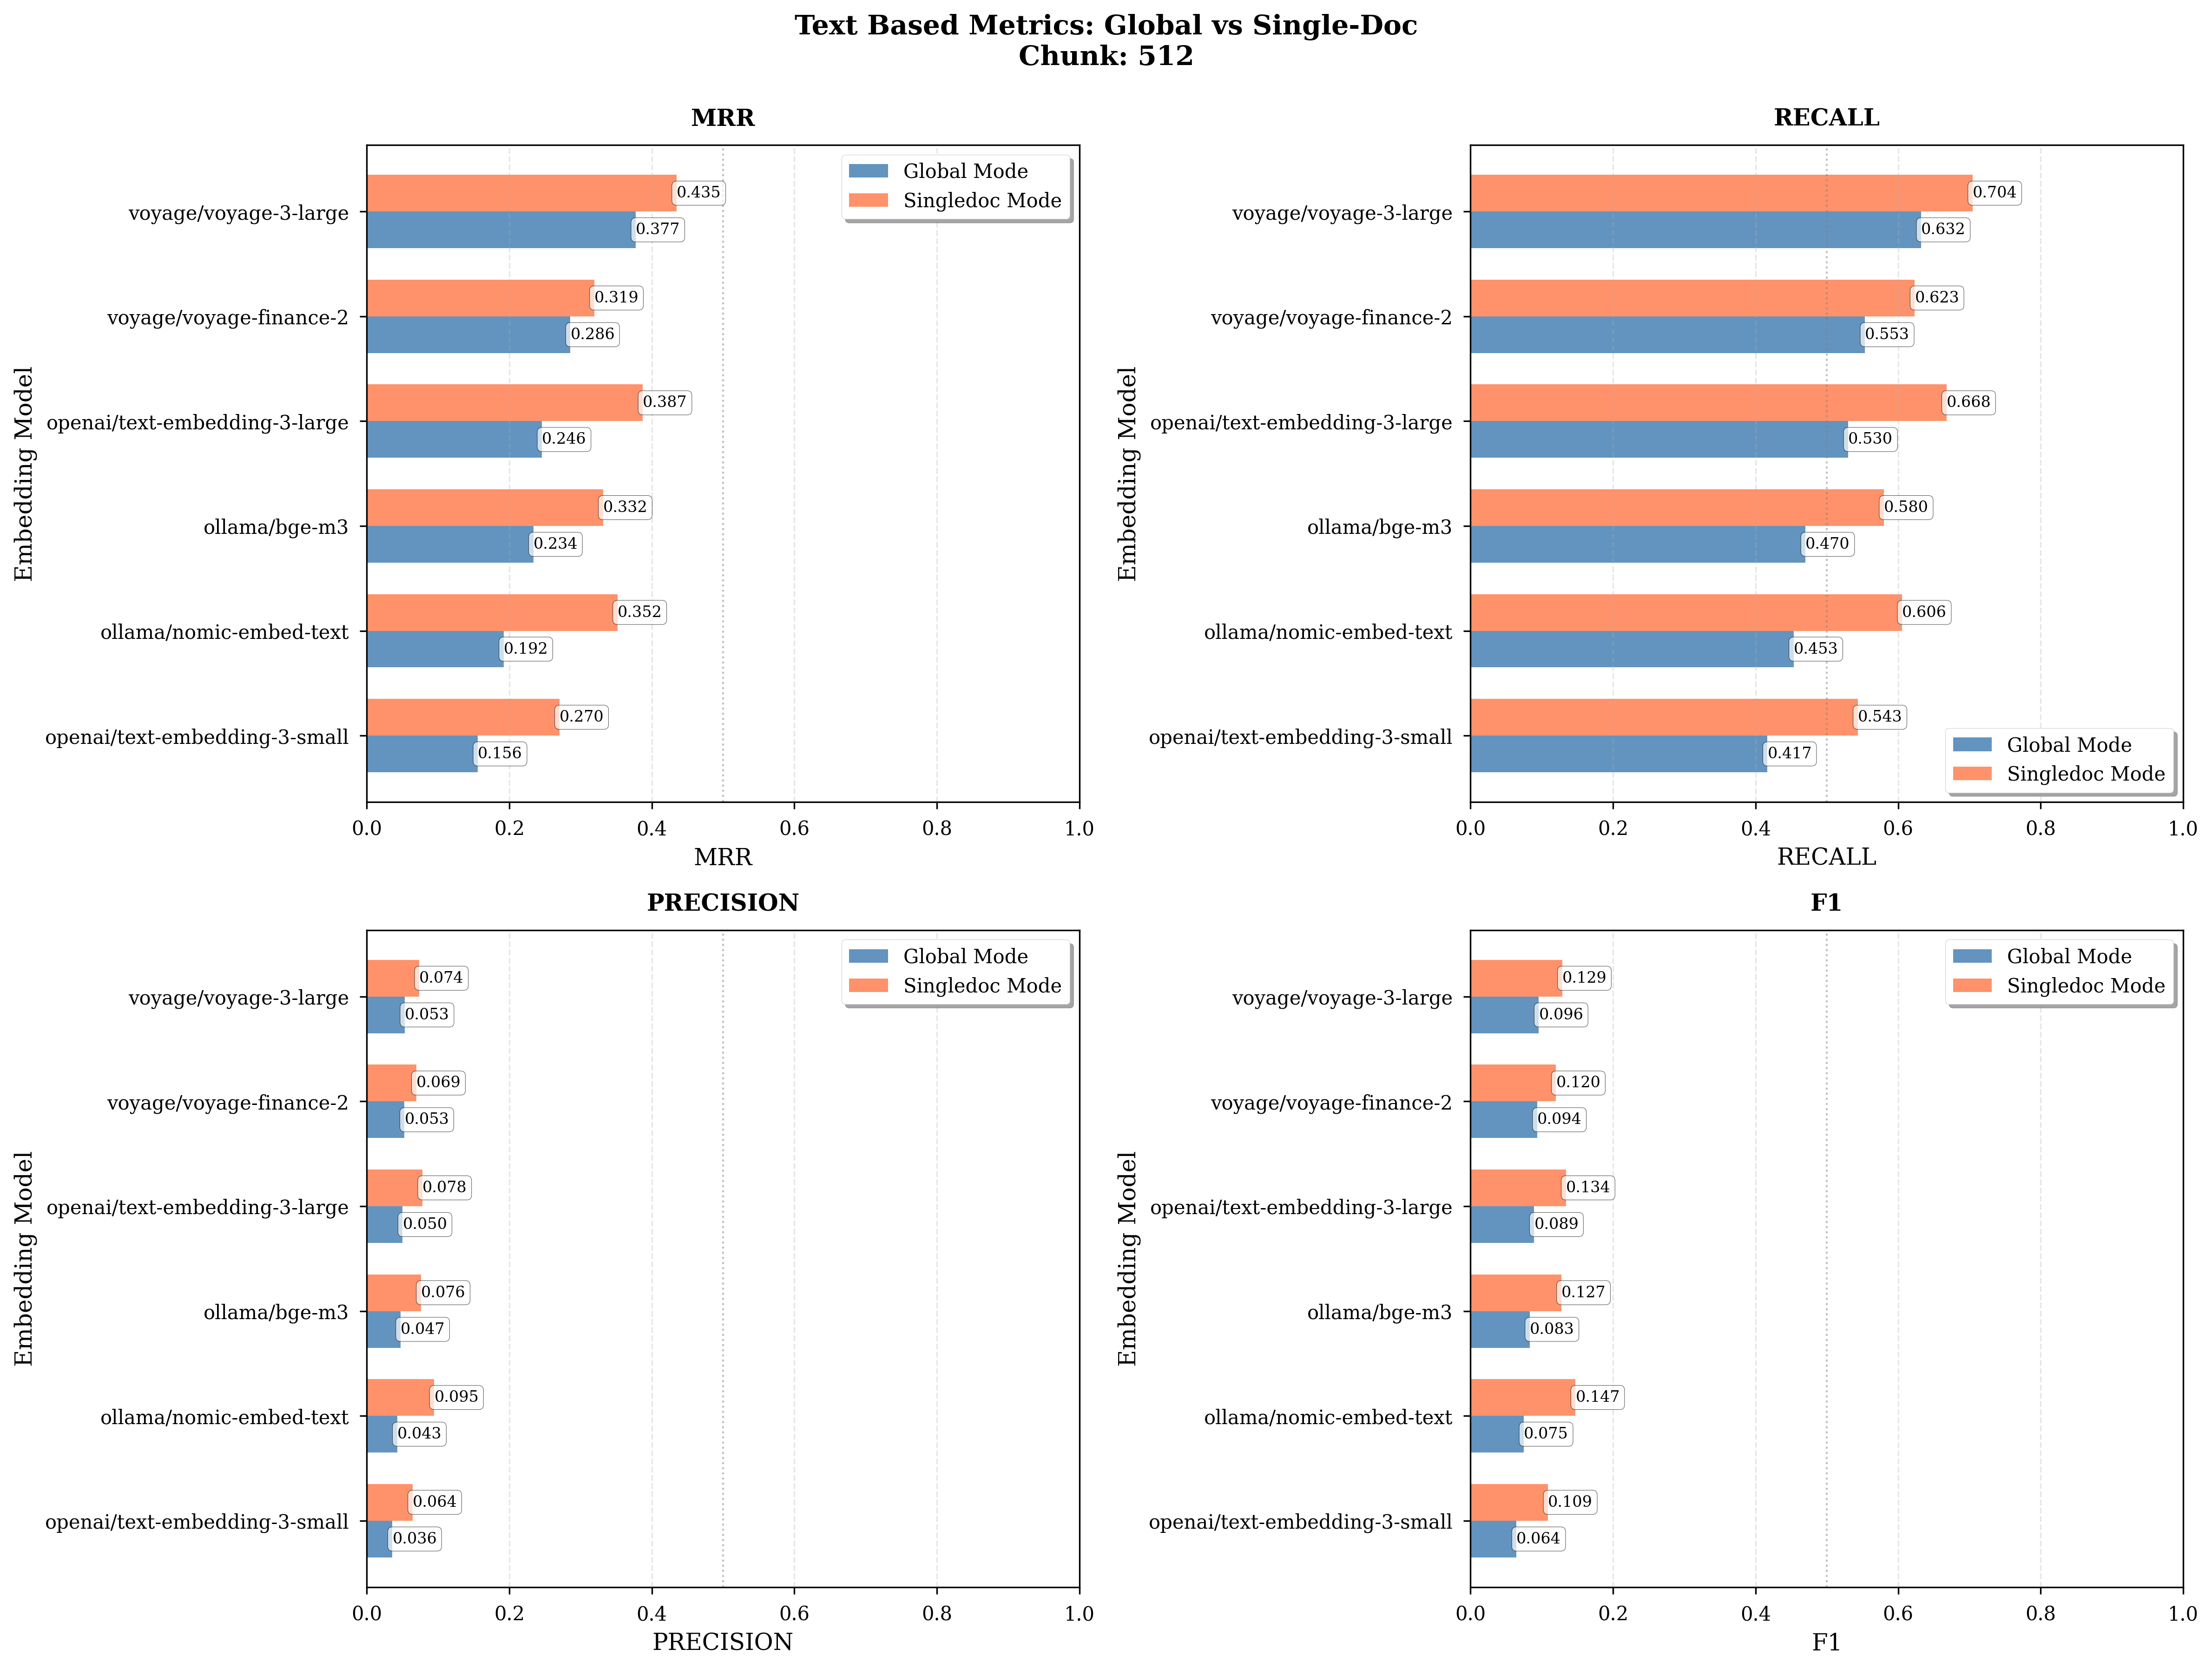

✓ Generated 1 comparison figure(s)

📊 Generating mode comparison charts (page_based)...
   Filtered data: 12 configurations
   Modes found: ['global', 'singledoc']
  ✓ Saved: chunk512_mode_comp_page_based_grid.png and chunk512_mode_comp_page_based_grid.pdf


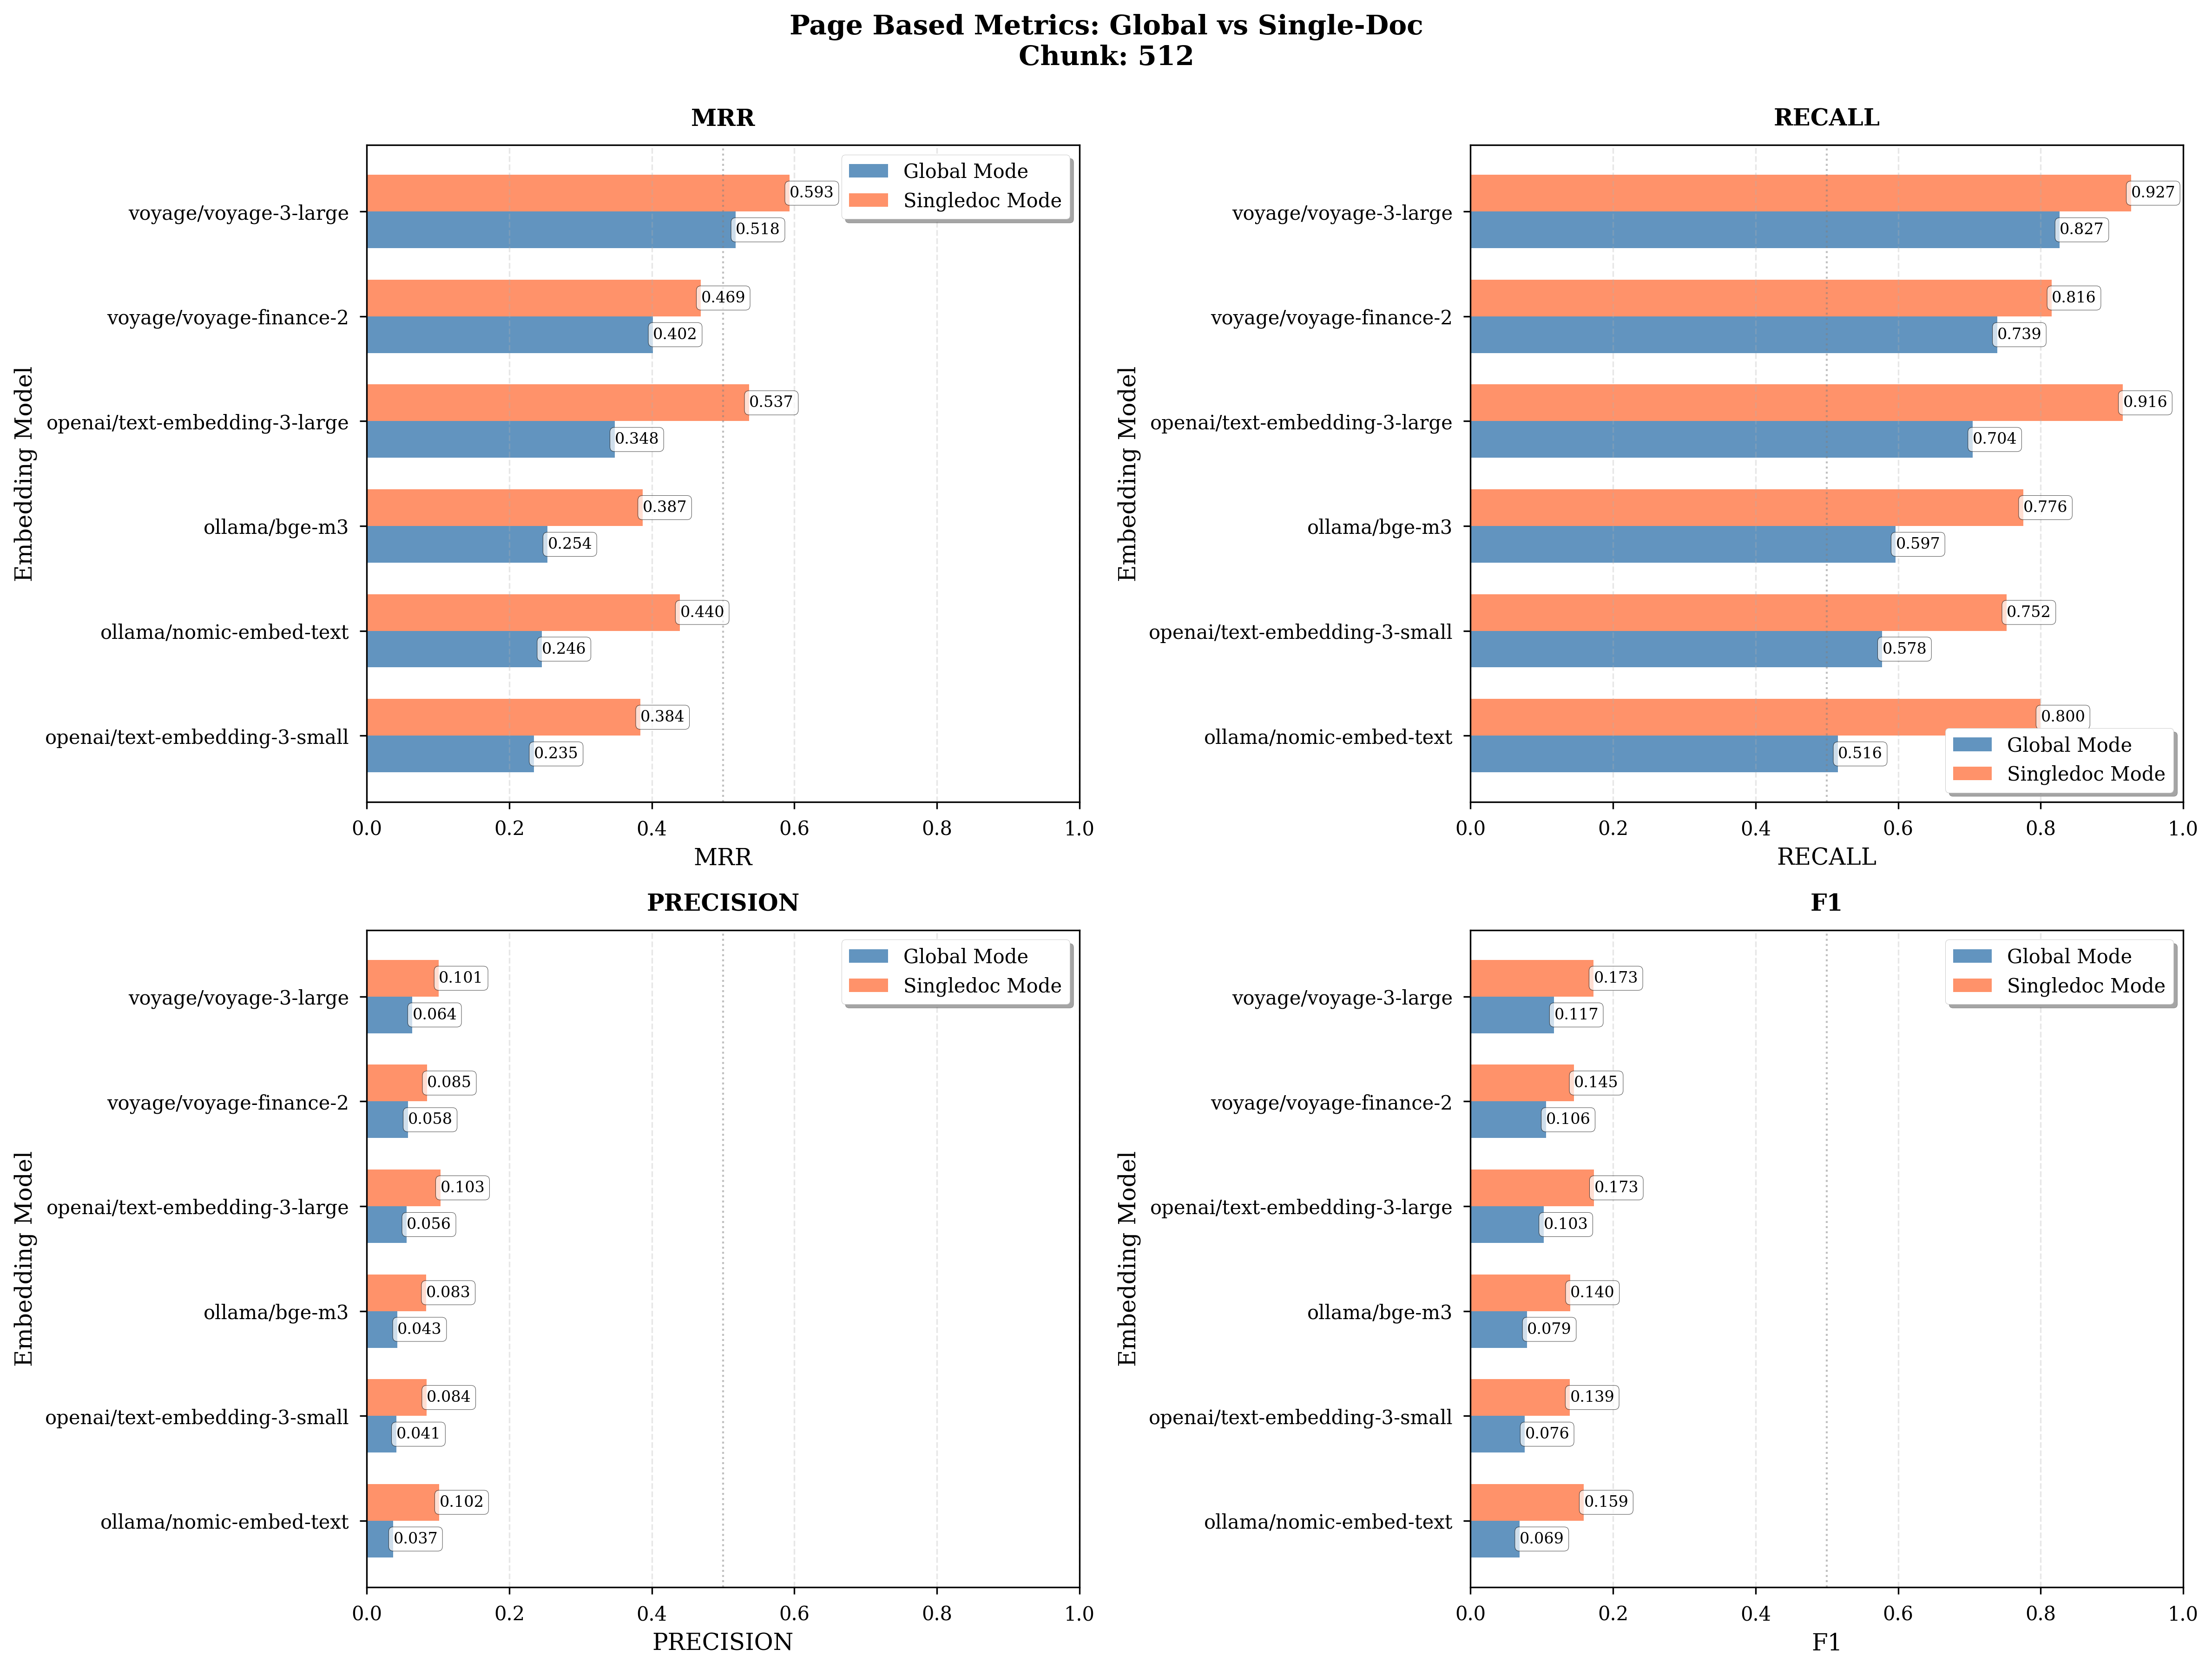

✓ Generated 1 comparison figure(s)
Import this module and call plot_mode_comparison() with your data!


In [51]:
# ============================================================================
# Mode Comparison Bar Charts (Global vs SingleDoc)
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Optional, List, Literal

def plot_mode_comparison(
    df: pd.DataFrame,
    metric_type: Literal['page_based', 'text_based'] = 'text_based',
    metrics: Optional[List[str]] = None,
    provider: Optional[str] = None,
    model: Optional[str] = None,
    chunk_size: Optional[int] = None,
    k: Optional[int] = None,
    display_mode: Literal['separate', 'grid'] = 'grid',
    orientation: Literal['horizontal', 'vertical'] = 'horizontal',
    output_dir: Optional[str] = None,
    save_prefix: str = 'mode_comparison'
):
    """
    Create bar charts comparing global vs singledoc modes.
    
    Args:
        df: Results DataFrame with all evaluation data
        metric_type: 'page_based' or 'text_based' metrics
        metrics: List of metrics to plot. None = all 4 metrics ['mrr', 'recall', 'precision', 'f1']
        provider: Filter by provider. None = all providers
        model: Filter by model name. None = all models
        chunk_size: Filter by chunk_size. None = all chunk sizes (averaged)
        k: Filter by k value. None = all k values
        display_mode: 'separate' (individual plots) or 'grid' (2x2 subplot for 4 metrics)
        orientation: 'horizontal' or 'vertical' bars
        output_dir: Directory to save figures. None = don't save
        save_prefix: Prefix for saved filenames
    
    Returns:
        List of figure objects
    """
    
    # Filter data based on parameters
    df_filtered = df.copy()
    
    if provider is not None:
        df_filtered = df_filtered[df_filtered['provider'] == provider]
    if model is not None:
        df_filtered = df_filtered[df_filtered['model'] == model]
    if chunk_size is not None:
        df_filtered = df_filtered[df_filtered['chunk_size'] == chunk_size]
    if k is not None:
        df_filtered = df_filtered[df_filtered['k'] == k]
    
    if len(df_filtered) == 0:
        print("⚠ No data matching the specified filters!")
        return []
    
    # Check if both modes are present
    modes_present = df_filtered['mode'].unique()
    if len(modes_present) < 2:
        print(f"⚠ Warning: Only {modes_present} mode(s) found in filtered data.")
        print("   Mode comparison requires both 'global' and 'singledoc' modes.")
    
    print(f"\n📊 Generating mode comparison charts ({metric_type})...")
    print(f"   Filtered data: {len(df_filtered)} configurations")
    print(f"   Modes found: {list(modes_present)}")
    
    # Define metric columns based on type
    metric_prefix = metric_type.split('_')[0]  # 'page' or 'text'
    
    if metrics is None:
        metrics = ['mrr', 'recall', 'precision', 'f1']
    
    metric_cols = {
        metric.upper(): f'{metric_prefix}_{metric.lower()}'
        for metric in metrics
    }
    
    # Create model labels
    df_filtered['model_label'] = df_filtered.apply(
        lambda x: f"{x['provider']}/{x['model']}", axis=1
    )
    
    # Aggregate data: group by model and mode, average across chunk_sizes (if not filtered)
    agg_data = {}
    for metric_name, metric_col in metric_cols.items():
        mode_comparison = df_filtered.groupby(['model_label', 'mode'])[metric_col].mean().reset_index()
        mode_pivot = mode_comparison.pivot(index='model_label', columns='mode', values=metric_col)
        agg_data[metric_name] = mode_pivot
    
    # Generate title suffix based on filters
    title_parts = []
    if provider:
        title_parts.append(f"Provider: {provider}")
    if model:
        title_parts.append(f"Model: {model}")
    if chunk_size:
        title_parts.append(f"Chunk: {chunk_size}")
    if k:
        title_parts.append(f"k: {k}")
    
    if not title_parts and chunk_size is None:
        title_parts.append("Averaged across all chunk sizes")
    
    title_suffix = " | ".join(title_parts) if title_parts else "All Configurations"
    
    figures = []
    
    if display_mode == 'grid' and len(metrics) == 4:
        # Create 2x2 grid
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()
        
        for idx, (metric_name, mode_pivot) in enumerate(agg_data.items()):
            ax = axes[idx]
            _plot_single_comparison(
                mode_pivot, 
                metric_name, 
                orientation, 
                ax=ax,
                show_title=True
            )
        
        main_title = f"{metric_type.replace('_', ' ').title()} Metrics: Global vs Single-Doc\n{title_suffix}"
        fig.suptitle(main_title, fontsize=14, fontweight='bold', y=0.995)
        plt.tight_layout()
        
        # Save if output_dir provided
        if output_dir:
            filename = f"{save_prefix}_{metric_type}_grid"
            save_figure(fig, filename, output_dir)
        
        figures.append(fig)
        plt.show()
    
    else:  # separate plots
        for metric_name, mode_pivot in agg_data.items():
            fig, ax = plt.subplots(figsize=(10, max(6, len(mode_pivot) * 0.5)))
            
            _plot_single_comparison(
                mode_pivot, 
                metric_name, 
                orientation, 
                ax=ax,
                show_title=False
            )
            
            main_title = f"{metric_name}: Global vs Single-Doc Mode\n{metric_type.replace('_', ' ').title()} | {title_suffix}"
            ax.set_title(main_title, fontsize=13, fontweight='bold', pad=15)
            
            plt.tight_layout()
            
            # Save if output_dir provided
            if output_dir:
                filename = f"{save_prefix}_{metric_type}_{metric_name.lower()}"
                save_figure(fig, filename, output_dir)
            
            figures.append(fig)
            plt.show()
    
    print(f"✓ Generated {len(figures)} comparison figure(s)")
    return figures


def _plot_single_comparison(
    mode_pivot: pd.DataFrame,
    metric_name: str,
    orientation: str,
    ax: plt.Axes,
    show_title: bool = True
):
    """
    Helper function to plot a single mode comparison chart.
    
    Args:
        mode_pivot: DataFrame with models as index, modes as columns
        metric_name: Name of the metric (for labels)
        orientation: 'horizontal' or 'vertical'
        ax: Matplotlib axes object
        show_title: Whether to show title (False for grid subplots)
    """
    
    # Sort by global mode performance (or first available mode)
    if 'global' in mode_pivot.columns:
        mode_pivot = mode_pivot.sort_values('global', ascending=(orientation == 'horizontal'))
    elif len(mode_pivot.columns) > 0:
        mode_pivot = mode_pivot.sort_values(mode_pivot.columns[0], ascending=(orientation == 'horizontal'))
    
    models = mode_pivot.index.tolist()
    n_models = len(models)
    
    # Set up positions
    if orientation == 'horizontal':
        positions = np.arange(n_models)
        width = 0.35
    else:
        positions = np.arange(n_models)
        width = 0.35
    
    # Define colors
    colors = {
        'global': 'steelblue',
        'singledoc': 'coral'
    }
    
    # Plot bars
    bars = []
    labels = []
    
    for i, mode in enumerate(['global', 'singledoc']):
        if mode in mode_pivot.columns:
            values = mode_pivot[mode].values
            
            if orientation == 'horizontal':
                bar = ax.barh(
                    positions + (i - 0.5) * width,
                    values,
                    width,
                    label=f'{mode.capitalize()} Mode',
                    color=colors[mode],
                    alpha=0.85
                )
            else:
                bar = ax.bar(
                    positions + (i - 0.5) * width,
                    values,
                    width,
                    label=f'{mode.capitalize()} Mode',
                    color=colors[mode],
                    alpha=0.85
                )
            
            bars.append(bar)
            labels.append(f'{mode.capitalize()} Mode')
            
            # Add value labels on bars
            _add_value_labels(bar, ax, orientation, values)
    
    # Formatting
    if orientation == 'horizontal':
        ax.set_yticks(positions)
        ax.set_yticklabels(models, fontsize=10)
        ax.set_xlabel(metric_name, fontsize=12)
        ax.set_ylabel('Embedding Model', fontsize=12)
        ax.set_xlim(0, 1.0)
        ax.grid(True, alpha=0.3, axis='x', linestyle='--')
        ax.axvline(x=0.5, color='gray', linestyle=':', alpha=0.5, linewidth=1)
    else:
        ax.set_xticks(positions)
        ax.set_xticklabels(models, rotation=45, ha='right', fontsize=10)
        ax.set_ylabel(metric_name, fontsize=12)
        ax.set_xlabel('Embedding Model', fontsize=12)
        ax.set_ylim(0, 1.0)
        ax.grid(True, alpha=0.3, axis='y', linestyle='--')
        ax.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5, linewidth=1)
    
    if show_title:
        ax.set_title(metric_name, fontsize=12, fontweight='bold', pad=10)
    
    ax.legend(loc='best', frameon=True, shadow=True)


def _add_value_labels(bars, ax, orientation, values):
    """Add value labels on bars."""
    for bar, value in zip(bars, values):
        if orientation == 'horizontal':
            width = bar.get_width()
            ax.text(
                width, 
                bar.get_y() + bar.get_height()/2,
                f'{value:.3f}',
                ha='left', 
                va='center', 
                fontsize=8,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7)
            )
        else:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width()/2,
                height,
                f'{value:.3f}',
                ha='center',
                va='bottom',
                fontsize=8,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7)
            )


def save_figure(fig, filename: str, output_dir: str):
    """
    Save figure in multiple formats for thesis use.
    
    Args:
        fig: Matplotlib figure
        filename: Base filename (without extension)
        output_dir: Output directory
    """
    from pathlib import Path
    
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Save as PNG (for preview)
    png_path = output_path / f"{filename}.png"
    fig.savefig(png_path, dpi=300, bbox_inches='tight', facecolor='white')
    
    # Save as PDF (for thesis - vector format)
    pdf_path = output_path / f"{filename}.pdf"
    fig.savefig(pdf_path, bbox_inches='tight', facecolor='white')
    
    print(f"  ✓ Saved: {filename}.png and {filename}.pdf")


# ============================================================================
# Example Usage
# ============================================================================

# Load your data
df_results = load_all_results(OUTPUT_DIR)

FIGURES_OUTPUT_DIR = os.path.join(OUTPUT_DIR, "figures")

# # Example 1: Compare all models, all text metrics, 2x2 grid
# plot_mode_comparison(
#     df_results,
#     metric_type='text_based',
#     display_mode='grid',
#     orientation='horizontal',
#     output_dir=FIGURES_OUTPUT_DIR,
#     save_prefix='all_models_mode_comp'
# )

# # Example 2: OpenAI only, page-based metrics, separate plots
# plot_mode_comparison(
#     df_results,
#     metric_type='page_based',
#     provider='openai',
#     display_mode='separate',
#     orientation='horizontal',
#     output_dir=FIGURES_OUTPUT_DIR,
#     save_prefix='openai_mode'
# )

# # Example 3: Specific chunk size comparison (e.g., 2048)
# plot_mode_comparison(
#     df_results,
#     metric_type='text_based',
#     chunk_size=2048,
#     display_mode='grid',
#     output_dir=FIGURES_OUTPUT_DIR,
#     save_prefix='chunk2048_mode_comp'
# )

# # Example 4: Just MRR comparison across all chunk sizes
# plot_mode_comparison(
#     df_results,
#     metric_type='text_based',
#     metrics=['mrr'],  # Only MRR
#     display_mode='separate',
#     output_dir=FIGURES_OUTPUT_DIR
# )

# # Example 5: Specific model detailed comparison
# plot_mode_comparison(
#     df_results,
#     metric_type='text_based',
#     provider='openai',
#     model='text-embedding-3-small',
#     display_mode='grid',
#     orientation='vertical',
#     output_dir=FIGURES_OUTPUT_DIR
# )

plot_mode_comparison(
    df_results,
    metric_type='text_based',
    chunk_size=512,
    display_mode='grid',
    output_dir=FIGURES_OUTPUT_DIR,
    save_prefix='chunk512_mode_comp'
)

plot_mode_comparison(
    df_results,
    metric_type='page_based',
    chunk_size=512,
    display_mode='grid',
    output_dir=FIGURES_OUTPUT_DIR,
    save_prefix='chunk512_mode_comp'
)

    
print("Import this module and call plot_mode_comparison() with your data!")

✓ Visualization libraries imported with thesis-quality styling

LOADING ALL RESULTS

Found 12 JSON files


Loading results:   0%|          | 0/12 [00:00<?, ?it/s]


✓ Loaded 12 result configurations

Providers: ['ollama' 'openai']
Models: ['bge-m3' 'text-embedding-3-small']
Chunk sizes: [np.int64(256), np.int64(512), np.int64(1024), np.int64(2048)]
Modes: ['global' 'singledoc']

DATA SUMMARY
Total configurations: 12

Text-based metrics range:
  MRR: 0.156 - 0.332
  Recall: 0.392 - 0.630
  Precision: 0.035 - 0.076
  F1: 0.062 - 0.127
✓ Helper function defined
✓ Saved: thesis_plot2_model_comparison.png and thesis_plot2_model_comparison.pdf


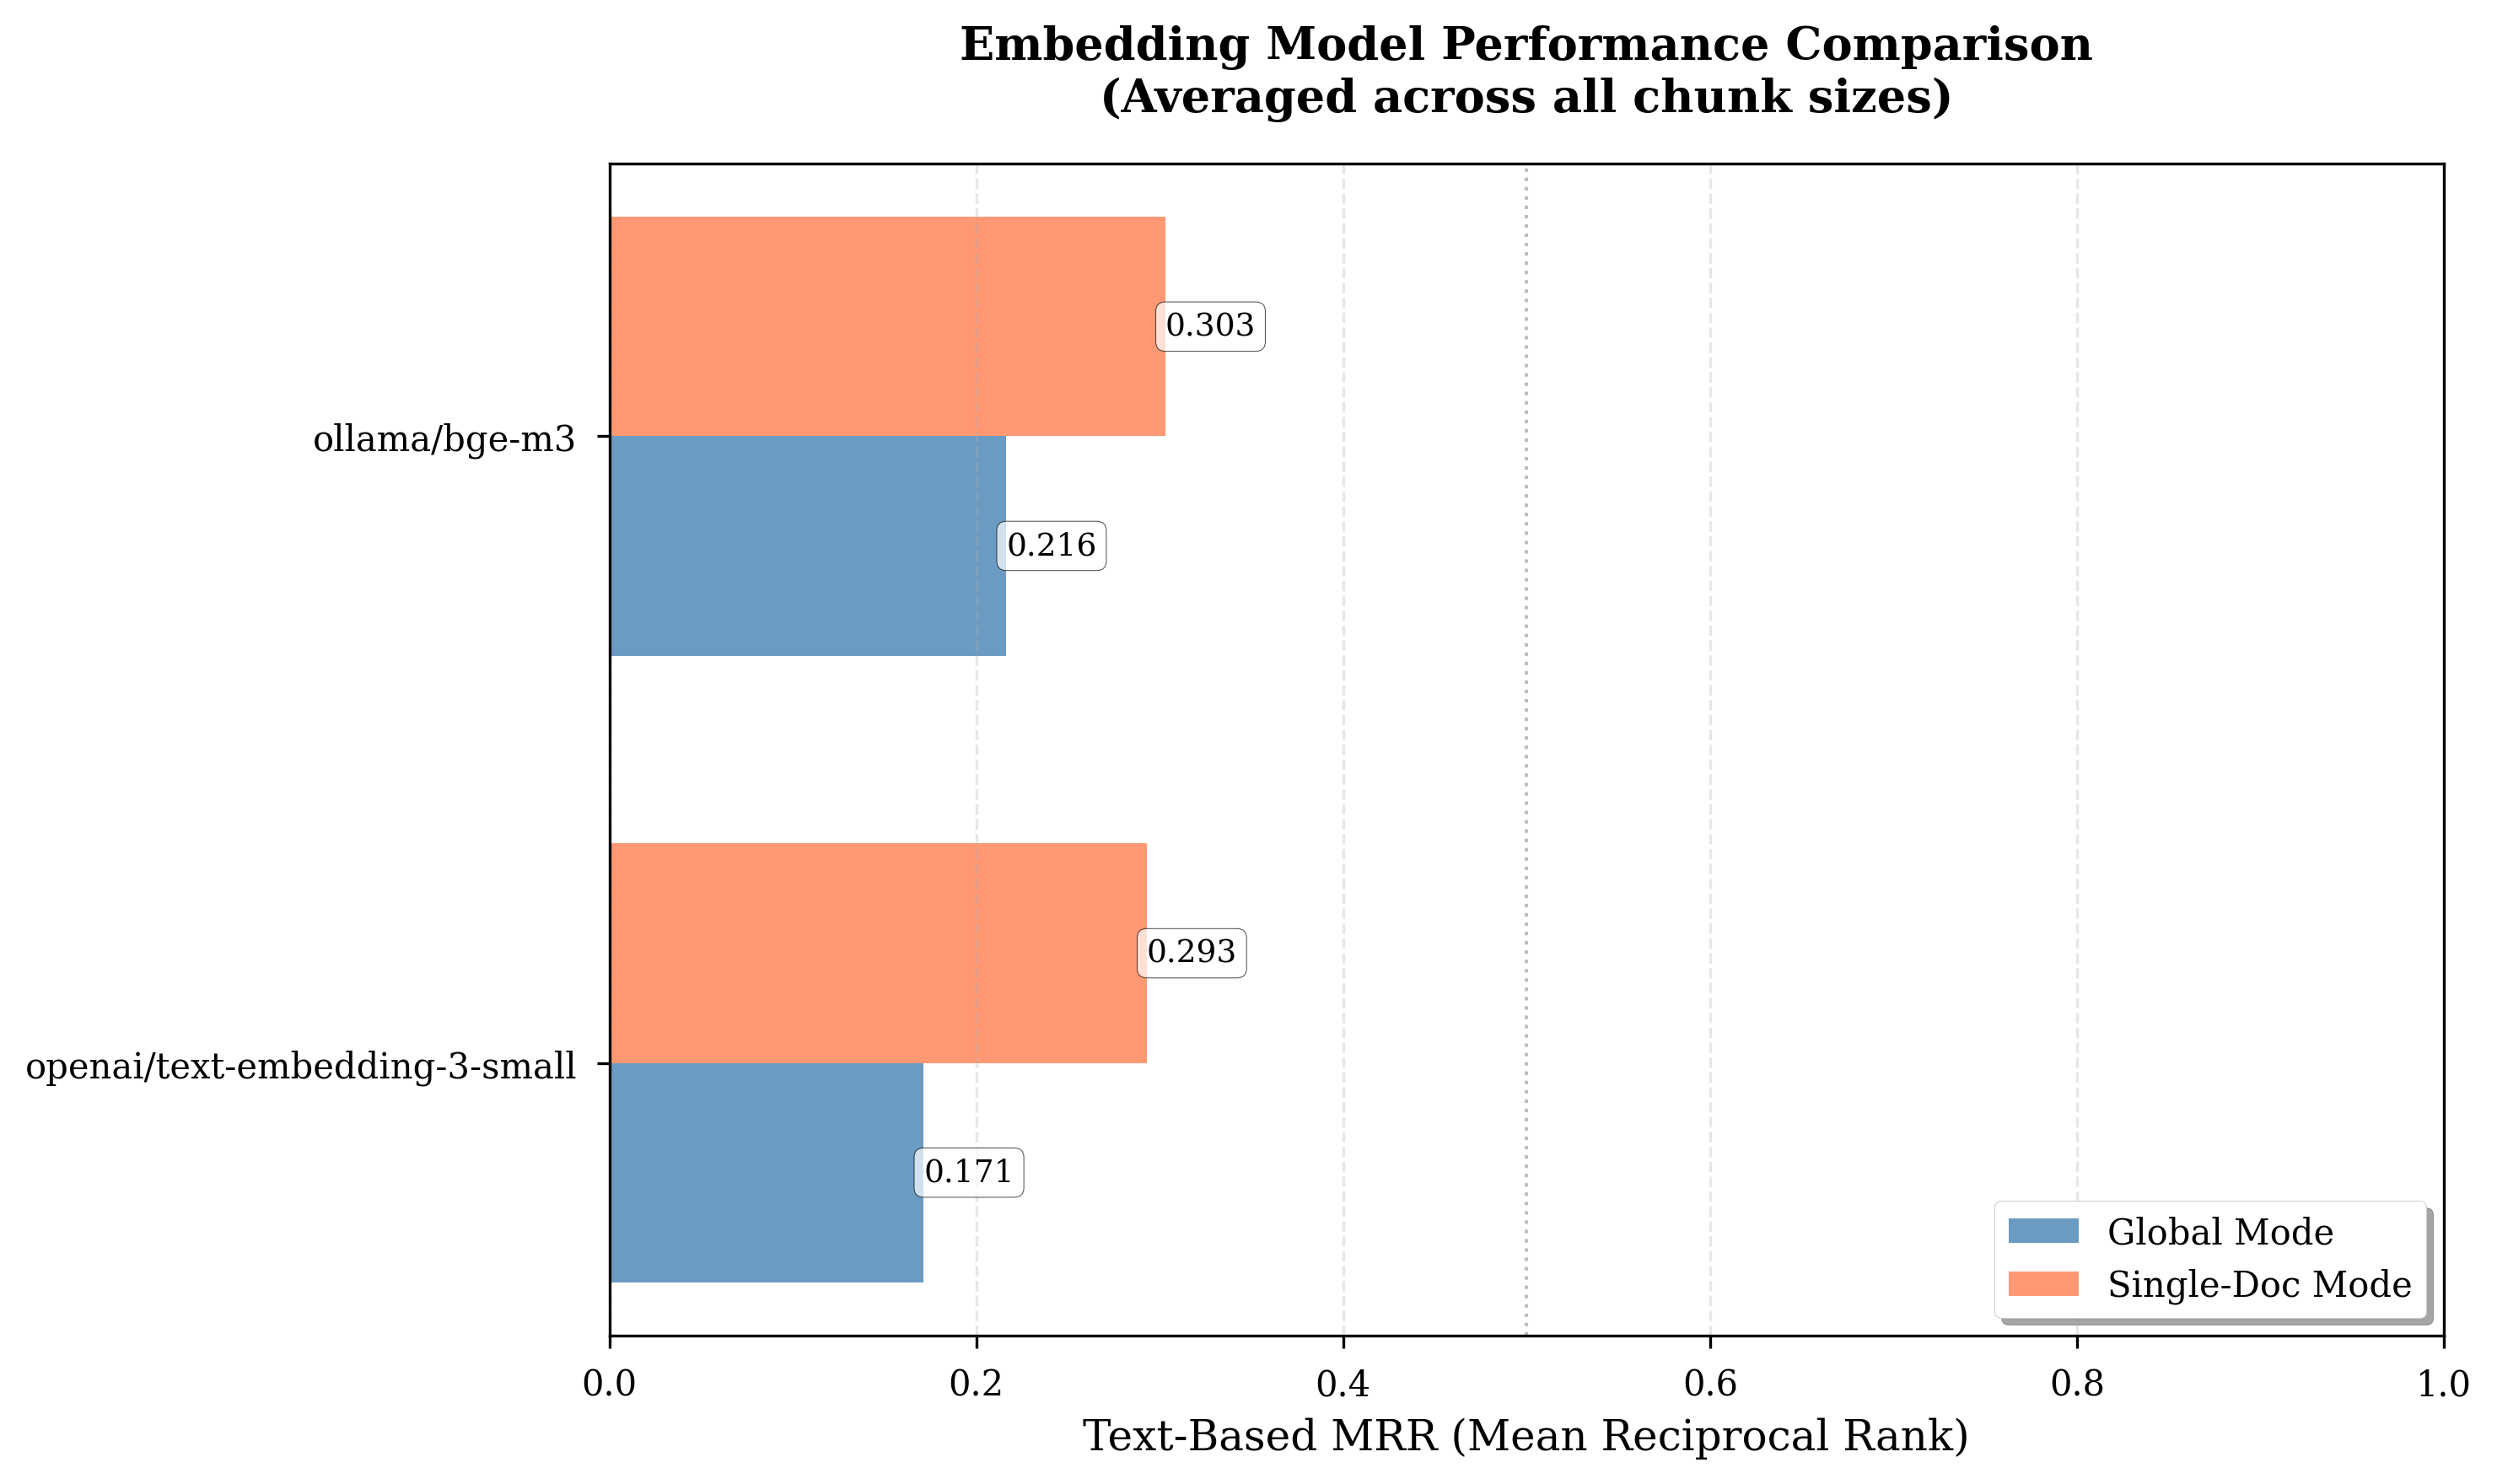

✓ Saved: thesis_plot3_model_chunk_heatmap_global.png and thesis_plot3_model_chunk_heatmap_global.pdf


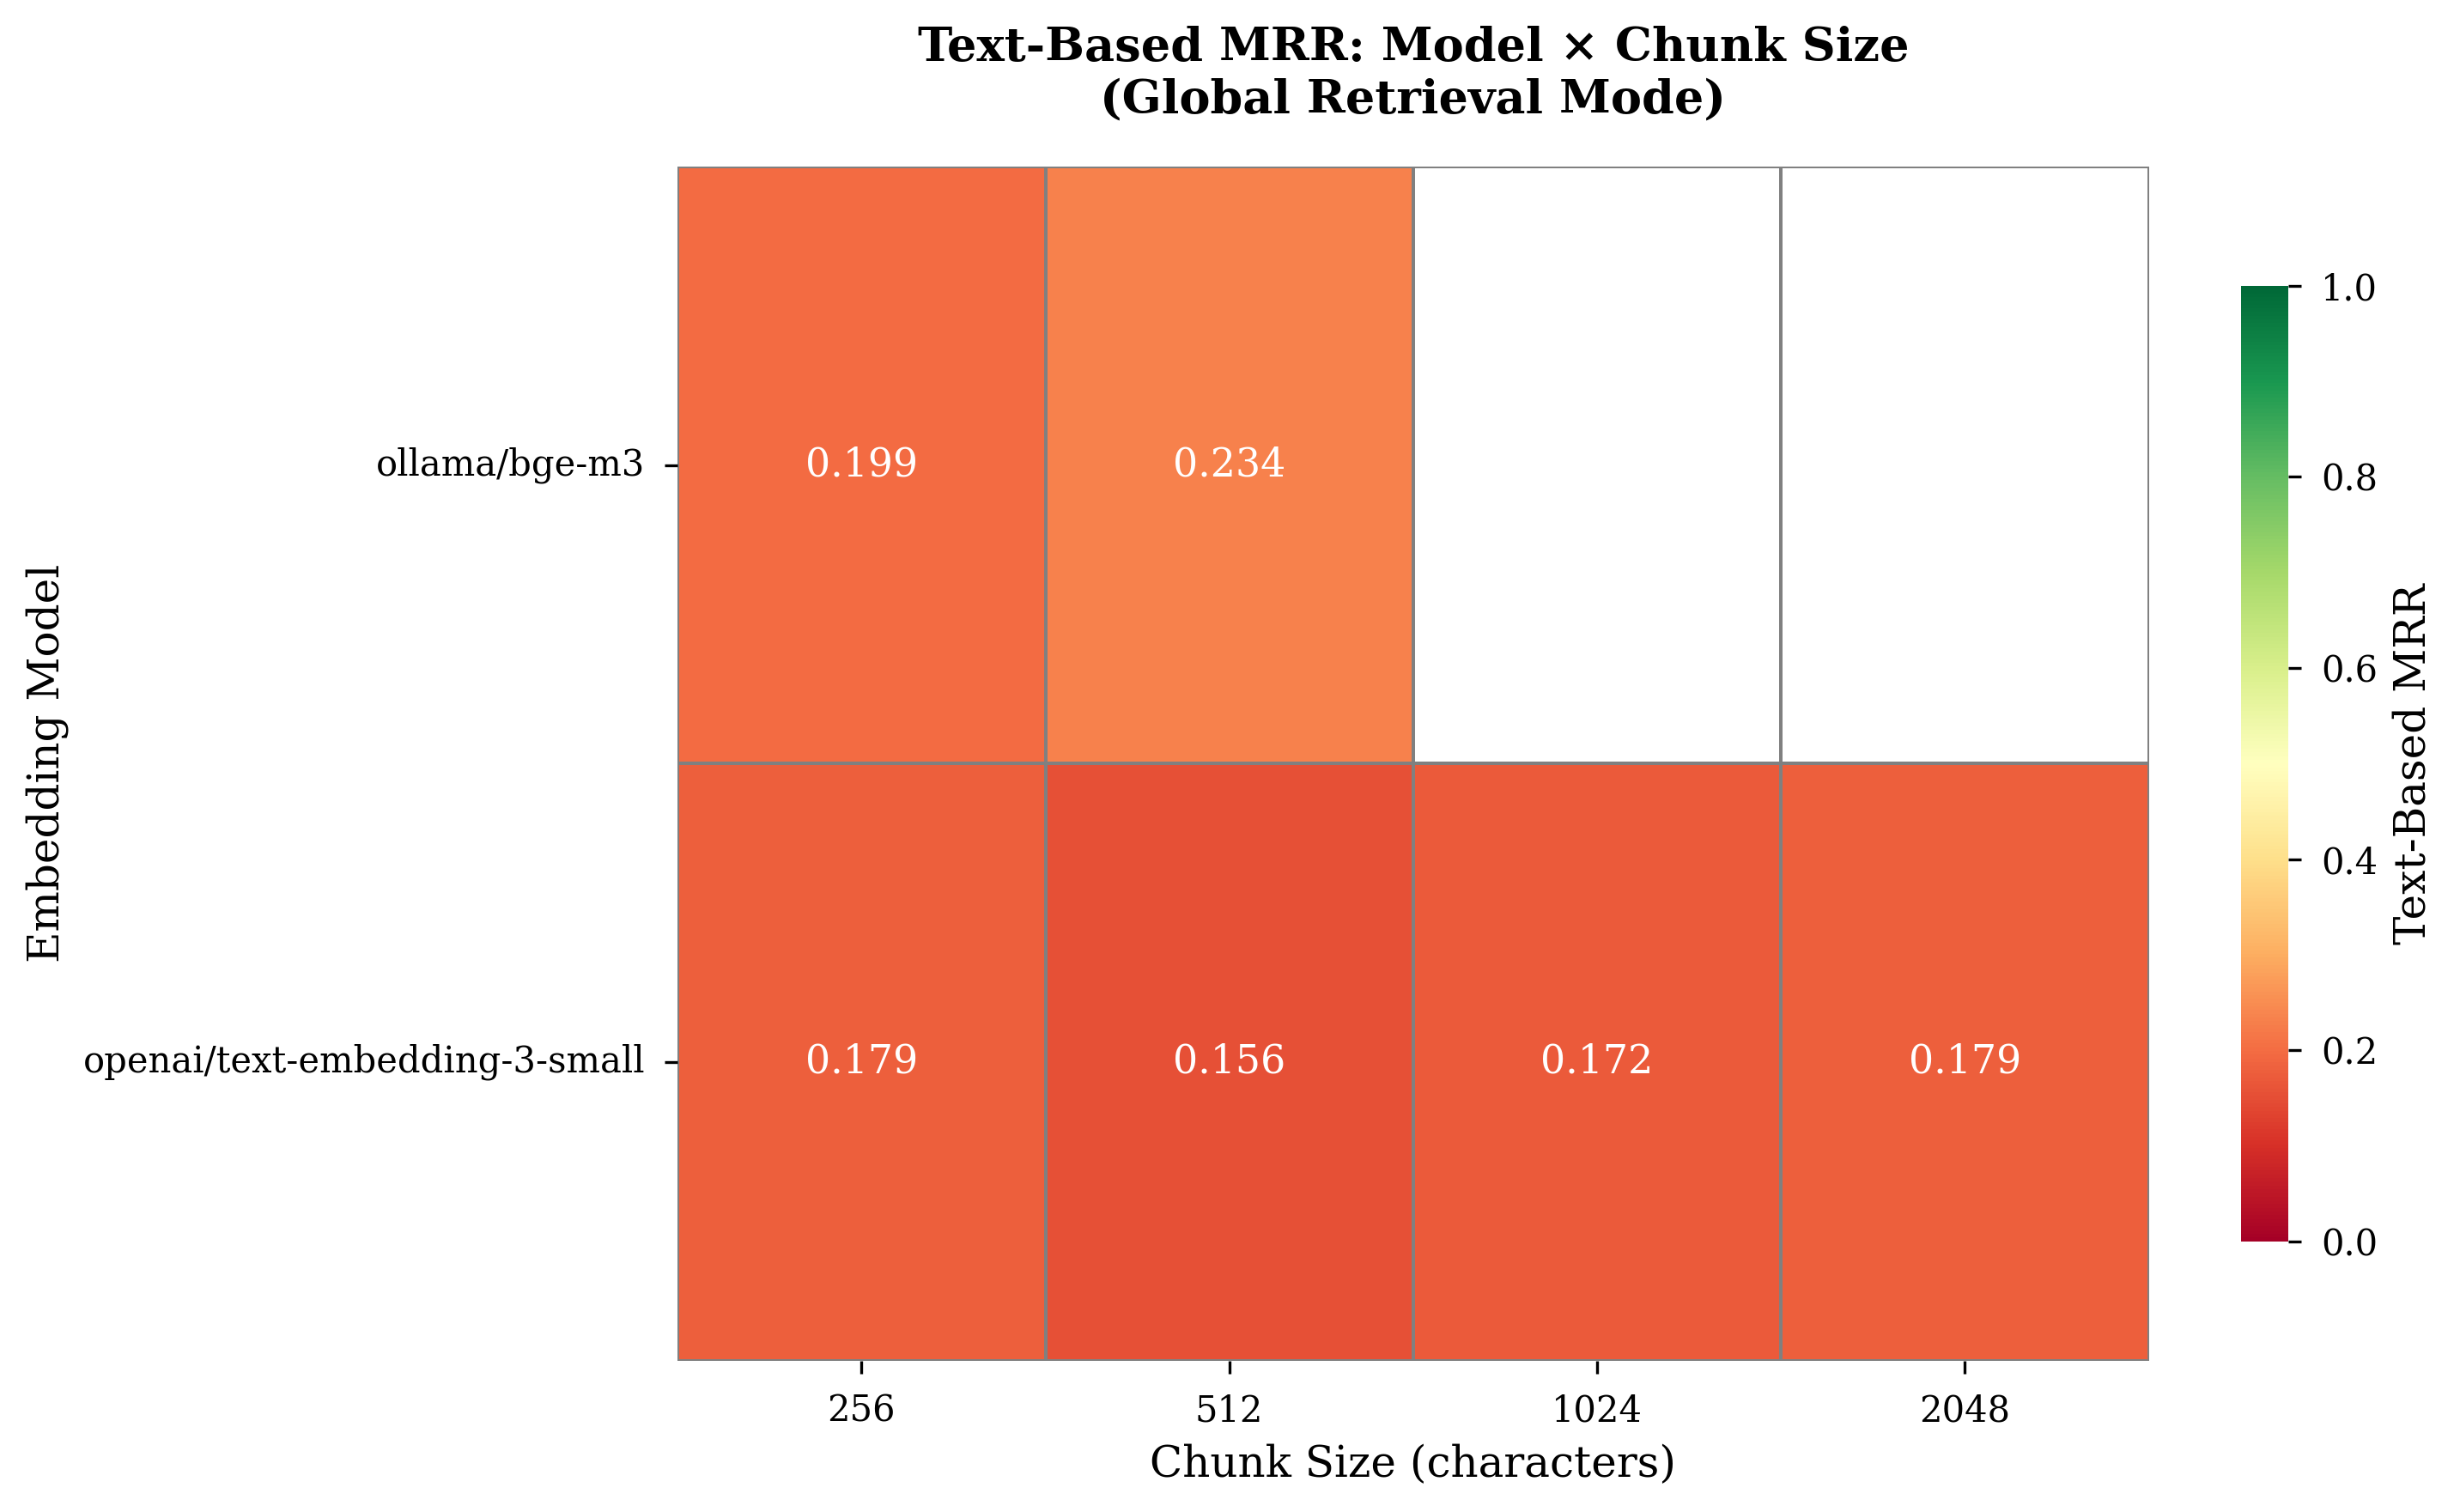


SUMMARY TABLE (Top 10 Configurations)
                        Model  Chunk Size    MRR  Recall  Precision     F1
                ollama/bge-m3         512 0.2337  0.4700     0.0473 0.0830
                ollama/bge-m3         256 0.1991  0.4156     0.0430 0.0753
openai/text-embedding-3-small         256 0.1789  0.3922     0.0350 0.0621
openai/text-embedding-3-small        2048 0.1788  0.4533     0.0377 0.0677
openai/text-embedding-3-small        1024 0.1717  0.4500     0.0387 0.0693
openai/text-embedding-3-small         512 0.1558  0.4167     0.0360 0.0644

✓ Full table saved to: thesis_summary_table.csv

✓ THESIS VISUALIZATION COMPLETE!

📊 Generated 3 Publication-Quality Plots:
  1. thesis_plot1_chunk_size_analysis_global.png/.pdf
     → Shows impact of chunk size on all 4 text-based metrics
     → Line plots with one line per model
     → Easy to compare model performance across chunk sizes

  2. thesis_plot2_model_comparison.png/.pdf
     → Horizontal bar chart ranking models by te

In [33]:
# ============================================================================
# Step 11: Thesis-Quality Text-Based Visualizations
# ============================================================================

# %% [markdown]
# ## 11.1 Import Visualization Libraries

# %%
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path

# Set publication-quality style
plt.style.use('seaborn-v0_8-paper')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 14

print("✓ Visualization libraries imported with thesis-quality styling")

# %% [markdown]
# ## 11.2 Load All Results from JSON Files

# %%
def load_all_results(output_dir: str = OUTPUT_DIR) -> pd.DataFrame:
    """
    Load all JSON result files and create a consolidated DataFrame.
    
    Returns:
        DataFrame with all evaluation results
    """
    print("\n" + "="*60)
    print("LOADING ALL RESULTS")
    print("="*60)
    
    output_path = Path(output_dir)
    json_files = sorted(output_path.glob("*.json"))
    
    print(f"\nFound {len(json_files)} JSON files")
    
    all_data = []
    
    for filepath in tqdm(json_files, desc="Loading results"):
        try:
            with open(filepath, 'r') as f:
                results = json.load(f)
            
            # Extract summary (last item)
            if len(results) > 0 and 'summary' in results[-1]:
                summary = results[-1]['summary']
                
                # Create row for DataFrame
                row = {
                    'provider': summary['provider'],
                    'model': summary['model'],
                    'chunk_size': summary['chunk_size'],
                    'k': summary['k'],
                    'mode': summary['mode'],
                    'page_tolerance': summary.get('use_page_tolerance', True),
                    'text_threshold': summary.get('text_similarity_threshold', 0.7),
                    'total_queries': summary['total_queries'],
                    
                    # Text-based metrics (our focus)
                    'text_mrr': summary['average_text_mrr'],
                    'text_recall': summary['average_text_recall'],
                    'text_precision': summary['average_text_precision'],
                    'text_f1': summary['average_text_f1'],
                    
                    # Page-based metrics (for reference)
                    'page_mrr': summary['average_page_mrr'],
                    'page_recall': summary['average_page_recall'],
                    'page_precision': summary['average_page_precision'],
                    'page_f1': summary['average_page_f1'],
                    
                    'filename': filepath.name
                }
                
                all_data.append(row)
        
        except Exception as e:
            print(f"\n✗ Error loading {filepath.name}: {e}")
    
    # Create DataFrame
    df = pd.DataFrame(all_data)
    
    print(f"\n✓ Loaded {len(df)} result configurations")
    
    if len(df) > 0:
        print(f"\nProviders: {df['provider'].unique()}")
        print(f"Models: {df['model'].unique()}")
        print(f"Chunk sizes: {sorted(df['chunk_size'].unique())}")
        print(f"Modes: {df['mode'].unique()}")
    
    return df

# %%
# Load all results
df_results = load_all_results(OUTPUT_DIR)

# Display summary
if len(df_results) > 0:
    print("\n" + "="*60)
    print("DATA SUMMARY")
    print("="*60)
    print(f"Total configurations: {len(df_results)}")
    print(f"\nText-based metrics range:")
    print(f"  MRR: {df_results['text_mrr'].min():.3f} - {df_results['text_mrr'].max():.3f}")
    print(f"  Recall: {df_results['text_recall'].min():.3f} - {df_results['text_recall'].max():.3f}")
    print(f"  Precision: {df_results['text_precision'].min():.3f} - {df_results['text_precision'].max():.3f}")
    print(f"  F1: {df_results['text_f1'].min():.3f} - {df_results['text_f1'].max():.3f}")

# %% [markdown]
# ## 11.3 Helper Function: Save Figures

# %%
def save_figure(fig, filename: str, output_dir: str = OUTPUT_DIR):
    """
    Save figure in multiple formats for thesis use.
    
    Args:
        fig: Matplotlib figure
        filename: Base filename (without extension)
        output_dir: Output directory
    """
    # Save as PNG (for preview)
    png_path = os.path.join(output_dir, f"{filename}.png")
    fig.savefig(png_path, dpi=300, bbox_inches='tight', facecolor='white')
    
    # Save as PDF (for thesis - vector format)
    pdf_path = os.path.join(output_dir, f"{filename}.pdf")
    fig.savefig(pdf_path, bbox_inches='tight', facecolor='white')
    
    print(f"✓ Saved: {filename}.png and {filename}.pdf")

print("✓ Helper function defined")


# Optional: Generate for singledoc mode as well
# plot_chunk_size_analysis(df_results, mode='singledoc', output_dir=OUTPUT_DIR)

# %% [markdown]
# ## 11.5 PLOT 2: Embedding Model Performance Comparison
# 
# Horizontal bar chart comparing text MRR across all embedding models.
# Shows both global and singledoc modes (if available).

# %%
def plot_model_comparison(df: pd.DataFrame, output_dir: str = OUTPUT_DIR):
    """
    Create horizontal bar chart comparing embedding models.
    
    Shows text MRR averaged across all chunk sizes for each model.
    Separate bars for global and singledoc modes.
    
    Args:
        df: Results DataFrame
        output_dir: Output directory
    """
    if len(df) == 0:
        print("⚠ No data to plot")
        return
    
    # Create model labels
    df_plot = df.copy()
    df_plot['model_label'] = df_plot.apply(
        lambda x: f"{x['provider']}/{x['model']}", axis=1
    )
    
    # Calculate average text MRR for each model and mode
    model_avg = df_plot.groupby(['model_label', 'mode'])['text_mrr'].mean().reset_index()
    
    # Pivot for plotting
    model_pivot = model_avg.pivot(index='model_label', columns='mode', values='text_mrr')
    
    # Sort by global mode performance (or singledoc if global not available)
    if 'global' in model_pivot.columns:
        model_pivot = model_pivot.sort_values('global', ascending=True)
    elif 'singledoc' in model_pivot.columns:
        model_pivot = model_pivot.sort_values('singledoc', ascending=True)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, max(6, len(model_pivot) * 0.5)))
    
    # Plot bars
    y_pos = np.arange(len(model_pivot))
    width = 0.35
    
    if 'global' in model_pivot.columns:
        bars1 = ax.barh(y_pos - width/2, model_pivot['global'], width, 
                       label='Global Mode', color='steelblue', alpha=0.8)
    
    if 'singledoc' in model_pivot.columns:
        bars2 = ax.barh(y_pos + width/2, model_pivot['singledoc'], width, 
                       label='Single-Doc Mode', color='coral', alpha=0.8)
    
    # Add value labels on bars
    def add_value_labels(bars):
        for bar in bars:
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2, 
                   f'{width:.3f}',
                   ha='left', va='center', fontsize=9, 
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    
    if 'global' in model_pivot.columns:
        add_value_labels(bars1)
    if 'singledoc' in model_pivot.columns:
        add_value_labels(bars2)
    
    # Formatting
    ax.set_yticks(y_pos)
    ax.set_yticklabels(model_pivot.index, fontsize=10)
    ax.set_xlabel('Text-Based MRR (Mean Reciprocal Rank)', fontsize=12)
    ax.set_title('Embedding Model Performance Comparison\n(Averaged across all chunk sizes)', 
                 fontsize=13, fontweight='bold', pad=15)
    ax.legend(loc='lower right', frameon=True, shadow=True)
    ax.grid(True, alpha=0.3, axis='x', linestyle='--')
    ax.set_xlim(0, 1.0)
    
    # Add vertical line at 0.5 for reference
    ax.axvline(x=0.5, color='gray', linestyle=':', alpha=0.5, linewidth=1)
    
    plt.tight_layout()
    save_figure(fig, "thesis_plot2_model_comparison", output_dir)
    plt.show()

# %%
plot_model_comparison(df_results, OUTPUT_DIR)

# %% [markdown]
# ## 11.6 PLOT 3: Heatmap - Model × Chunk Size Performance
# 
# Clean heatmap showing text MRR for each combination of model and chunk size.
# Helps identify the optimal configuration at a glance.

# %%
def plot_model_chunk_heatmap(df: pd.DataFrame, mode: str = 'global', output_dir: str = OUTPUT_DIR):
    """
    Create heatmap showing text MRR for each model/chunk_size combination.
    
    Args:
        df: Results DataFrame
        mode: 'global' or 'singledoc'
        output_dir: Output directory
    """
    if len(df) == 0:
        print("⚠ No data to plot")
        return
    
    # Filter by mode
    df_plot = df[df['mode'] == mode].copy()
    
    if len(df_plot) == 0:
        print(f"⚠ No {mode} mode data")
        return
    
    # Create model labels
    df_plot['model_label'] = df_plot.apply(
        lambda x: f"{x['provider']}/{x['model']}", axis=1
    )
    
    # Create pivot table
    pivot_data = df_plot.pivot_table(
        values='text_mrr',
        index='model_label',
        columns='chunk_size',
        aggfunc='mean'
    )
    
    # Sort by average performance
    pivot_data['avg'] = pivot_data.mean(axis=1)
    pivot_data = pivot_data.sort_values('avg', ascending=False)
    pivot_data = pivot_data.drop('avg', axis=1)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, max(6, len(pivot_data) * 0.6)))
    
    # Create heatmap
    sns.heatmap(pivot_data, 
                annot=True, 
                fmt='.3f', 
                cmap='RdYlGn',
                vmin=0, 
                vmax=1.0,
                cbar_kws={'label': 'Text-Based MRR', 'shrink': 0.8},
                linewidths=0.5,
                linecolor='gray',
                ax=ax)
    
    # Formatting
    ax.set_xlabel('Chunk Size (characters)', fontsize=12)
    ax.set_ylabel('Embedding Model', fontsize=12)
    
    mode_title = 'Global Retrieval' if mode == 'global' else 'Single-Document Retrieval'
    ax.set_title(f'Text-Based MRR: Model × Chunk Size\n({mode_title} Mode)', 
                 fontsize=13, fontweight='bold', pad=15)
    
    # Rotate labels
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    save_figure(fig, f"thesis_plot3_model_chunk_heatmap_{mode}", output_dir)
    plt.show()

# %%
plot_model_chunk_heatmap(df_results, mode='global', output_dir=OUTPUT_DIR)

# Optional: Generate for singledoc mode as well
# plot_model_chunk_heatmap(df_results, mode='singledoc', output_dir=OUTPUT_DIR)

# %% [markdown]
# ## 11.7 Generate Summary Statistics Table

# %%
def generate_summary_table(df: pd.DataFrame, output_dir: str = OUTPUT_DIR):
    """
    Generate summary statistics table for thesis.
    
    Creates a CSV file with key metrics for each configuration.
    """
    if len(df) == 0:
        print("⚠ No data to summarize")
        return
    
    # Filter to global mode
    df_table = df[df['mode'] == 'global'].copy()
    
    if len(df_table) == 0:
        print("⚠ No global mode data")
        return
    
    # Create clean table
    df_table['model_label'] = df_table.apply(
        lambda x: f"{x['provider']}/{x['model']}", axis=1
    )
    
    # Select and rename columns
    summary = df_table[['model_label', 'chunk_size', 'text_mrr', 'text_recall', 
                        'text_precision', 'text_f1']].copy()
    summary.columns = ['Model', 'Chunk Size', 'MRR', 'Recall', 'Precision', 'F1']
    
    # Sort by MRR
    summary = summary.sort_values('MRR', ascending=False)
    
    # Round to 4 decimals
    for col in ['MRR', 'Recall', 'Precision', 'F1']:
        summary[col] = summary[col].round(4)
    
    # Save to CSV
    csv_path = os.path.join(output_dir, "thesis_summary_table.csv")
    summary.to_csv(csv_path, index=False)
    
    print("\n" + "="*60)
    print("SUMMARY TABLE (Top 10 Configurations)")
    print("="*60)
    print(summary.head(10).to_string(index=False))
    print(f"\n✓ Full table saved to: thesis_summary_table.csv")
    
    return summary

# %%
summary_table = generate_summary_table(df_results, OUTPUT_DIR)

# %%
print("\n" + "="*80)
print("✓ THESIS VISUALIZATION COMPLETE!")
print("="*80)
print("\n📊 Generated 3 Publication-Quality Plots:")
print("  1. thesis_plot1_chunk_size_analysis_global.png/.pdf")
print("     → Shows impact of chunk size on all 4 text-based metrics")
print("     → Line plots with one line per model")
print("     → Easy to compare model performance across chunk sizes")
print()
print("  2. thesis_plot2_model_comparison.png/.pdf")
print("     → Horizontal bar chart ranking models by text MRR")
print("     → Averaged across all chunk sizes")
print("     → Shows both global and singledoc modes (if available)")
print()
print("  3. thesis_plot3_model_chunk_heatmap_global.png/.pdf")
print("     → Heatmap showing text MRR for each model×chunk_size combination")
print("     → Color-coded for easy identification of best configurations")
print("     → Sorted by average performance")
print()
print("📄 Additional Output:")
print("  • thesis_summary_table.csv")
print("    → Table with all configurations and their metrics")
print("    → Ready to import into thesis")
print()
print("💡 All plots saved in TWO formats:")
print("  • PNG (300 DPI) - for preview and presentations")
print("  • PDF (vector) - for thesis (high quality, scalable)")
print()
print(f"📁 Location: {OUTPUT_DIR}")
print("="*80)

In [ ]:
# ============================================================================
# Summary Table Generation (CSV and Markdown)
# ============================================================================

import pandas as pd
import json
from pathlib import Path
from typing import Optional, Literal

def generate_summary_table(
    df: pd.DataFrame,
    metric_type: Literal['both', 'text_based', 'page_based'] = 'both',
    provider: Optional[str] = None,
    model: Optional[str] = None,
    mode: Optional[str] = None,
    chunk_size: Optional[int] = None,
    k: Optional[int] = None,
    sort_by: str = 'text_mrr',
    ascending: bool = False,
    output_dir: Optional[str] = None,
    filename_prefix: str = 'summary_table'
):
    """
    Generate summary statistics table with both page-based and text-based metrics.
    
    Saves results as:
    - CSV file (for Excel, data analysis)
    - Markdown file (for documentation, thesis)
    
    Args:
        df: Results DataFrame with all evaluation data
        metric_type: 'both' (all metrics), 'text_based', or 'page_based'
        provider: Filter by provider. None = all providers
        model: Filter by model name. None = all models
        mode: Filter by mode. None = all modes
        chunk_size: Filter by chunk_size. None = all chunk sizes
        k: Filter by k value. None = all k values
        sort_by: Column to sort by (e.g., 'text_mrr', 'page_recall')
        ascending: Sort order (False = descending, higher is better)
        output_dir: Directory to save files. None = don't save
        filename_prefix: Prefix for output filenames
    
    Returns:
        DataFrame with summary statistics
    """
    
    # Filter data based on parameters
    df_filtered = df.copy()
    
    if provider is not None:
        df_filtered = df_filtered[df_filtered['provider'] == provider]
    if model is not None:
        df_filtered = df_filtered[df_filtered['model'] == model]
    if mode is not None:
        df_filtered = df_filtered[df_filtered['mode'] == mode]
    if chunk_size is not None:
        df_filtered = df_filtered[df_filtered['chunk_size'] == chunk_size]
    if k is not None:
        df_filtered = df_filtered[df_filtered['k'] == k]
    
    if len(df_filtered) == 0:
        print("⚠ No data matching the specified filters!")
        return pd.DataFrame()
    
    print("\n" + "="*80)
    print("GENERATING SUMMARY TABLE")
    print("="*80)
    print(f"Filtered configurations: {len(df_filtered)}")
    
    # Create model label
    df_filtered['model_label'] = df_filtered.apply(
        lambda x: f"{x['provider']}/{x['model']}", axis=1
    )
    
    # Select columns based on metric_type
    base_columns = ['model_label', 'chunk_size', 'k', 'mode']
    
    if metric_type == 'both':
        metric_columns = [
            'text_mrr', 'text_recall', 'text_precision', 'text_f1',
            'page_mrr', 'page_recall', 'page_precision', 'page_f1'
        ]
    elif metric_type == 'text_based':
        metric_columns = ['text_mrr', 'text_recall', 'text_precision', 'text_f1']
    else:  # page_based
        metric_columns = ['page_mrr', 'page_recall', 'page_precision', 'page_f1']
    
    # Select and prepare summary DataFrame
    summary = df_filtered[base_columns + metric_columns].copy()
    
    # Rename columns for better readability
    column_mapping = {
        'model_label': 'Model',
        'chunk_size': 'Chunk Size',
        'k': 'K',
        'mode': 'Mode',
        'text_mrr': 'Text MRR',
        'text_recall': 'Text Recall',
        'text_precision': 'Text Precision',
        'text_f1': 'Text F1',
        'page_mrr': 'Page MRR',
        'page_recall': 'Page Recall',
        'page_precision': 'Page Precision',
        'page_f1': 'Page F1'
    }
    
    summary = summary.rename(columns=column_mapping)
    
    # Sort by specified column
    if sort_by in df_filtered.columns:
        sort_col_display = column_mapping.get(sort_by, sort_by)
        summary = summary.sort_values(sort_col_display, ascending=ascending)
    
    # Round metrics to 4 decimals
    for col in summary.columns:
        if any(metric in col for metric in ['MRR', 'Recall', 'Precision', 'F1']):
            summary[col] = summary[col].round(4)
    
    # Save files if output_dir is specified
    if output_dir:
        output_path = Path(output_dir)
        output_path.mkdir(parents=True, exist_ok=True)
        
        # Build filename with filters
        filename_parts = [filename_prefix]
        if provider:
            filename_parts.append(provider)
        if model:
            filename_parts.append(model.replace('/', '_'))
        if mode:
            filename_parts.append(mode)
        if chunk_size:
            filename_parts.append(f"chunk{chunk_size}")
        
        base_filename = "_".join(filename_parts)
        
        # Save as CSV
        csv_path = output_path / f"{base_filename}.csv"
        summary.to_csv(csv_path, index=False)
        print(f"✓ Saved CSV: {csv_path.name}")
        
        # Save as Markdown
        md_path = output_path / f"{base_filename}.md"
        with open(md_path, 'w') as f:
            f.write(f"# Summary Table\n\n")
            
            # Add filter information
            if any([provider, model, mode, chunk_size, k]):
                f.write("## Filters Applied\n\n")
                if provider:
                    f.write(f"- **Provider**: {provider}\n")
                if model:
                    f.write(f"- **Model**: {model}\n")
                if mode:
                    f.write(f"- **Mode**: {mode}\n")
                if chunk_size:
                    f.write(f"- **Chunk Size**: {chunk_size}\n")
                if k:
                    f.write(f"- **K**: {k}\n")
                f.write("\n")
            
            f.write(f"Total configurations: {len(summary)}\n\n")
            f.write("## Results\n\n")
            f.write(summary.to_markdown(index=False))
            f.write("\n")
        
        print(f"✓ Saved Markdown: {md_path.name}")
    
    # Display summary in console
    print("\n" + "="*80)
    print(f"SUMMARY TABLE (Top 10 configurations, sorted by {sort_by})")
    print("="*80)
    print(summary.head(10).to_string(index=False))
    
    if len(summary) > 10:
        print(f"\n... and {len(summary) - 10} more configurations")
    
    print("\n" + "="*80)
    
    return summary


def generate_aggregated_summary(
    df: pd.DataFrame,
    group_by: list = ['provider', 'model'],
    metric_type: Literal['both', 'text_based', 'page_based'] = 'both',
    mode: Optional[str] = None,
    output_dir: Optional[str] = None,
    filename_prefix: str = 'aggregated_summary'
):
    """
    Generate aggregated summary table (averaging across chunk sizes, k values, etc.).
    
    Useful for high-level model comparison.
    
    Args:
        df: Results DataFrame
        group_by: List of columns to group by (e.g., ['provider', 'model', 'mode'])
        metric_type: 'both', 'text_based', or 'page_based'
        mode: Filter by mode. None = all modes
        output_dir: Directory to save files
        filename_prefix: Prefix for output filenames
    
    Returns:
        Aggregated DataFrame
    """
    
    # Filter by mode if specified
    df_filtered = df.copy()
    if mode is not None:
        df_filtered = df_filtered[df_filtered['mode'] == mode]
    
    if len(df_filtered) == 0:
        print("⚠ No data matching the specified filters!")
        return pd.DataFrame()
    
    print("\n" + "="*80)
    print("GENERATING AGGREGATED SUMMARY TABLE")
    print("="*80)
    
    # Select metrics to aggregate
    if metric_type == 'both':
        metric_columns = [
            'text_mrr', 'text_recall', 'text_precision', 'text_f1',
            'page_mrr', 'page_recall', 'page_precision', 'page_f1'
        ]
    elif metric_type == 'text_based':
        metric_columns = ['text_mrr', 'text_recall', 'text_precision', 'text_f1']
    else:  # page_based
        metric_columns = ['page_mrr', 'page_recall', 'page_precision', 'page_f1']
    
    # Group and aggregate
    agg_summary = df_filtered.groupby(group_by)[metric_columns].mean().reset_index()
    
    # Create model label if grouping by provider and model
    if 'provider' in group_by and 'model' in group_by:
        agg_summary['model_label'] = agg_summary.apply(
            lambda x: f"{x['provider']}/{x['model']}", axis=1
        )
        # Reorder columns to put model_label first
        cols = ['model_label'] + [col for col in agg_summary.columns if col not in ['model_label', 'provider', 'model']]
        agg_summary = agg_summary[cols]
    
    # Sort by text_mrr (or first metric)
    sort_col = metric_columns[0]
    agg_summary = agg_summary.sort_values(sort_col, ascending=False)
    
    # Round metrics
    for col in metric_columns:
        agg_summary[col] = agg_summary[col].round(4)
    
    # Rename columns for display
    display_mapping = {
        'model_label': 'Model',
        'provider': 'Provider',
        'model': 'Model Name',
        'mode': 'Mode',
        'text_mrr': 'Text MRR',
        'text_recall': 'Text Recall',
        'text_precision': 'Text Precision',
        'text_f1': 'Text F1',
        'page_mrr': 'Page MRR',
        'page_recall': 'Page Recall',
        'page_precision': 'Page Precision',
        'page_f1': 'Page F1'
    }
    
    agg_summary_display = agg_summary.rename(columns=display_mapping)
    
    # Save files if output_dir specified
    if output_dir:
        output_path = Path(output_dir)
        output_path.mkdir(parents=True, exist_ok=True)
        
        # Build filename
        filename_parts = [filename_prefix]
        if mode:
            filename_parts.append(mode)
        base_filename = "_".join(filename_parts)
        
        # Save CSV
        csv_path = output_path / f"{base_filename}.csv"
        agg_summary_display.to_csv(csv_path, index=False)
        print(f"✓ Saved CSV: {csv_path.name}")
        
        # Save Markdown
        md_path = output_path / f"{base_filename}.md"
        with open(md_path, 'w') as f:
            f.write(f"# Aggregated Summary Table\n\n")
            f.write(f"**Grouped by**: {', '.join(group_by)}\n\n")
            if mode:
                f.write(f"**Mode**: {mode}\n\n")
            f.write(f"**Note**: Metrics are averaged across all chunk sizes and k values.\n\n")
            f.write("## Results\n\n")
            f.write(agg_summary_display.to_markdown(index=False))
            f.write("\n")
        
        print(f"✓ Saved Markdown: {md_path.name}")
    
    # Display in console
    print("\n" + "="*80)
    print("AGGREGATED SUMMARY")
    print("="*80)
    print(agg_summary_display.to_string(index=False))
    print("\n" + "="*80)
    
    return agg_summary_display


# ============================================================================
# Example Usage
# ============================================================================

# Load your data
df_results = load_all_results(OUTPUT_DIR)

REPORTS_OUTPUT_DIR = os.path.join(OUTPUT_DIR, "reports")

# # Example 1: All metrics, global mode only
# generate_summary_table(
#     df_results,
#     metric_type='both',  # Shows all 8 metrics (4 text + 4 page)
#     mode='global',
#     sort_by='text_mrr',
#     output_dir=REPORTS_OUTPUT_DIR,
#     filename_prefix='full_summary'
# )

# # Example 2: Text-based only, OpenAI models
# generate_summary_table(
#     df_results,
#     metric_type='text_based',  # Only text metrics
#     provider='openai',
#     mode='global',
#     output_dir=REPORTS_OUTPUT_DIR,
#     filename_prefix='openai_text'
# )

# # Example 3: Specific chunk size
# generate_summary_table(
#     df_results,
#     metric_type='both',
#     chunk_size=2048,
#     sort_by='page_mrr',  # Sort by page metrics
#     output_dir=OUTPUT_DIR,
#     filename_prefix='chunk2048'
# )

# # Example 4: Page-based only
# generate_summary_table(
#     df_results,
#     metric_type='page_based',  # Only page metrics
#     mode='singledoc',
#     output_dir=REPORTS_OUTPUT_DIR,
#     filename_prefix='page_metrics'
# )

# # Example 1: Average across all chunk sizes and k values
# generate_aggregated_summary(
#     df_results,
#     group_by=['provider', 'model', 'mode'],
#     metric_type='both',
#     output_dir=REPORTS_OUTPUT_DIR,
#     filename_prefix='model_comparison'
# )

# # Example 2: Compare models within global mode only
# generate_aggregated_summary(
#     df_results,
#     group_by=['provider', 'model'],
#     metric_type='both',
#     mode='global',
#     output_dir=REPORTS_OUTPUT_DIR,
#     filename_prefix='global_model_avg'
# )

# # Example 3: Compare by provider only
# generate_aggregated_summary(
#     df_results,
#     group_by=['provider'],
#     metric_type='text_based',
#     output_dir=REPORTS_OUTPUT_DIR,
#     filename_prefix='provider_comparison'
# )


LOADING ALL RESULTS

Found 42 JSON files


Loading results:   0%|          | 0/42 [00:00<?, ?it/s]


✓ Loaded 42 result configurations

Providers: ['ollama' 'openai' 'voyage']
Models: ['bge-m3' 'nomic-embed-text' 'text-embedding-3-large'
 'text-embedding-3-small' 'voyage-3-large' 'voyage-finance-2']
Chunk sizes: [np.int64(256), np.int64(512), np.int64(1024), np.int64(2048)]
Modes: ['global' 'singledoc']

GENERATING SUMMARY TABLE
Filtered configurations: 21
✓ Saved CSV: full_summary_global.csv
✓ Saved Markdown: full_summary_global.md

SUMMARY TABLE (Top 10 configurations, sorted by text_mrr)
                        Model  Chunk Size  K   Mode  Text MRR  Text Recall  Text Precision  Text F1  Page MRR  Page Recall  Page Precision  Page F1
        voyage/voyage-3-large        2048 20 global    0.4350       0.6578          0.0560   0.1005    0.5831       0.9244          0.0770   0.1403
        voyage/voyage-3-large        1024 20 global    0.4171       0.6511          0.0560   0.1005    0.5540       0.8989          0.0693   0.1271
        voyage/voyage-3-large         512 20 global    0.3

Model  Chunk Size   K    Mode  Text MRR  \
32          voyage/voyage-3-large        2048  20  global    0.4350   
30          voyage/voyage-3-large        1024  20  global    0.4171   
34          voyage/voyage-3-large         512  20  global    0.3774   
40        voyage/voyage-finance-2         512  20  global    0.2858   
18  openai/text-embedding-3-large        2048  20  global    0.2794   
16  openai/text-embedding-3-large        1024  20  global    0.2740   
38        voyage/voyage-finance-2        2048  20  global    0.2704   
36        voyage/voyage-finance-2        1024  20  global    0.2600   
20  openai/text-embedding-3-large         512  20  global    0.2458   
6                   ollama/bge-m3         512  20  global    0.2337   
4                   ollama/bge-m3         256  20  global    0.1991   
14        ollama/nomic-embed-text         512  20  global    0.1921   
0                   ollama/bge-m3        1024  20  global    0.1876   
2                   ollama/bge-m3        2048  20  global    0.1818   
26  openai/text-embedding-3-small         256  20  global    0.1789   
24  openai/text-embedding-3-small        2048  20  global    0.1788   
12        ollama/nomic-embed-text         256  20  global    0.1761   
22  openai/text-embedding-3-small        1024  20  global    0.1717   
28  openai/text-embedding-3-small         512  20  global    0.1558   
8         ollama/nomic-embed-text        1024  20  global    0.1299   
10        ollama/nomic-embed-text        2048  20  global    0.1238   

    Text Recall  Text Precision  Text F1  Page MRR  Page Recall  \
32       0.6578          0.0560   0.1005    0.5831       0.9244   
30       0.6511          0.0560   0.1005    0.5540       0.8989   
34       0.6322          0.0533   0.0958    0.5177       0.8267   
40       0.5533          0.0530   0.0936    0.4016       0.7389   
18       0.5478          0.0563   0.0988    0.3819       0.7867   
16       0.5278          0.0550   0.0963    0.3611       0.7578   
38       0.5422          0.0517   0.0915    0.4244       0.8233   
36       0.5322          0.0520   0.0918    0.4158       0.7656   
20       0.5300          0.0503   0.0893    0.3478       0.7044   
6        0.4700          0.0473   0.0830    0.2538       0.5967   
4        0.4156          0.0430   0.0753    0.2422       0.5156   
14       0.4533          0.0427   0.0748    0.2456       0.5156   
0        0.3522          0.0333   0.0587    0.2467       0.4522   
2        0.3689          0.0343   0.0607    0.2537       0.5044   
26       0.3922          0.0350   0.0621    0.2478       0.5311   
24       0.4533          0.0377   0.0677    0.2975       0.7200   
12       0.3722          0.0403   0.0701    0.2140       0.5033   
22       0.4500          0.0387   0.0693    0.2740       0.6467   
28       0.4167          0.0360   0.0644    0.2346       0.5778   
8        0.2933          0.0293   0.0506    0.1879       0.4244   
10       0.3289          0.0310   0.0538    0.1966       0.5011   

    Page Precision  Page F1  
32          0.0770   0.1403  
30          0.0693   0.1271  
34          0.0640   0.1173  
40          0.0577   0.1058  
18          0.0657   0.1194  
16          0.0597   0.1092  
38          0.0697   0.1261  
36          0.0617   0.1124  
20          0.0560   0.1025  
6           0.0430   0.0794  
4           0.0430   0.0774  
14          0.0373   0.0687  
0           0.0343   0.0630  
2           0.0433   0.0784  
26          0.0453   0.0816  
24          0.0550   0.1006  
12          0.0420   0.0754  
22          0.0477   0.0878  
28          0.0413   0.0762  
8           0.0310   0.0571  
10          0.0397   0.0724